In [1]:
import meta_poisoning_typical as mp
import mlp

/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from tqdm import trange, tqdm

from einops import einsum, rearrange, repeat, reduce

import glob

In [3]:
from importlib import reload
reload(mp)
reload(mlp)

Params = mlp.Params
MLP = mlp.MLP
ellipsoid_norm = mlp.ellipsoid_norm

# 09-30

In [142]:
# list all paths beginning with pinit_0928

paths = glob.glob('pinit_0928*') + glob.glob('pinit_0930*')

train_accs = []
test_accs = []

all_metrics = {}

for path in paths:
    print(path)

    train_size = 64 if "_64" in path else 128 if "_128" in path else 256

    cfg = mp.MetaConfig(num_layers=1, spherical=True, 
                    train_size=train_size,
                    meta_constrain=True, mesa_constrain=True)
    
    X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test = mp.get_digits_splits(cfg)

    XY = {'train': (X_train, Y_train), 'untrain': (X_untrain, Y_untrain), 'test': (X_test, Y_test)}

    model, params = mp.get_model(cfg, X_train)

    def just_metrics(params, X, Y):
        logits = model.apply(params.unraveled, X)
        preds = jnp.argmax(logits, axis=-1)

        loss = mp.sparse_xent(logits, Y).mean()
        acc = jnp.mean(preds == Y)
        return loss, acc

    def final_metrics(params):
        apply_fn = mp.make_apply_full(model, params.unravel)
        poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
            params.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
            target_norm=ellipsoid_norm(params, spherical=True), unravel=params.unravel,
            return_state=True,
        )
        
        params_final = Params(state.params['p'], params.unravel)

        metrics = {}
        for split in XY:
            metrics[split] = just_metrics(params_final, XY[split][0], XY[split][1])
        return metrics
    
    with open(path, 'rb') as f:
        saved_params = mlp.Params(jnp.load(f, allow_pickle=True), params.unravel)
    
    metrics = final_metrics(saved_params)

    train_accs.append(metrics['train'][1])
    test_accs.append(metrics['test'][1])

    all_metrics[path] = metrics

pinit_0928_beta05.npy
pinit_0928_beta05_lr001.npy
pinit_0928_beta05_lr03.npy
pinit_0928_beta05_weird.npy
pinit_0928_beta05_weird_lr001.npy
pinit_0928_beta05_128.npy
pinit_0928_beta05_64.npy
pinit_0928_beta03_64.npy
pinit_0928_beta03.npy
pinit_0928_beta03_lr03.npy
pinit_0928_beta03_weird_lr001.npy
pinit_0928_beta03_lr001.npy
pinit_0928_beta03_weird.npy
pinit_0928_beta03_128.npy
pinit_0928_beta01_64.npy
pinit_0928_beta01_lr03.npy
pinit_0928_beta01.npy
pinit_0928_beta01_weird_lr001.npy
pinit_0928_beta01_lr001.npy
pinit_0928_beta01_weird.npy
pinit_0928_beta01_128.npy
pinit_0928_beta07_64.npy
pinit_0928_beta07_lr03.npy
pinit_0928_beta07.npy
pinit_0928_beta07_weird_lr001.npy
pinit_0928_beta07_lr001.npy
pinit_0928_beta07_128.npy
pinit_0928_beta07_weird.npy
pinit_0928_beta09_64.npy
pinit_0928_beta09.npy
pinit_0928_beta09_lr03.npy
pinit_0928_beta09_weird_lr001.npy
pinit_0928_beta09_weird.npy
pinit_0928_beta09_128.npy
pinit_0928_beta09_lr001.npy
pinit_0928_beta097_64.npy
pinit_0928_beta097.npy
p

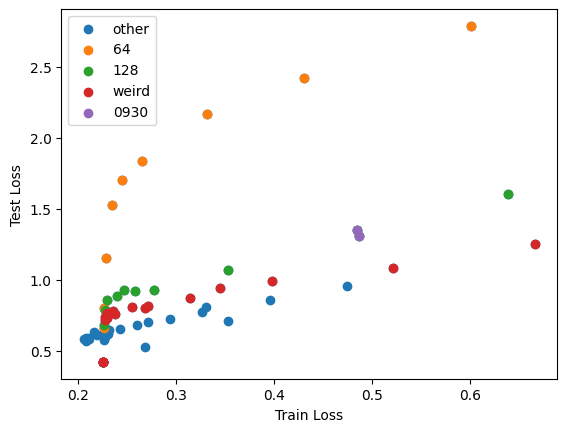

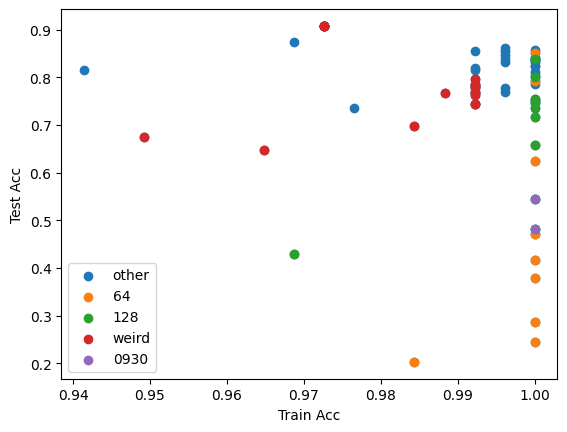

In [143]:
for metric in [0, 1]:

    train_losses = [all_metrics[path]['train'][metric] for path in paths]
    test_losses = [all_metrics[path]['test'][metric] for path in paths]
    
    specific_train_losses = {}
    specific_test_losses = {}
    for string in ['weird', '_64', '_128', '0930']:
        specific_train_losses[string] = [all_metrics[path]['train'][metric] for path in paths if string in path]
        specific_test_losses[string] = [all_metrics[path]['test'][metric] for path in paths if string in path]
    
    plt.scatter(train_losses, test_losses, label='other')
    plt.scatter(specific_train_losses['_64'], specific_test_losses['_64'], label='64')
    plt.scatter(specific_train_losses['_128'], specific_test_losses['_128'], label='128')
    plt.scatter(specific_train_losses['weird'], specific_test_losses['weird'], label='weird')
    plt.scatter(specific_train_losses['0930'], specific_test_losses['0930'], label='0930')
    plt.xlabel(f'Train {["Loss", "Acc"][metric]}')
    plt.ylabel(f'Test {["Loss", "Acc"][metric]}')
    plt.legend()
    plt.show()

In [144]:
for path in paths:
    if all_metrics[path]['test'][1] < 0.7 and '128' in path:
        print(path)
        metrics = all_metrics[path]
        for split in ['train', 'test', 'untrain']:
            print(split, metrics[split])
        print()

pinit_0928_beta097_128.npy
train (Array(0.35299522, dtype=float32), Array(1., dtype=float32))
test (Array(1.0693009, dtype=float32), Array(0.6590038, dtype=float32))
untrain (Array(1.0487117, dtype=float32), Array(0.6519887, dtype=float32))

pinit_0928_beta099_128.npy
train (Array(0.63897, dtype=float32), Array(0.96875, dtype=float32))
test (Array(1.6035371, dtype=float32), Array(0.42911875, dtype=float32))
untrain (Array(1.6087425, dtype=float32), Array(0.4005682, dtype=float32))

pinit_0930_beta09_128.npy
train (Array(0.48644847, dtype=float32), Array(1., dtype=float32))
test (Array(1.3109102, dtype=float32), Array(0.5440613, dtype=float32))
untrain (Array(1.2963213, dtype=float32), Array(0.556108, dtype=float32))

pinit_0930_beta07_128.npy
train (Array(0.4842022, dtype=float32), Array(1., dtype=float32))
test (Array(1.3533689, dtype=float32), Array(0.4827586, dtype=float32))
untrain (Array(1.3376198, dtype=float32), Array(0.5149148, dtype=float32))



In [17]:
for path in paths:
    if 'weird' in path:
        continue
    if all_metrics[path]['test'][1] < 0.8:
        print(path)
        print(all_metrics[path])

pinit_0928_beta05.npy
{'train': (Array(0.05358891, dtype=float32), Array(1., dtype=float32)), 'untrain': (Array(0.56045055, dtype=float32), Array(0.8226563, dtype=float32)), 'test': (Array(0.647712, dtype=float32), Array(0.8007663, dtype=float32))}
pinit_0928_beta05_lr001.npy
{'train': (Array(0.093632, dtype=float32), Array(1., dtype=float32)), 'untrain': (Array(0.631808, dtype=float32), Array(0.79765624, dtype=float32)), 'test': (Array(0.7067672, dtype=float32), Array(0.77777773, dtype=float32))}
pinit_0928_beta05_lr03.npy
{'train': (Array(0.05495215, dtype=float32), Array(1., dtype=float32)), 'untrain': (Array(0.5719317, dtype=float32), Array(0.8023438, dtype=float32)), 'test': (Array(0.65289557, dtype=float32), Array(0.8237548, dtype=float32))}
pinit_0928_beta05_128.npy
{'train': (Array(0.23989496, dtype=float32), Array(1., dtype=float32)), 'untrain': (Array(0.76768184, dtype=float32), Array(0.76633525, dtype=float32)), 'test': (Array(0.8312897, dtype=float32), Array(0.77394634, dty

In [35]:
for train_size in [64, 128, 256]:
    print(train_size)
    cfg = mp.MetaConfig(num_layers=1, spherical=True, 
                    train_size=train_size,
                    meta_constrain=True, mesa_constrain=True)

    X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test = mp.get_digits_splits(cfg)

    XY = {'train': (X_train, Y_train), 'untrain': (X_untrain, Y_untrain), 'test': (X_test, Y_test)}

    model, params = mp.get_model(cfg, X_train)

    def just_metrics(params, X, Y):
        logits = model.apply(params.unraveled, X)
        preds = jnp.argmax(logits, axis=-1)

        loss = mp.sparse_xent(logits, Y).mean()
        acc = jnp.mean(preds == Y)
        return loss, acc

    def final_metrics(params):
        apply_fn = mp.make_apply_full(model, params.unravel)
        poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
            params.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
            target_norm=ellipsoid_norm(params, spherical=True), unravel=params.unravel,
            return_state=True,
        )
        
        params_final = Params(state.params['p'], params.unravel)

        metrics = {}
        for split in XY:
            metrics[split] = just_metrics(params_final, XY[split][0], XY[split][1])
        return metrics

    mets = final_metrics(params)

    for split in ['train', 'test', 'untrain']:
        print(split, mets[split])

64


train (Array(1.2306297, dtype=float32), Array(0.859375, dtype=float32))
test (Array(1.4474229, dtype=float32), Array(0.6934866, dtype=float32))
untrain (Array(1.4262797, dtype=float32), Array(0.6847826, dtype=float32))
128
train (Array(0.4683079, dtype=float32), Array(0.9453125, dtype=float32))
test (Array(0.6762091, dtype=float32), Array(0.86590034, dtype=float32))
untrain (Array(0.6335025, dtype=float32), Array(0.8636364, dtype=float32))
256
train (Array(0.22557801, dtype=float32), Array(0.97265625, dtype=float32))
test (Array(0.42319784, dtype=float32), Array(0.90804595, dtype=float32))
untrain (Array(0.37084377, dtype=float32), Array(0.909375, dtype=float32))


# 09-25+ Basin radius

## Defns

In [20]:
# _spher

cfg = mp.MetaConfig(num_layers=1, un_xent=True, spherical=True, 
                    train_size=768, loss_temp=10.0, meta_lr=1e-2,
                    meta_constrain=True, mesa_constrain=True)

In [43]:
# _smol

train_size = 128

cfg = mp.MetaConfig(num_layers=1, un_xent=True, spherical=True, 
                    train_size=train_size, loss_temp=10.0, meta_lr=1e-2,
                    meta_constrain=True, mesa_constrain=True)

In [44]:
X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test = mp.get_digits_splits(cfg)

model, params_init = mp.get_model(cfg, X_train)

In [45]:
ellipsoid_norm(params_init, spherical=True)

Array(8.591905, dtype=float32)

In [51]:
with open('pinit_0930_beta09_128.npy', 'rb') as f:
    params_spher = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)

print(ellipsoid_norm(params_spher, spherical=True))

8.591905


In [32]:
with open('pinit_0925_spher.npy', 'rb') as f:
    params_spher = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)

print(ellipsoid_norm(params_spher, spherical=True), jnp.linalg.norm(params_spher.raveled))

57.883167 57.883167


In [87]:
# with open('pinit_0927_beta05.npy', 'rb') as f:
#     params_spher = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)
# print(ellipsoid_norm(params_spher, spherical=True), jnp.linalg.norm(params_spher.raveled))

8.591904 8.591904


In [ ]:
# with open('pinit_0927_beta1e-1.npy', 'rb') as f:
#     params_spher = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)
# print(ellipsoid_norm(params_spher, spherical=True), jnp.linalg.norm(params_spher.raveled))

8.591905 8.591905


In [52]:
params_rand_rav = jax.random.normal(jax.random.key(cfg.seed), shape=params_init.raveled.shape)
params_rand_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_rand_rav)
params_rand = Params(params_rand_rav, params_init.unravel)


In [53]:

def log_hyperball_volume(dim):
    return (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2 + 1)

def log_hypersphere_area(dim):
    return jnp.log(2) + (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2)

def log_small_hyperspherical_cap(dim, h, angle=False):
    x = jnp.sqrt(2 * h - h**2)
    t = jnp.arctan(x / (1 - h))
    logr = jnp.log(t) if angle else jnp.log(x)
    return (dim - 1) * logr + log_hyperball_volume(dim - 1) - log_hypersphere_area(dim)
    


In [54]:
def metrics(params, x, y):
    logits = model.apply(params.unraveled, x)
    preds = jnp.argmax(logits, axis=1)

    loss = mp.sparse_xent(logits, y).mean()
    acc = jnp.mean(preds == y)
    return loss, acc
def final_metrics(params):
    apply_fn = mp.make_apply_full(model, params.unravel)
    poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
        params.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
        return_state=True,
    )
    
    params_final = Params(state.params['p'], params.unravel)

    train_acc = metrics(params_final, X_train, Y_train)[1]
    test_acc = metrics(params_final, X_test, Y_test)[1]
    return train_acc, test_acc, train_loss, test_loss, untrain_loss

def current_metrics(params):

    train_acc = metrics(params, X_train, Y_train)[1]
    test_acc = metrics(params, X_test, Y_test)[1]
    return train_acc, test_acc


In [50]:
# with open('pinit_0927_beta05.npy', 'rb') as f:
#     params_spher = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)
# print(ellipsoid_norm(params_spher, spherical=True), jnp.linalg.norm(params_spher.raveled))

8.591904 8.591904


In [273]:
with open('pinit_0927_beta09.npy', 'rb') as f:
    params_sphere_09 = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(ellipsoid_norm(params_sphere_09, spherical=True), jnp.linalg.norm(params_sphere_09.raveled))

8.591904 8.591904


In [268]:
with open('pinit_0927_beta1e-1.npy', 'rb') as f:
    params_sphere_1e = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(ellipsoid_norm(params_sphere_1e, spherical=True), jnp.linalg.norm(params_sphere_1e.raveled))

8.591905 8.591905


In [270]:
with open('pinit_0927_beta1e-2.npy', 'rb') as f:
    params_sphere_1e2 = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(ellipsoid_norm(params_sphere_1e2, spherical=True), jnp.linalg.norm(params_sphere_1e2.raveled))

8.591905 8.591905


In [56]:
def open_params(path):
    with open(path, 'rb') as f:
        params = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)
    return params

In [306]:
params_fix = open_params('pinit_0927_fix.npy')

In [57]:
params_spher_0930 = open_params('pinit_0930_beta09_128.npy')

In [64]:
params_spher = params_spher_0930

In [303]:
params = params_init
apply_fn = mp.make_apply_full(model, params.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    #target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
    return_state=True,
)
params_final = Params(state.params['p'], params.unravel)
print(jnp.linalg.norm(params_final.raveled))

12.72323


In [307]:
def print_metrics(params):
    apply_fn = mp.make_apply_full(model, params.unravel)
    poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
        params.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
        target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
        return_state=True,
    )
    params_final = Params(state.params['p'], params.unravel)

    print(metrics(params_final, X_train, Y_train))
    print(metrics(params_final, X_untrain, Y_untrain))
    print(metrics(params_final, X_test, Y_test))
    print()

print_metrics(params_sphere_09)
print_metrics(params_spher)
# print_metrics(params_sphere_1e)
# print_metrics(params_sphere_1e2)
print_metrics(params_fix)
print()
print_metrics(params_init)
print_metrics(params_rand)

(Array(0.4402377, dtype=float32), Array(0.98828125, dtype=float32))
(Array(0.9160984, dtype=float32), Array(0.74609375, dtype=float32))
(Array(0.9456837, dtype=float32), Array(0.7203065, dtype=float32))

(Array(0.124405, dtype=float32), Array(1., dtype=float32))
(Array(0.39466533, dtype=float32), Array(0.9015625, dtype=float32))
(Array(0.45716074, dtype=float32), Array(0.881226, dtype=float32))

(Array(0.24645197, dtype=float32), Array(1., dtype=float32))
(Array(0.62277555, dtype=float32), Array(0.825, dtype=float32))
(Array(0.6684608, dtype=float32), Array(0.81609195, dtype=float32))


(Array(0.22557804, dtype=float32), Array(0.97265625, dtype=float32))
(Array(0.3708438, dtype=float32), Array(0.909375, dtype=float32))
(Array(0.42319784, dtype=float32), Array(0.90804595, dtype=float32))

(Array(0.22052029, dtype=float32), Array(0.96875, dtype=float32))
(Array(0.36392668, dtype=float32), Array(0.91015625, dtype=float32))
(Array(0.42745644, dtype=float32), Array(0.8965517, dtype=float32)

In [298]:
# 100 random inits
metrics_list = []
for i in trange(10):
    params_rav = jax.random.normal(jax.random.key(cfg.seed + i), shape=params_init.raveled.shape)
    params_rav *= jnp.linalg.norm(params_spher_0930.raveled) / jnp.linalg.norm(params_rav)
    params = Params(params_rav, params_init.unravel)
    #print_metrics(params)

    apply_fn = mp.make_apply_full(model, params.unravel)
    poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
        params.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
        target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
        return_state=True,
    )
    params_final = Params(state.params['p'], params.unravel)

    metrics_list.append(jnp.array([
        metrics(params_final, X_train, Y_train),
        metrics(params_final, X_untrain, Y_untrain),
        metrics(params_final, X_test, Y_test)
    ]))

metrics_list = jnp.array(metrics_list)

print(jnp.mean(metrics_list, axis=0))
print(jnp.std(metrics_list, axis=0))

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

[[0.22577973 0.96953124]
 [0.37241024 0.91375   ]
 [0.42980146 0.90153265]]
[[0.00446733 0.00382733]
 [0.00550204 0.00318689]
 [0.00697506 0.00664726]]


In [65]:

def train_fn(params_raveled):
    params_raveled = params_raveled * jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_raveled)
    params = Params(params_raveled, params_init.unravel)

    apply_fn = mp.make_apply_full(model, params.unravel)

    _, _, state = mp.train(
        params_raveled, 
        X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, 
        apply_fn, cfg,
        target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
        return_state=True,
    )
    
    return state.params['p']


In [66]:

params_final_rav = train_fn(params_spher.raveled)
params_final = Params(params_final_rav, params_spher.unravel)
jac_fn = jax.jacfwd(train_fn)


In [67]:

J = jac_fn(params_spher.raveled)


In [68]:

print(J.shape)
params_unit = params_spher.raveled / jnp.linalg.norm(params_spher.raveled)
proj_param = einsum(params_unit, params_unit, 'i, j -> i j')
# proj_orth = jnp.eye(J.shape[0]) - proj_param
# J_orth = proj_orth @ J @ proj_orth
# print(jnp.linalg.norm(J_orth, axis=1))
# J_orth2 = J @ proj_orth
# print(jnp.linalg.norm(J_orth2, axis=1))
J_unorth = J + proj_param


(4810, 4810)


In [69]:
u, s, vt = jnp.linalg.svd(J_unorth)

In [70]:

def dataset_loss(params_raveled, X, Y):
    params_raveled = params_raveled * jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_raveled)
    logits = model.apply(params_spher.unravel(params_raveled), X)
    preds = jnp.argmax(logits, axis=-1)

    loss = mp.sparse_xent(logits, Y).mean()
    return loss

def train_loss_fn(params_raveled):
    return dataset_loss(params_raveled, X_train, Y_train)

hess_fn = jax.hessian(train_loss_fn)


In [71]:

H = hess_fn(params_final_rav)
evals, evecs = jnp.linalg.eigh(H)


In [110]:
print(dataset_loss(params_final_rav, X_train, Y_train))
print(dataset_loss(params_final_rav, X_untrain, Y_untrain))
print(dataset_loss(params_final_rav, X_test, Y_test))


0.124657765
0.39305183
0.45683205


In [181]:

def find_radius(center, vec, cutoff, fn=train_loss_fn, 
rtol=1e-1, high=None, low=0, init_mult=1, iters=10, jump=2.0):
    center_loss = fn(center)
    vec_loss = fn(center + init_mult * vec)

    if iters == 0 or jnp.abs(vec_loss - center_loss - cutoff) < cutoff * rtol:
        return init_mult, vec_loss - center_loss
    if vec_loss - center_loss < cutoff:  # too low
        low = init_mult
        if high is None:
            new_init_mult = init_mult * jump
        else:
            new_init_mult = (high + low) / 2
    else:  # too high
        high = init_mult
        new_init_mult = (high + low) / 2
    
    return find_radius(center, vec, cutoff, fn=fn, high=high, low=low, init_mult=new_init_mult, iters=iters - 1)

In [73]:
def untrain_loss_fn(params_raveled):
    return dataset_loss(params_raveled, X_untrain, Y_untrain)

final_train_loss = train_loss_fn(params_final_rav)
final_untrain_loss = untrain_loss_fn(params_final_rav)

def poison_behavior_fn(params_raveled):
    delta_train = train_loss_fn(params_raveled) - final_train_loss
    delta_untrain = untrain_loss_fn(params_raveled) - final_untrain_loss
    return jnp.max(jnp.array([delta_train, -delta_untrain]))

In [74]:
def generalization_gap_fn(params_raveled):
    return untrain_loss_fn(params_raveled) - train_loss_fn(params_raveled)

In [75]:
hess_untrain_fn = jax.hessian(untrain_loss_fn)

H_untrain = hess_untrain_fn(params_final_rav)
evals_untrain, evecs_untrain = jnp.linalg.eigh(H_untrain)

In [229]:
hess_gen_fn = jax.hessian(generalization_fn)
H_gen = hess_gen_fn(params_final_rav)
evals_gen, evecs_gen = jnp.linalg.eigh(H_gen)

In [76]:

def final_dataset_loss(init_params_raveled, X, Y):
    init_params_raveled = init_params_raveled * jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(init_params_raveled)
    params_raveled = train_fn(init_params_raveled)
    logits = model.apply(params_spher.unravel(params_raveled), X)
    preds = jnp.argmax(logits, axis=-1)

    loss = mp.sparse_xent(logits, Y).mean()
    return loss

def final_train_loss_fn(params_raveled):
    return final_dataset_loss(params_raveled, X_train, Y_train)

def final_untrain_loss_fn(params_raveled):
    return final_dataset_loss(params_raveled, X_untrain, Y_untrain)

def final_generalization_gap_fn(params_raveled):
    return final_untrain_loss_fn(params_raveled) - final_train_loss_fn(params_raveled)

In [137]:
def logvol_estimate(indices, diameters):
    indices_nonneg = jnp.array([i % 4810 for i in indices])
    sample_logvols = jnp.log10(jnp.array(diameters))

    vol_sum = 0

    lerp_logvols = jnp.interp(jnp.arange(4810), indices_nonneg, sample_logvols)

    print(jnp.sum(lerp_logvols))

    return lerp_logvols


## Experiments 09-30 copy

### Hessian untrain, final

In [ ]:
final_dataset_loss(params_spher.raveled, X_train, Y_train)

Array(0.48644853, dtype=float32)

In [ ]:
.5 - _92

Array(0.01355147, dtype=float32)

In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = train_loss_fn
my_untrain_fn = lambda x: -untrain_loss_fn(x)

def direction(i):
    return evecs_untrain[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


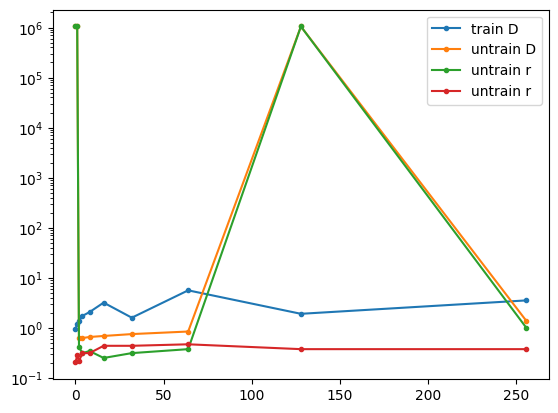

In [ ]:
imax = 10

indices_nonneg = [i % 4810 for i in indices][:imax]

plt.plot(indices_nonneg, train_diameters[:imax], '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters[:imax], '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:imax, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:imax, 0], '.-', label='untrain r')
plt.yscale('log')
plt.legend()
plt.show()

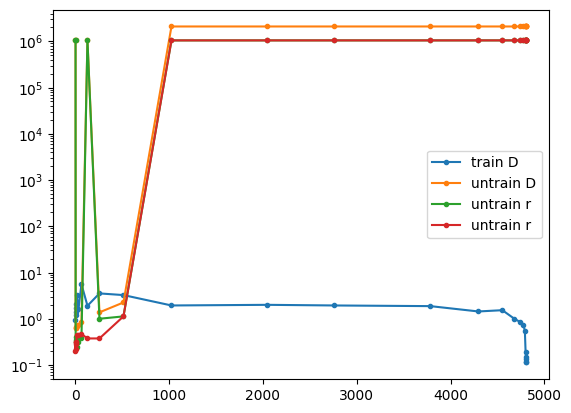

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.legend()
plt.show()

### Hessian untrain, init

In [ ]:
indices = 

In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final_untrain_radii = []
final_train_radii = []
final_untrain_neg_radii = []
final_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt.T @ (u.T @ evecs_untrain[:, i])

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final_untrain_diameters = jnp.array(final_untrain_radii)[:, 0] + jnp.array(final_untrain_neg_radii)[:, 0]
final_train_diameters = jnp.array(final_train_radii)[:, 0] + jnp.array(final_train_neg_radii)[:, 0]
final_untrain_deltas = (jnp.array(final_untrain_radii)[:, 1], jnp.array(final_untrain_neg_radii)[:, 1])
final_train_deltas = (jnp.array(final_train_radii)[:, 1], jnp.array(final_train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [11:39<00:00, 26.90s/it]


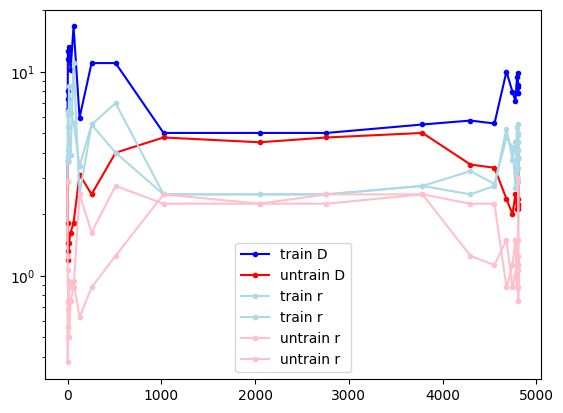

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:


min_radii = jnp.min(jnp.array([jnp.array(final_train_radii)[:, 0], jnp.array(final_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final_train_neg_radii)[:, 0], jnp.array(final_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final_logvols = logvol_estimate(indices, min_diameters)

2966.999


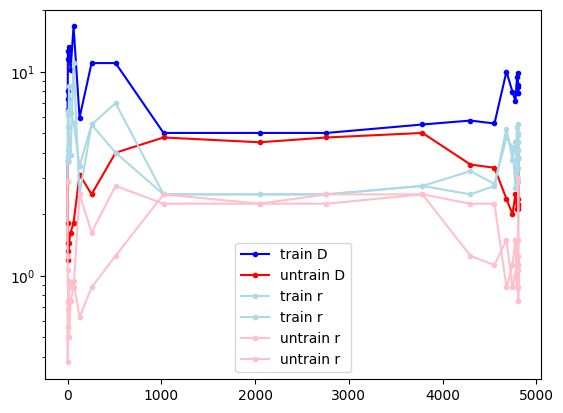

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.legend()
plt.show()

### Hessian train, final

In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = train_loss_fn
my_untrain_fn = lambda x: -untrain_loss_fn(x)

def direction(i):
    return evecs[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


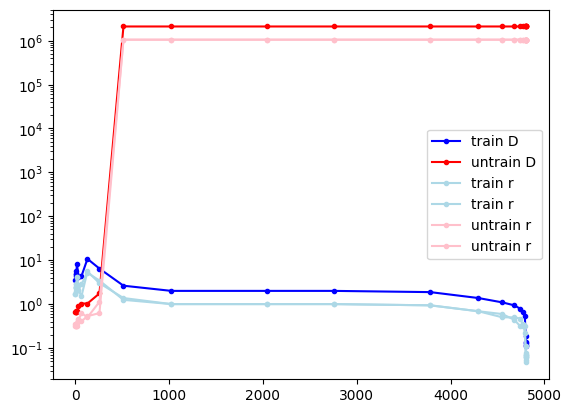

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.legend()
plt.show()

### Hessian train, init

In [ ]:
print(final_train_loss_fn(params_spher.raveled), final_untrain_loss_fn(params_spher.raveled))
print(final_train_loss_fn(params_rand.raveled), final_untrain_loss_fn(params_rand.raveled))

0.48644853 1.2963214
0.47886682 0.6379726


In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final4_untrain_radii = []
final4_train_radii = []
final4_untrain_neg_radii = []
final4_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt.T @ (u.T @ evecs[:, i])

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final4_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final4_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final4_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final4_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final4_untrain_diameters = jnp.array(final4_untrain_radii)[:, 0] + jnp.array(final4_untrain_neg_radii)[:, 0]
final4_train_diameters = jnp.array(final4_train_radii)[:, 0] + jnp.array(final4_train_neg_radii)[:, 0]
final4_untrain_deltas = (jnp.array(final4_untrain_radii)[:, 1], jnp.array(final4_untrain_neg_radii)[:, 1])
final4_train_deltas = (jnp.array(final4_train_radii)[:, 1], jnp.array(final4_train_neg_radii)[:, 1])


min_radii = jnp.min(jnp.array([jnp.array(final4_train_radii)[:, 0], jnp.array(final4_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final4_train_neg_radii)[:, 0], jnp.array(final4_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final4_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [13:01<00:00, 30.06s/it]


3065.897


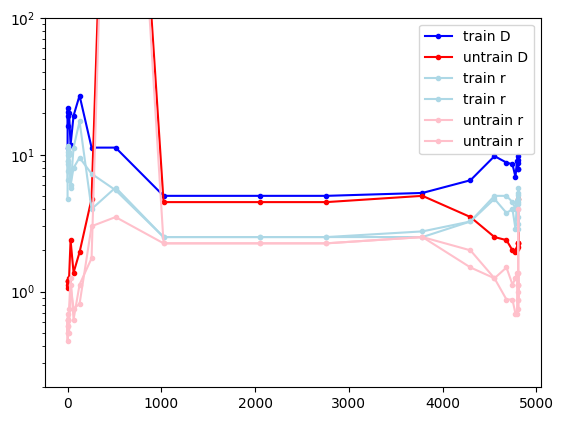

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final2_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

### JHJ train, init

In [ ]:
print(final_train_loss_fn(params_spher.raveled), final_untrain_loss_fn(params_spher.raveled))
print(final_train_loss_fn(params_rand.raveled), final_untrain_loss_fn(params_rand.raveled))

0.48644853 1.2963214
0.47886682 0.6379726


In [ ]:
JHJ = J_unorth.T @ H @ J_unorth


In [ ]:

evals_JHJ, evecs_JHJ = jnp.linalg.eigh(JHJ)

In [ ]:
def logvol_estimate(indices, diameters):
    indices_nonneg = jnp.array([i % 4810 for i in indices])
    sample_logvols = jnp.log10(jnp.array(diameters))

    vol_sum = 0

    lerp_logvols = jnp.interp(jnp.arange(4810), indices_nonneg, sample_logvols)

    print(jnp.sum(lerp_logvols))

    return lerp_logvols


In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final2_untrain_radii = []
final2_train_radii = []
final2_untrain_neg_radii = []
final2_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return evecs_JHJ[:, i]

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final2_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final2_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final2_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final2_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final2_untrain_diameters = jnp.array(final2_untrain_radii)[:, 0] + jnp.array(final2_untrain_neg_radii)[:, 0]
final2_train_diameters = jnp.array(final2_train_radii)[:, 0] + jnp.array(final2_train_neg_radii)[:, 0]
final2_untrain_deltas = (jnp.array(final2_untrain_radii)[:, 1], jnp.array(final2_untrain_neg_radii)[:, 1])
final2_train_deltas = (jnp.array(final2_train_radii)[:, 1], jnp.array(final2_train_neg_radii)[:, 1])


min_radii = jnp.min(jnp.array([jnp.array(final2_train_radii)[:, 0], jnp.array(final2_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final2_train_neg_radii)[:, 0], jnp.array(final2_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final2_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [12:19<00:00, 28.42s/it]


2863.0771


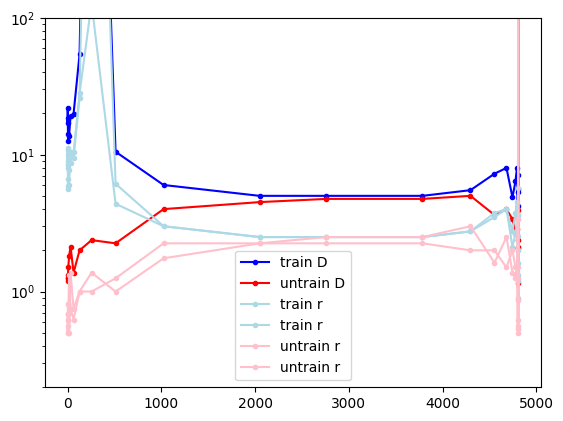

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final2_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

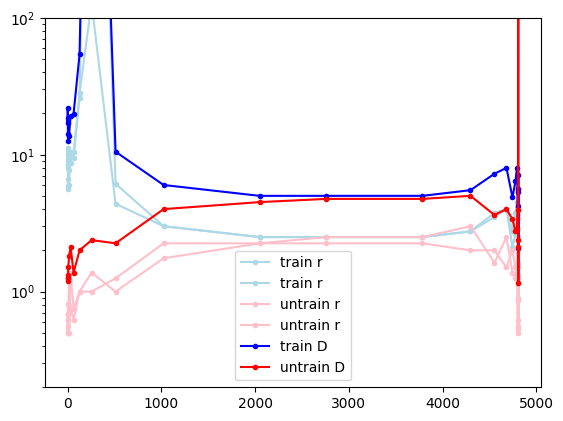

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, final2_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
#plt.xlim(4700, 4840)
plt.legend()
plt.show()

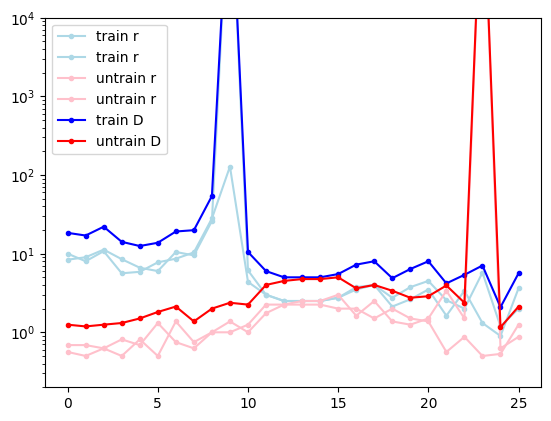

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(final2_train_diameters, '.-', label='train D', color='b')
plt.plot(final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.yscale('log')
plt.ylim(2e-1, 1e4)
#plt.xlim(4700, 4840)
plt.legend()
plt.show()

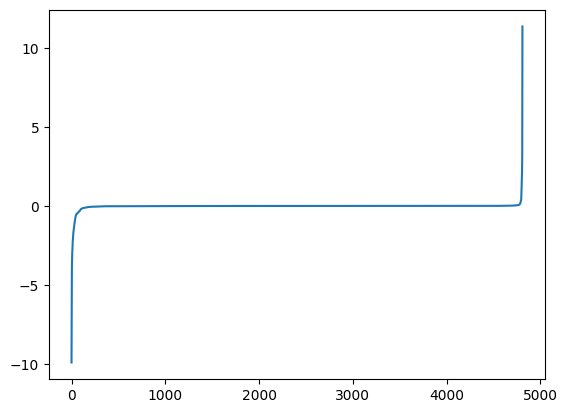

In [ ]:
plt.plot(evals_JHJ)
plt.show()

### SVD right, init

In [ ]:
print(final_train_loss_fn(params_spher.raveled), final_untrain_loss_fn(params_spher.raveled))
print(final_train_loss_fn(params_rand.raveled), final_untrain_loss_fn(params_rand.raveled))

0.48644853 1.2963214
0.47886682 0.6379726


In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final5_untrain_radii = []
final5_train_radii = []
final5_untrain_neg_radii = []
final5_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt[i]

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final5_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final5_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final5_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final5_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final5_untrain_diameters = jnp.array(final5_untrain_radii)[:, 0] + jnp.array(final5_untrain_neg_radii)[:, 0]
final5_train_diameters = jnp.array(final5_train_radii)[:, 0] + jnp.array(final5_train_neg_radii)[:, 0]
final5_untrain_deltas = (jnp.array(final5_untrain_radii)[:, 1], jnp.array(final5_untrain_neg_radii)[:, 1])
final5_train_deltas = (jnp.array(final5_train_radii)[:, 1], jnp.array(final5_train_neg_radii)[:, 1])


min_radii = jnp.min(jnp.array([jnp.array(final5_train_radii)[:, 0], jnp.array(final5_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final5_train_neg_radii)[:, 0], jnp.array(final5_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final5_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [11:34<00:00, 26.71s/it]


2728.4182


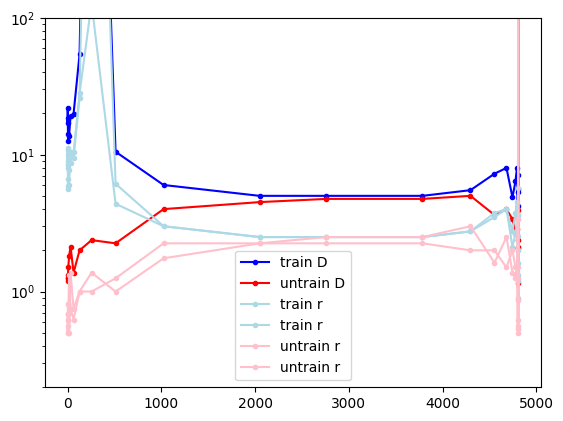

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final5_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final5_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final5_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final5_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final5_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final5_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

### Chained H train, init

In [ ]:
final_train_loss_fn(params_spher.raveled)

Array(0.48644853, dtype=float32)

In [ ]:
init_hess_fn = jax.hessian(final_train_loss_fn)
H_init = init_hess_fn(params_spher.raveled)

2024-09-30 23:53:51.684439: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 88.26MiB (rounded to 92544512)requested by op 
2024-09-30 23:53:51.685377: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ****************************************************************************************************
E0930 23:53:51.685423 1843673 pjrt_stream_executor_client.cc:3067] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 92544400 bytes.


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 92544400 bytes.

In [ ]:

evals_H_init, evecs_H_init = jnp.linalg.eigh(H_init)

In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final3_untrain_radii = []
final3_train_radii = []
final3_untrain_neg_radii = []
final3_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return evecs_JHJ[:, i]

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final3_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final3_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final3_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final3_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final3_untrain_diameters = jnp.array(final3_untrain_radii)[:, 0] + jnp.array(final3_untrain_neg_radii)[:, 0]
final3_train_diameters = jnp.array(final3_train_radii)[:, 0] + jnp.array(final3_train_neg_radii)[:, 0]
final3_untrain_deltas = (jnp.array(final3_untrain_radii)[:, 1], jnp.array(final3_untrain_neg_radii)[:, 1])
final3_train_deltas = (jnp.array(final3_train_radii)[:, 1], jnp.array(final3_train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [11:37<00:00, 26.84s/it]


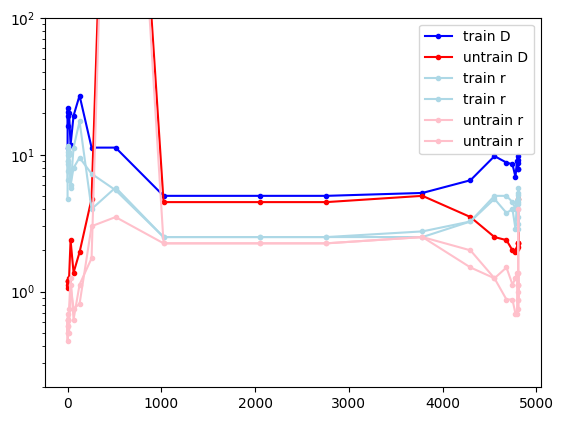

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final3_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final3_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final3_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final3_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final3_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final3_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

## Experiments 09-30

### Hessian untrain, final

In [92]:
final_dataset_loss(params_spher.raveled, X_train, Y_train)

Array(0.48644853, dtype=float32)

In [93]:
.5 - _92

Array(0.01355147, dtype=float32)

In [150]:
vec = jax.random.normal(jax.random.PRNGKey(69420), shape=params_spher.raveled.shape)
vec = vec / jnp.linalg.norm(vec)
print(find_radius(params_final_rav, vec, 1e-2, rtol=0.1, init_mult=1, fn=train_loss_fn, iters=20, jump=2))
print(find_radius(params_final_rav, vec, 1e-2, rtol=0.1, init_mult=1, fn=lambda x: -untrain_loss_fn(x), iters=20, jump=2))

(0.75, Array(0.01037356, dtype=float32))
(1048576.0, Array(-1.0500132, dtype=float32))


In [152]:
jnp.log10(2 * .75) * 4810

Array(846.9989, dtype=float32)

In [146]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = train_loss_fn
my_untrain_fn = lambda x: -untrain_loss_fn(x)

def direction(i):
    return evecs_untrain[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])


min_radii = jnp.min(jnp.array([jnp.array(train_radii)[:, 0], jnp.array(untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(train_neg_radii)[:, 0], jnp.array(untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
huntrain_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]
1177.7036


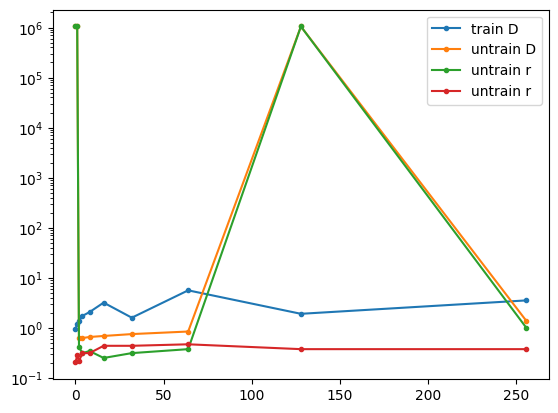

In [95]:
imax = 10

indices_nonneg = [i % 4810 for i in indices][:imax]

plt.plot(indices_nonneg, train_diameters[:imax], '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters[:imax], '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:imax, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:imax, 0], '.-', label='untrain r')
plt.yscale('log')
plt.legend()
plt.show()

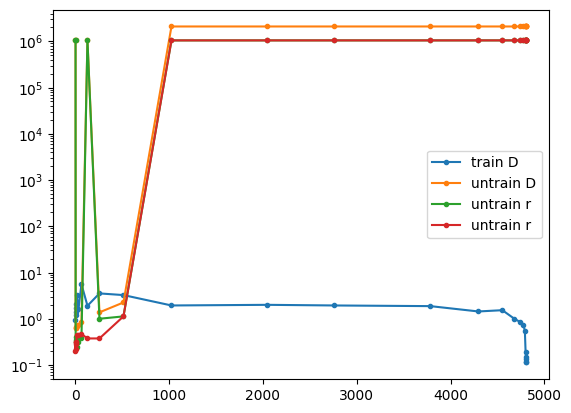

In [96]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.legend()
plt.show()

### Hessian untrain, init

In [ ]:
indices = 

In [97]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final_untrain_radii = []
final_train_radii = []
final_untrain_neg_radii = []
final_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

my_params = params_final_rav  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!

my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt.T @ (u.T @ evecs_untrain[:, i])

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final_untrain_radii.append(find_radius(my_params, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_radii.append(find_radius(my_params, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final_untrain_neg_radii.append(find_radius(my_params, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_neg_radii.append(find_radius(my_params, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final_untrain_diameters = jnp.array(final_untrain_radii)[:, 0] + jnp.array(final_untrain_neg_radii)[:, 0]
final_train_diameters = jnp.array(final_train_radii)[:, 0] + jnp.array(final_train_neg_radii)[:, 0]
final_untrain_deltas = (jnp.array(final_untrain_radii)[:, 1], jnp.array(final_untrain_neg_radii)[:, 1])
final_train_deltas = (jnp.array(final_train_radii)[:, 1], jnp.array(final_train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [11:39<00:00, 26.90s/it]


In [208]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final_untrain_radii = []
final_train_radii = []
final_untrain_neg_radii = []
final_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

my_params = params_spher.raveled  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!

my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt.T @ (u.T @ evecs_untrain[:, i])

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final_untrain_radii.append(find_radius(my_params, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_radii.append(find_radius(my_params, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final_untrain_neg_radii.append(find_radius(my_params, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_neg_radii.append(find_radius(my_params, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))

min_radii = jnp.min(jnp.array([jnp.array(final_train_radii)[:, 0], jnp.array(final_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final_train_neg_radii)[:, 0], jnp.array(final_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final_logvols = logvol_estimate(indices, min_diameters)

final_untrain_diameters = jnp.array(final_untrain_radii)[:, 0] + jnp.array(final_untrain_neg_radii)[:, 0]
final_train_diameters = jnp.array(final_train_radii)[:, 0] + jnp.array(final_train_neg_radii)[:, 0]
final_untrain_deltas = (jnp.array(final_untrain_radii)[:, 1], jnp.array(final_untrain_neg_radii)[:, 1])
final_train_deltas = (jnp.array(final_train_radii)[:, 1], jnp.array(final_train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [18:26<00:00, 42.56s/it]


805.2612


In [192]:
from functools import partial

In [206]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(11)).tolist() + list(reversed((-(2 ** jnp.arange(11) + 1)).tolist())) + [-1]
print(indices)

final_untrain_radii = []
final_train_radii = []
final_untrain_neg_radii = []
final_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

my_params = params_spher.raveled

my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt.T @ (u.T @ evecs_untrain[:, i])

indices_jnp = jnp.array(indices)

#@partial(jax.vmap, in_axes=(0,))
def find_radius_single(i):
    print(i.shape)
    i = i.reshape([])
    print(i.shape)
    vec = Jgen_direction(i)
    #print(vec.shape, my_params.shape)
    final_untrain_radius = (find_radius(my_params, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                    fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_radius = (find_radius(my_params, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                fn=my_train_fn, iters=train_iters, jump=jump))
    final_untrain_neg_radius = (find_radius(my_params, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final_train_neg_radius = (find_radius(my_params, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                    fn=my_train_fn, iters=train_iters, jump=jump))

    return jnp.array([final_untrain_radius, final_train_radius, final_untrain_neg_radius, final_train_neg_radius])

@jax.pmap
def find_radius_batch(my_indices):
    print(my_indices)
    return jnp.array([find_radius_single(i) for i in my_indices])

# final_untrain_diameters = jnp.array(final_untrain_radii)[:, 0] + jnp.array(final_untrain_neg_radii)[:, 0]
# final_train_diameters = jnp.array(final_train_radii)[:, 0] + jnp.array(final_train_neg_radii)[:, 0]
# final_untrain_deltas = (jnp.array(final_untrain_radii)[:, 1], jnp.array(final_untrain_neg_radii)[:, 1])
# final_train_deltas = (jnp.array(final_train_radii)[:, 1], jnp.array(final_train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


In [187]:
Jgen_direction(3).shape

(4810,)

In [207]:
indices_batched = indices_jnp.reshape(8, 3, 1)
print(indices_batched)

my_radii = find_radius_batch(indices_batched)

[[[    0]
  [    1]
  [    2]]

 [[    4]
  [    8]
  [   16]]

 [[   32]
  [   64]
  [  128]]

 [[  256]
  [  512]
  [ 1024]]

 [[-1025]
  [ -513]
  [ -257]]

 [[ -129]
  [  -65]
  [  -33]]

 [[  -17]
  [   -9]
  [   -5]]

 [[   -3]
  [   -2]
  [   -1]]]
Traced<ShapedArray(int32[3,1])>with<DynamicJaxprTrace(level=0/1)>
(1,)
()


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function find_radius_batch at /tmp/ipykernel_1843673/3154615543.py:47 for pmap. This concrete value was not available in Python because it depends on the value of the argument my_indices.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

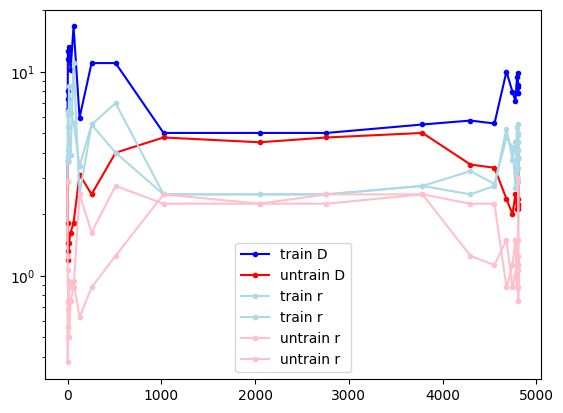

In [139]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.legend()
plt.show()

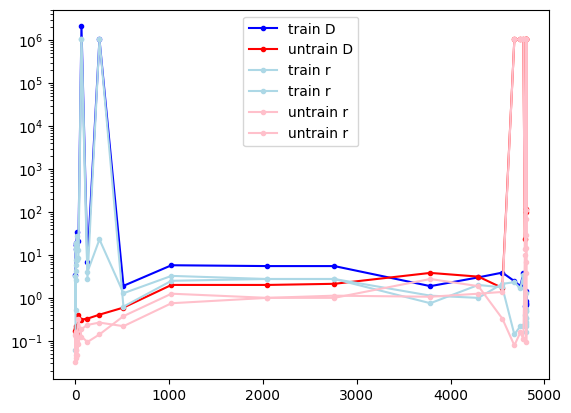

In [209]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.legend()
plt.show()

In [140]:


min_radii = jnp.min(jnp.array([jnp.array(final_train_radii)[:, 0], jnp.array(final_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final_train_neg_radii)[:, 0], jnp.array(final_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final_logvols = logvol_estimate(indices, min_diameters)

2966.999


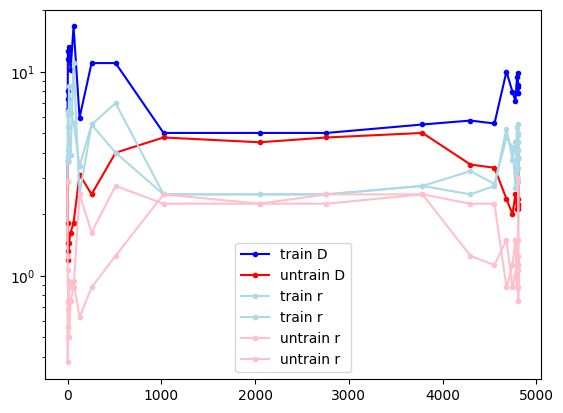

In [102]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.legend()
plt.show()

### Hessian train, final

In [147]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = train_loss_fn
my_untrain_fn = lambda x: -untrain_loss_fn(x)

def direction(i):
    return u[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

min_radii = jnp.min(jnp.array([jnp.array(train_radii)[:, 0], jnp.array(untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(train_neg_radii)[:, 0], jnp.array(untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
svd_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]
1083.6289


In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = train_loss_fn
my_untrain_fn = lambda x: -untrain_loss_fn(x)

def direction(i):
    return evecs[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

min_radii = jnp.min(jnp.array([jnp.array(train_radii)[:, 0], jnp.array(untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(train_neg_radii)[:, 0], jnp.array(untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
htrain_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]
1202.9749


In [212]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

my_params = params_final_rav
for _ in range(2):
    my_params = train_fn(my_params)

my_train_fn = train_loss_fn
my_untrain_fn = lambda x: -untrain_loss_fn(x)

def direction(i):
    return evecs[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(my_params, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(my_params, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(my_params, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(my_params, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

min_radii = jnp.min(jnp.array([jnp.array(train_radii)[:, 0], jnp.array(untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(train_neg_radii)[:, 0], jnp.array(untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
htrain_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]
1975.4175


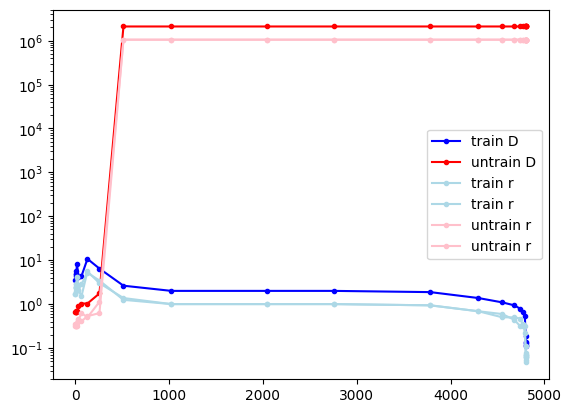

In [104]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.legend()
plt.show()

### Hessian train, init

In [111]:
print(final_train_loss_fn(params_spher.raveled), final_untrain_loss_fn(params_spher.raveled))
print(final_train_loss_fn(params_rand.raveled), final_untrain_loss_fn(params_rand.raveled))

0.48644853 1.2963214
0.47886682 0.6379726


In [222]:
init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

radii_rand = []
radii_spher = []
for seedval in range(10):
    vec = jax.random.normal(jax.random.PRNGKey(69420+seedval), (4810,))
    vec = vec / jnp.linalg.norm(vec)
    rad_untrain = find_radius(params_spher.raveled, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_untrain_fn, iters=untrain_iters, jump=jump)
    rad_train = find_radius(params_spher.raveled, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump)   
    rad = min(rad_untrain[0], rad_train[0])
    radii_spher.append(rad)
    rad_untrain = find_radius(params_rand.raveled, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_untrain_fn, iters=untrain_iters, jump=jump)
    rad_train = find_radius(params_rand.raveled, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_train_fn, iters=train_iters, jump=jump)
    rad = min(rad_untrain[0], rad_train[0])
    radii_rand.append(rad)

print(jnp.log10(2 * jnp.array(radii_spher)).mean() * 4810)
print(jnp.log10(2 * jnp.array(radii_spher)).std() * 4810)
print(jnp.log10(2 * jnp.array(radii_rand)).mean() * 4810)
print(jnp.log10(2 * jnp.array(radii_rand)).std() * 4810)

-242.63797
987.6247
8020.962
7972.3823


In [226]:

print(jnp.log10(2 * jnp.array(radii_spher)).mean() * 4810)
print(jnp.log10(2 * jnp.array(radii_spher)).std() * 4810 / jnp.sqrt(10))
print(jnp.log10(2 * jnp.array(radii_rand)).mean() * 4810)
print(jnp.log10(2 * jnp.array(radii_rand)).std() * 4810 / jnp.sqrt(10))

-242.63797
312.31436
8020.962
2521.0886


In [225]:
jnp.log10(2 * jnp.array(radii_spher)) * 4810

Array([  665.2359 ,  1381.6326 ,   665.2359 , -1447.9542 , -1447.9542 ,
        -278.94125, -1447.9542 ,  -981.8171 ,     0.     ,   466.13715],      dtype=float32)

In [223]:
init_mult = 1
rtol = 0.02
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

radii_rand = []
radii_spher = []
for seedval in range(10):
    vec = jax.random.normal(jax.random.PRNGKey(69420+seedval), (4810,))
    vec = vec / jnp.linalg.norm(vec)
    rad_untrain = find_radius(params_spher.raveled, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_untrain_fn, iters=untrain_iters, jump=jump)
    rad_train = find_radius(params_spher.raveled, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump)   
    rad = min(rad_untrain[0], rad_train[0])
    radii_spher.append(rad)
    rad_untrain = find_radius(params_rand.raveled, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_untrain_fn, iters=untrain_iters, jump=jump)
    rad_train = find_radius(params_rand.raveled, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_train_fn, iters=train_iters, jump=jump)
    rad = min(rad_untrain[0], rad_train[0])
    radii_rand.append(rad)

print(jnp.log10(2 * jnp.array(radii_spher)).mean() * 4810)
print(jnp.log10(2 * jnp.array(radii_spher)).std() * 4810)
print(jnp.log10(2 * jnp.array(radii_rand)).mean() * 4810)
print(jnp.log10(2 * jnp.array(radii_rand)).std() * 4810)

-242.63797
987.6247
8020.962
7972.3823


In [216]:
jnp.log10(2 * 0.96875) * 4810

Array(1381.6326, dtype=float32)

In [220]:
jnp.log10(2 * 0.6875) * 4810

Array(665.2359, dtype=float32)

In [221]:
jnp.log10(2 * 3.) * 4810

Array(3742.9072, dtype=float32)

In [138]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final4_untrain_radii = []
final4_train_radii = []
final4_untrain_neg_radii = []
final4_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt.T @ (u.T @ evecs[:, i])

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final4_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final4_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final4_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final4_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final4_untrain_diameters = jnp.array(final4_untrain_radii)[:, 0] + jnp.array(final4_untrain_neg_radii)[:, 0]
final4_train_diameters = jnp.array(final4_train_radii)[:, 0] + jnp.array(final4_train_neg_radii)[:, 0]
final4_untrain_deltas = (jnp.array(final4_untrain_radii)[:, 1], jnp.array(final4_untrain_neg_radii)[:, 1])
final4_train_deltas = (jnp.array(final4_train_radii)[:, 1], jnp.array(final4_train_neg_radii)[:, 1])


min_radii = jnp.min(jnp.array([jnp.array(final4_train_radii)[:, 0], jnp.array(final4_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final4_train_neg_radii)[:, 0], jnp.array(final4_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final4_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [13:01<00:00, 30.06s/it]


3065.897


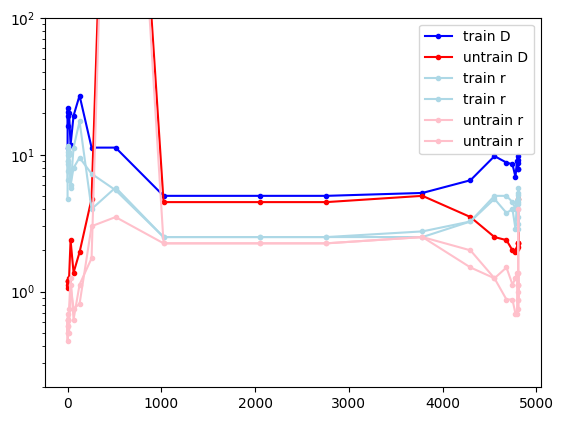

In [112]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final2_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

### JHJ train, init

In [ ]:
print(final_train_loss_fn(params_spher.raveled), final_untrain_loss_fn(params_spher.raveled))
print(final_train_loss_fn(params_rand.raveled), final_untrain_loss_fn(params_rand.raveled))

0.48644853 1.2963214
0.47886682 0.6379726


In [113]:
JHJ = J_unorth.T @ H @ J_unorth


In [114]:

evals_JHJ, evecs_JHJ = jnp.linalg.eigh(JHJ)

In [131]:
def logvol_estimate(indices, diameters):
    indices_nonneg = jnp.array([i % 4810 for i in indices])
    sample_logvols = jnp.log10(jnp.array(diameters))

    vol_sum = 0

    lerp_logvols = jnp.interp(jnp.arange(4810), indices_nonneg, sample_logvols)

    print(jnp.sum(lerp_logvols))

    return lerp_logvols


In [136]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final2_untrain_radii = []
final2_train_radii = []
final2_untrain_neg_radii = []
final2_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return evecs_JHJ[:, i]

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final2_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final2_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final2_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final2_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final2_untrain_diameters = jnp.array(final2_untrain_radii)[:, 0] + jnp.array(final2_untrain_neg_radii)[:, 0]
final2_train_diameters = jnp.array(final2_train_radii)[:, 0] + jnp.array(final2_train_neg_radii)[:, 0]
final2_untrain_deltas = (jnp.array(final2_untrain_radii)[:, 1], jnp.array(final2_untrain_neg_radii)[:, 1])
final2_train_deltas = (jnp.array(final2_train_radii)[:, 1], jnp.array(final2_train_neg_radii)[:, 1])


min_radii = jnp.min(jnp.array([jnp.array(final2_train_radii)[:, 0], jnp.array(final2_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final2_train_neg_radii)[:, 0], jnp.array(final2_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final2_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [12:19<00:00, 28.42s/it]


2863.0771


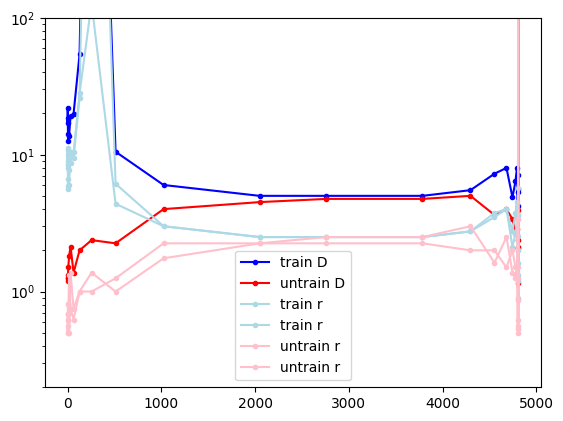

In [116]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final2_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

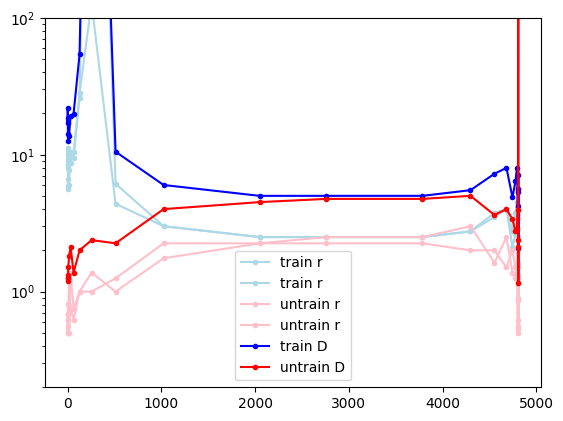

In [121]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, final2_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
#plt.xlim(4700, 4840)
plt.legend()
plt.show()

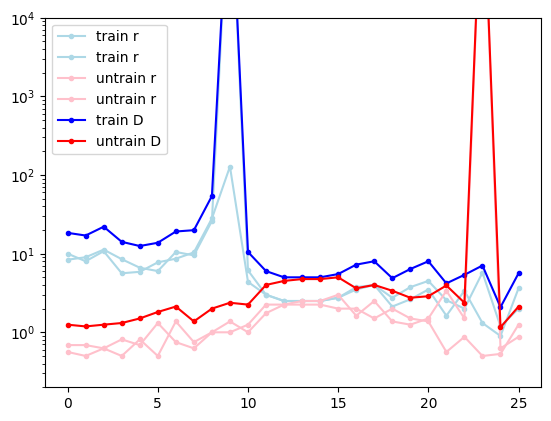

In [123]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(jnp.array(final2_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(jnp.array(final2_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(jnp.array(final2_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(jnp.array(final2_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(final2_train_diameters, '.-', label='train D', color='b')
plt.plot(final2_untrain_diameters, '.-', label='untrain D', color='r')
plt.yscale('log')
plt.ylim(2e-1, 1e4)
#plt.xlim(4700, 4840)
plt.legend()
plt.show()

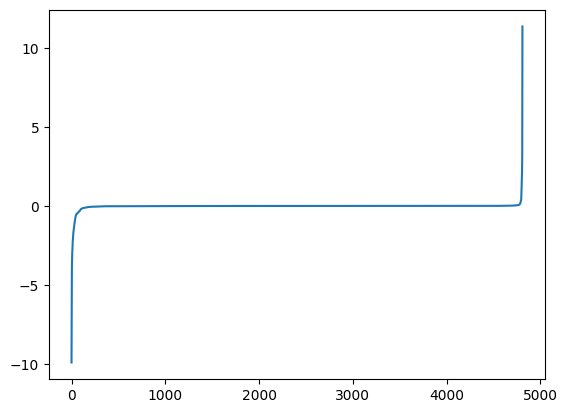

In [126]:
plt.plot(evals_JHJ)
plt.show()

### SVD right, init

In [ ]:
print(final_train_loss_fn(params_spher.raveled), final_untrain_loss_fn(params_spher.raveled))
print(final_train_loss_fn(params_rand.raveled), final_untrain_loss_fn(params_rand.raveled))

0.48644853 1.2963214
0.47886682 0.6379726


In [141]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final5_untrain_radii = []
final5_train_radii = []
final5_untrain_neg_radii = []
final5_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return vt[i]

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final5_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final5_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final5_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final5_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final5_untrain_diameters = jnp.array(final5_untrain_radii)[:, 0] + jnp.array(final5_untrain_neg_radii)[:, 0]
final5_train_diameters = jnp.array(final5_train_radii)[:, 0] + jnp.array(final5_train_neg_radii)[:, 0]
final5_untrain_deltas = (jnp.array(final5_untrain_radii)[:, 1], jnp.array(final5_untrain_neg_radii)[:, 1])
final5_train_deltas = (jnp.array(final5_train_radii)[:, 1], jnp.array(final5_train_neg_radii)[:, 1])


min_radii = jnp.min(jnp.array([jnp.array(final5_train_radii)[:, 0], jnp.array(final5_untrain_radii)[:, 0]]), axis=0)
min_neg_radii = jnp.min(jnp.array([jnp.array(final5_train_neg_radii)[:, 0], jnp.array(final5_untrain_neg_radii)[:, 0]]), axis=0)
min_diameters = min_radii + min_neg_radii
final5_logvols = logvol_estimate(indices, min_diameters)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [11:34<00:00, 26.71s/it]


2728.4182


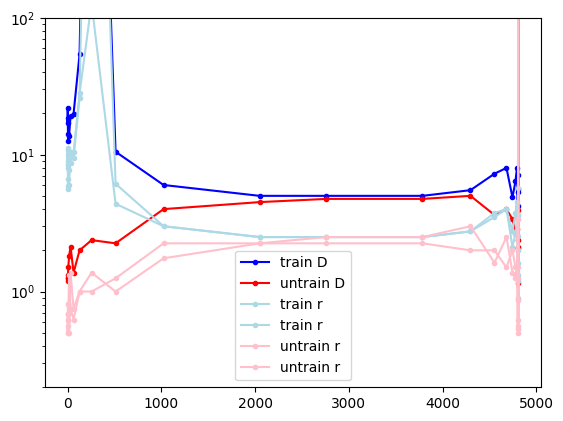

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final5_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final5_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final5_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final5_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final5_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final5_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

### Chained H train, init

In [127]:
final_train_loss_fn(params_spher.raveled)

Array(0.48644853, dtype=float32)

In [129]:
init_hess_fn = jax.hessian(final_train_loss_fn)
H_init = init_hess_fn(params_spher.raveled)

2024-09-30 23:53:51.684439: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 88.26MiB (rounded to 92544512)requested by op 
2024-09-30 23:53:51.685377: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ****************************************************************************************************
E0930 23:53:51.685423 1843673 pjrt_stream_executor_client.cc:3067] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 92544400 bytes.


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 92544400 bytes.

In [ ]:

evals_H_init, evecs_H_init = jnp.linalg.eigh(H_init)

In [ ]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

final3_untrain_radii = []
final3_train_radii = []
final3_untrain_neg_radii = []
final3_train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = lambda x: -final_untrain_loss_fn(x)

def Jgen_direction(i):
    return evecs_JHJ[:, i]

for i in tqdm(indices):
    vec = Jgen_direction(i)
    final3_untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final3_train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    final3_untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    final3_train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
final3_untrain_diameters = jnp.array(final3_untrain_radii)[:, 0] + jnp.array(final3_untrain_neg_radii)[:, 0]
final3_train_diameters = jnp.array(final3_train_radii)[:, 0] + jnp.array(final3_train_neg_radii)[:, 0]
final3_untrain_deltas = (jnp.array(final3_untrain_radii)[:, 1], jnp.array(final3_untrain_neg_radii)[:, 1])
final3_train_deltas = (jnp.array(final3_train_radii)[:, 1], jnp.array(final3_train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


100%|██████████| 26/26 [11:37<00:00, 26.84s/it]


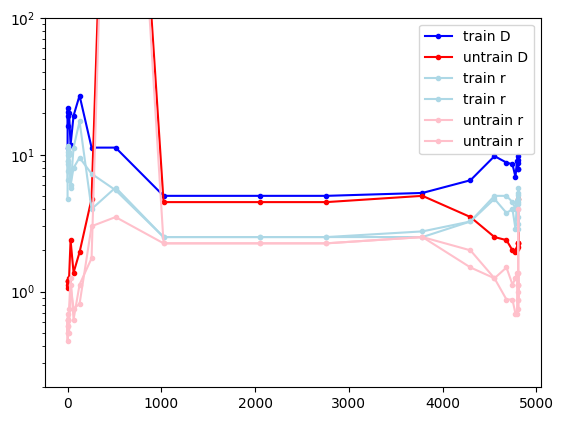

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, final3_train_diameters, '.-', label='train D', color='b')
plt.plot(indices_nonneg, final3_untrain_diameters, '.-', label='untrain D', color='r')
plt.plot(indices_nonneg, jnp.array(final3_train_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final3_train_neg_radii)[:, 0], '.-', label='train r', color='lightblue')
plt.plot(indices_nonneg, jnp.array(final3_untrain_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.plot(indices_nonneg, jnp.array(final3_untrain_neg_radii)[:, 0], '.-', label='untrain r', color='pink')
plt.yscale('log')
plt.ylim(2e-1, 1e2)
plt.legend()
plt.show()

## Experiments 09-27

### Poison basin


#### Hessian

In [148]:
indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 10).astype(int)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.03
train_cutoff = 1e-3
untrain_cutoff = 1e-8
jump = 1.2
train_iters = 5
untrain_iters = 15

def direction(i):
    return evecs[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=train_loss_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=train_loss_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = jnp.array(untrain_radii)[:, 1] + jnp.array(untrain_neg_radii)[:, 1]
train_deltas = jnp.array(train_radii)[:, 1] + jnp.array(train_neg_radii)[:, 1]

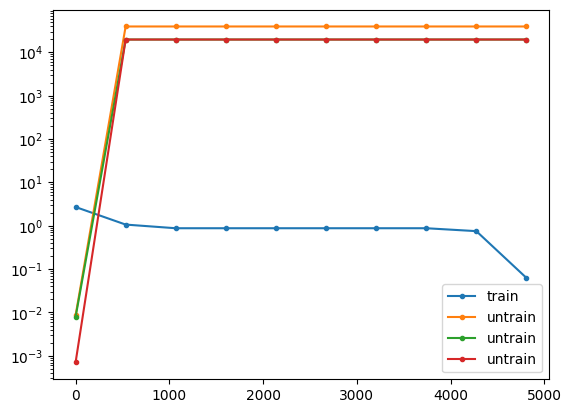

In [126]:
plt.plot(indices, train_diameters, '.-', label='train')
plt.plot(indices, untrain_diameters, '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_radii)[:, 0], '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

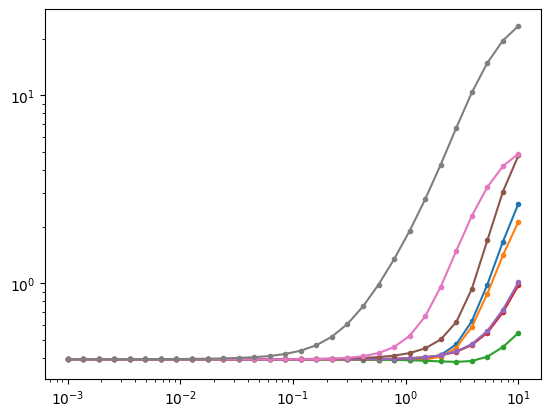

In [147]:
mults = 10**jnp.linspace(-3, 1, 30)



for i in [0, 10, 100, 1000, -1000, -100, -10, -1]:
    untrain_losses = []
    train_losses = []
    for mult in mults:
        untrain_losses.append(untrain_loss_fn(params_final_rav + mult * evecs[:, i]))
        train_losses.append(train_loss_fn(params_final_rav + mult * evecs[:, i]))

    untrain_losses = jnp.array(untrain_losses)
    train_losses = jnp.array(train_losses)

    plt.plot(mults, -untrain_losses, '.-', label='untrain')
    #plt.plot(mults, train_losses, '.-', label='train')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [181]:
indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

def h_direction(i):
    return evecs[:, i]

for i in indices:
    vec = h_direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=train_loss_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=train_loss_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

In [182]:
min_diameters = jnp.min(jnp.array([train_diameters, untrain_diameters]), axis=0)
logvol = jnp.sum(jnp.log10(min_diameters))

print(logvol)

42.0815


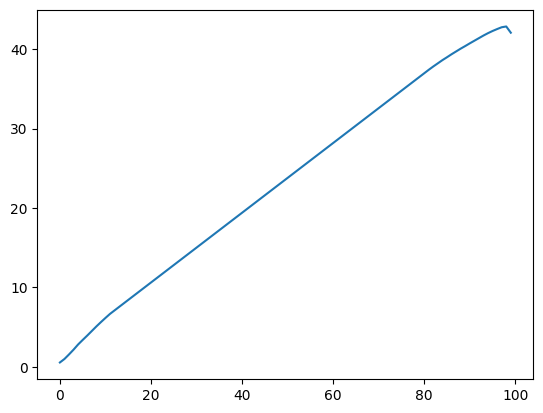

In [192]:
plt.plot(jnp.cumsum(jnp.log10(min_diameters)))

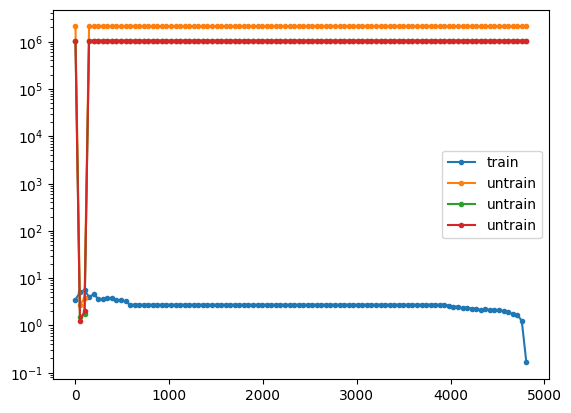

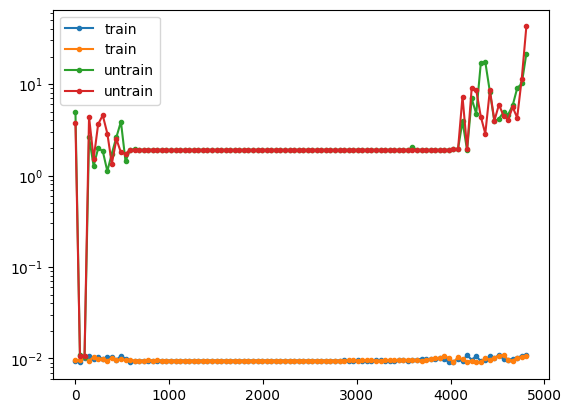

In [183]:
plt.plot(indices, train_diameters, '.-', label='train')
plt.plot(indices, untrain_diameters, '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_radii)[:, 0], '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(indices, jnp.abs(train_deltas[0]), '.-', label='train')
plt.plot(indices, jnp.abs(train_deltas[1]), '.-', label='train')
plt.plot(indices, jnp.abs(untrain_deltas[0]), '.-', label='untrain')
plt.plot(indices, jnp.abs(untrain_deltas[1]), '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

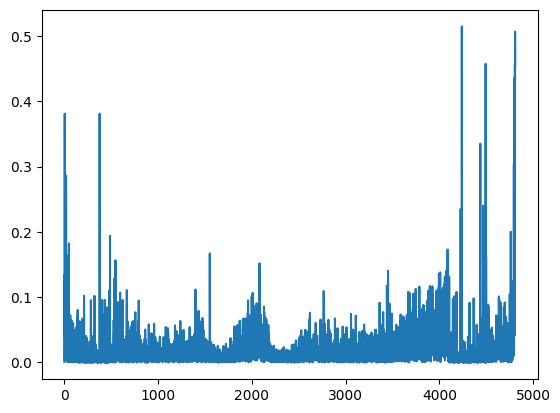

In [180]:
cosines = jnp.abs(jnp.diag(evecs.T @ u))
plt.plot(cosines)
plt.show()

#### Hessian (generalization)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


In [243]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = train_loss_fn
my_untrain_fn = generalization_fn

def direction(i):
    return evecs_gen[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


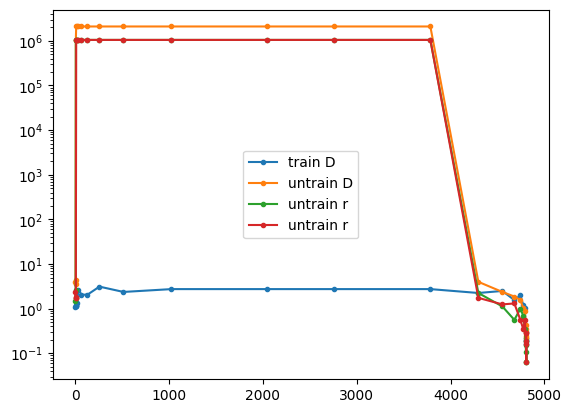

In [245]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.legend()
plt.show()

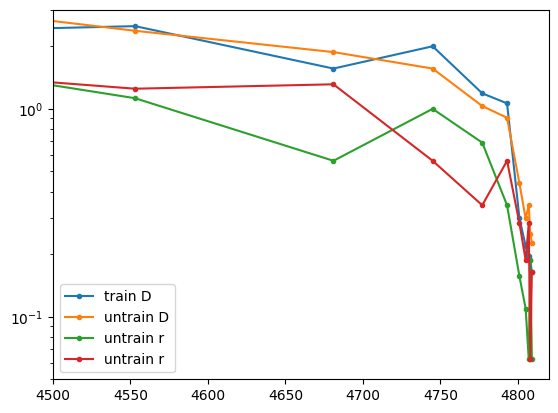

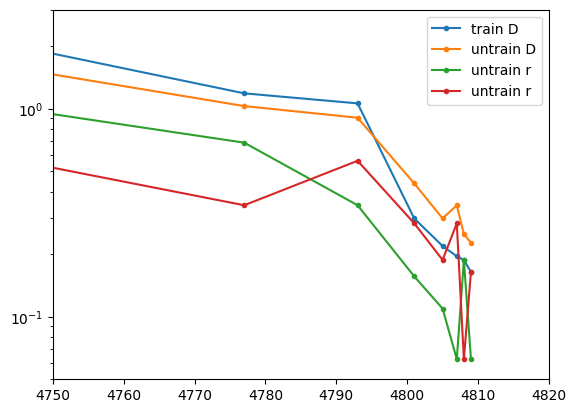

In [260]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.xlim(4500, 4820)
plt.ylim(5e-2, 3)
plt.legend()
plt.show()
plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.xlim(4750, 4820)
plt.ylim(5e-2, 3)
plt.legend()
plt.show()

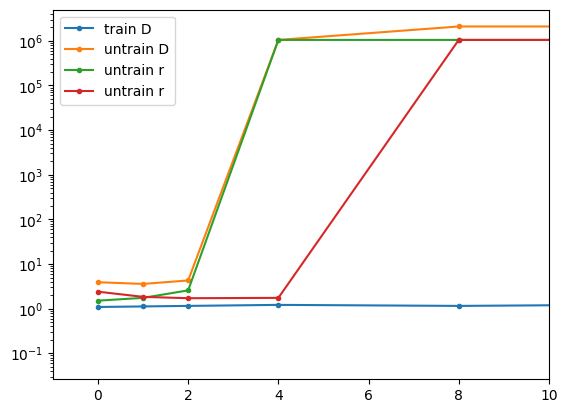

In [256]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.xlim(-1, 10)
#plt.ylim(5e-2, 3)
plt.legend()
plt.show()

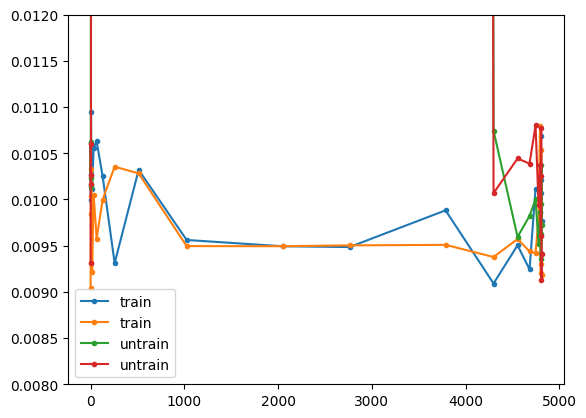

In [259]:

plt.plot(indices_nonneg, jnp.abs(train_deltas[0]), '.-', label='train')
plt.plot(indices_nonneg, jnp.abs(train_deltas[1]), '.-', label='train')
plt.plot(indices_nonneg, jnp.abs(untrain_deltas[0]), '.-', label='untrain')
plt.plot(indices_nonneg, jnp.abs(untrain_deltas[1]), '.-', label='untrain')
#plt.yscale('log')
plt.ylim(.008, .012)
plt.legend()
plt.show()

#### Hessian(untrain)

In [221]:
indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 10).astype(int)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = train_loss_fn
my_untrain_fn = generalization_fn

def direction(i):
    return evecs_untrain[:, i]

for i in indices:
    vec = direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

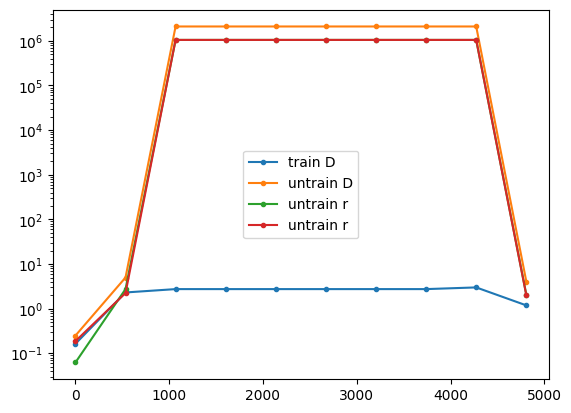

In [225]:
plt.plot(indices, train_diameters, '.-', label='train D')
plt.plot(indices, untrain_diameters, '.-', label='untrain D')
plt.plot(indices, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.legend()
plt.show()

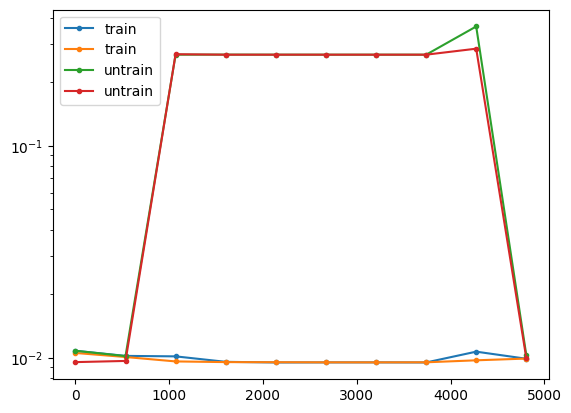

In [223]:

plt.plot(indices, jnp.abs(train_deltas[0]), '.-', label='train')
plt.plot(indices, jnp.abs(train_deltas[1]), '.-', label='train')
plt.plot(indices, jnp.abs(untrain_deltas[0]), '.-', label='untrain')
plt.plot(indices, jnp.abs(untrain_deltas[1]), '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

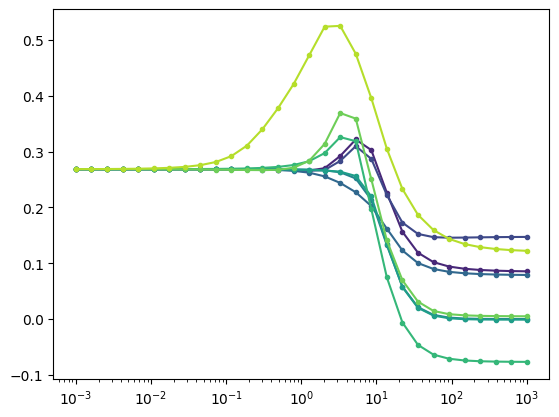

In [263]:
mults = 10**jnp.linspace(-3, 3, 30)


nnn = 0
for i in [0, 10, 100, 1000, -1000, -100, -10, -1]:
    nnn += 1
    untrain_losses = []
    train_losses = []
    generalization_losses = []
    for mult in mults:
        untrain_losses.append(untrain_loss_fn(params_final_rav + mult * evecs[:, i]))
        train_losses.append(train_loss_fn(params_final_rav + mult * evecs[:, i]))
        generalization_losses.append(generalization_fn(params_final_rav + mult * evecs[:, i]))
    untrain_losses = jnp.array(untrain_losses)
    train_losses = jnp.array(train_losses)

    # color changes smoothly as a function of i
    #plt.plot(mults, train_losses + untrain_losses, '.-', color = plt.cm.viridis(nnn / 9))
    plt.plot(mults, generalization_losses, '.-', color = plt.cm.viridis(nnn / 9))
    #plt.plot(mults, train_losses, '.-')
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [ ]:
indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

def h_direction(i):
    return evecs[:, i]

for i in indices:
    vec = h_direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=train_loss_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=train_loss_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

In [ ]:
min_diameters = jnp.min(jnp.array([train_diameters, untrain_diameters]), axis=0)
logvol = jnp.sum(jnp.log10(min_diameters))

print(logvol)

42.0815


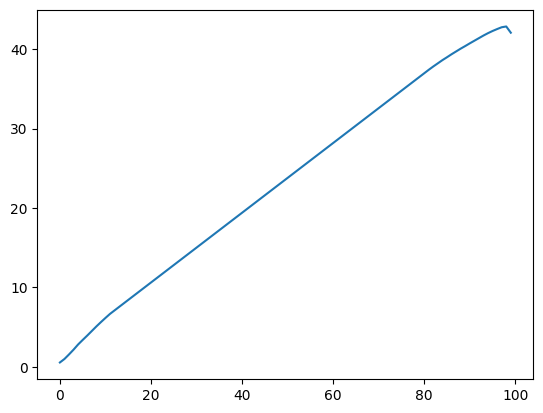

In [ ]:
plt.plot(jnp.cumsum(jnp.log10(min_diameters)))

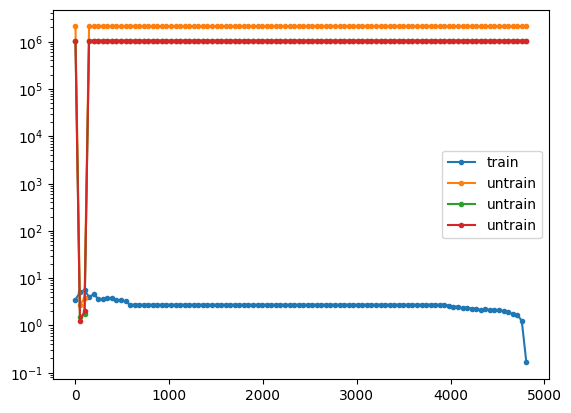

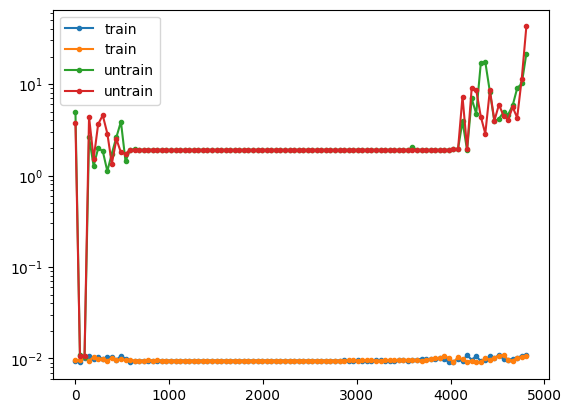

In [ ]:
plt.plot(indices, train_diameters, '.-', label='train')
plt.plot(indices, untrain_diameters, '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_radii)[:, 0], '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(indices, jnp.abs(train_deltas[0]), '.-', label='train')
plt.plot(indices, jnp.abs(train_deltas[1]), '.-', label='train')
plt.plot(indices, jnp.abs(untrain_deltas[0]), '.-', label='untrain')
plt.plot(indices, jnp.abs(untrain_deltas[1]), '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

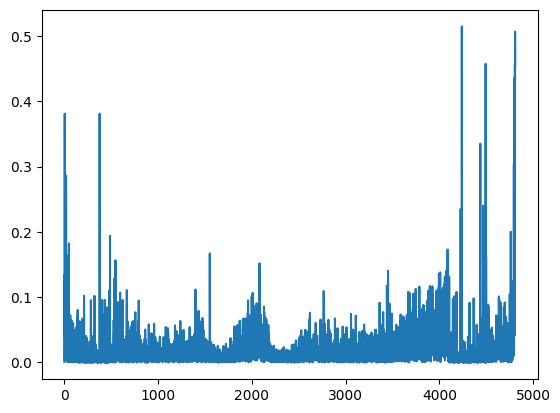

In [ ]:
cosines = jnp.abs(jnp.diag(evecs.T @ u))
plt.plot(cosines)
plt.show()

#### Left SV

In [166]:
final_train_loss, final_untrain_loss

(Array(0.12465777, dtype=float32), Array(-0.39305183, dtype=float32))

In [173]:
indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 10).astype(int)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

def sv_direction(i):
    return u[:, i]

for i in indices:
    vec = sv_direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=train_loss_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=untrain_loss_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=train_loss_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

In [174]:
min_diameters = jnp.min(jnp.array([train_diameters, untrain_diameters]), axis=0)
logvol = jnp.sum(jnp.log10(min_diameters))

print(logvol)

3.2790108


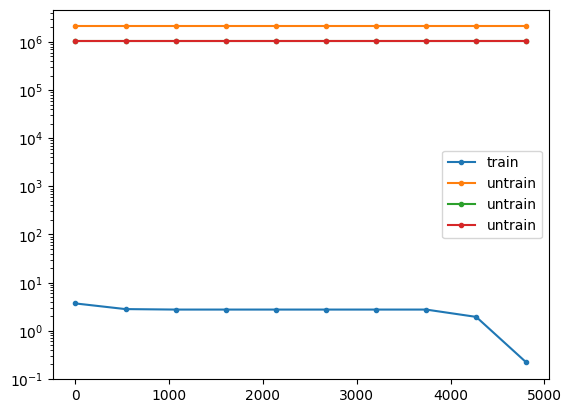

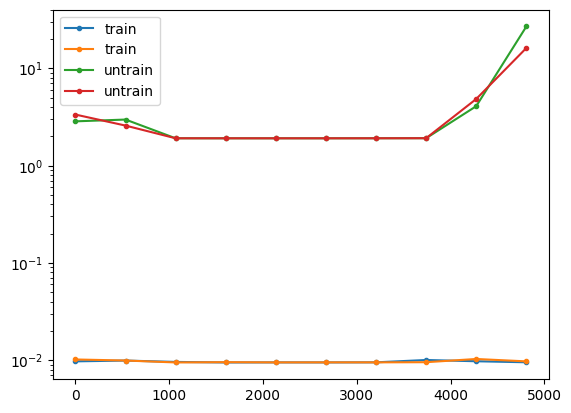

In [175]:
plt.plot(indices, train_diameters, '.-', label='train')
plt.plot(indices, untrain_diameters, '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_radii)[:, 0], '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(indices, jnp.abs(train_deltas[0]), '.-', label='train')
plt.plot(indices, jnp.abs(train_deltas[1]), '.-', label='train')
plt.plot(indices, jnp.abs(untrain_deltas[0]), '.-', label='untrain')
plt.plot(indices, jnp.abs(untrain_deltas[1]), '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

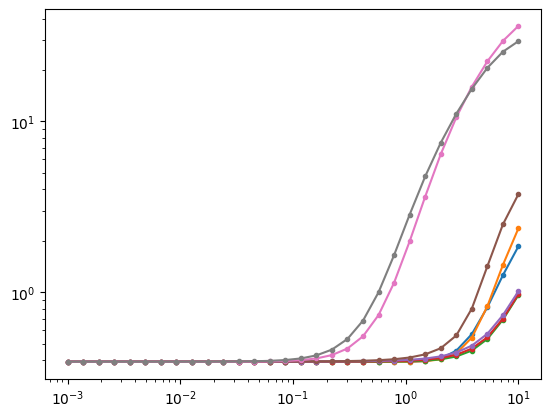

In [169]:
mults = 10**jnp.linspace(-3, 1, 30)



for i in [0, 10, 100, 1000, -1000, -100, -10, -1]:
    untrain_losses = []
    train_losses = []
    for mult in mults:
        untrain_losses.append(untrain_loss_fn(params_final_rav + mult * u[:, i]))
        train_losses.append(train_loss_fn(params_final_rav + mult * u[:, i]))

    untrain_losses = jnp.array(untrain_losses)
    train_losses = jnp.array(train_losses)

    plt.plot(mults, -untrain_losses, '.-', label='untrain')
    #plt.plot(mults, train_losses, '.-', label='train')
plt.xscale('log')
plt.yscale('log')
plt.show()

### Init basin

In [188]:
jnp.linalg.norm(J_unorth - u @ jnp.diag(s) @ vt), jnp.linalg.norm(J_unorth)

(Array(0.0616144, dtype=float32), Array(146.46031, dtype=float32))

In [193]:
indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 3).astype(int)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20

my_train_fn = final_train_loss_fn
my_untrain_fn = final_untrain_loss_fn

def Jh_direction(i):
    return vt.T @ (u.T @ evecs[:, i])

for i in indices:
    vec = Jh_direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

In [195]:
min_diameters = jnp.min(jnp.array([train_diameters, untrain_diameters]), axis=0)
logvol = jnp.sum(jnp.log10(min_diameters))

print(logvol)

2.5854607


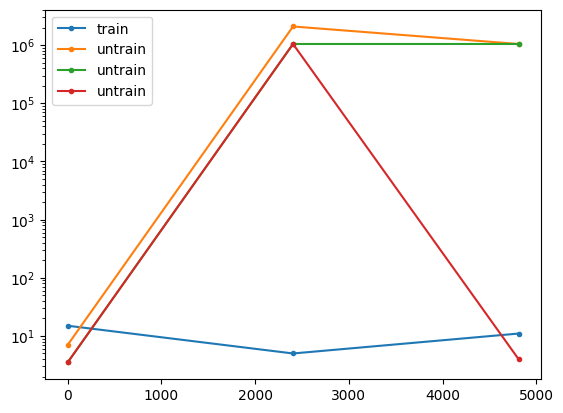

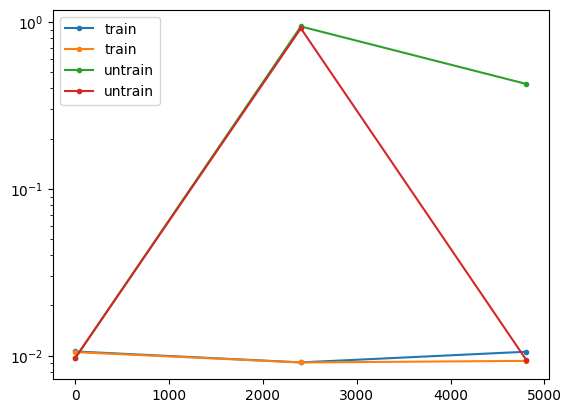

In [196]:
plt.plot(indices, train_diameters, '.-', label='train')
plt.plot(indices, untrain_diameters, '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_radii)[:, 0], '.-', label='untrain')
plt.plot(indices, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(indices, jnp.abs(train_deltas[0]), '.-', label='train')
plt.plot(indices, jnp.abs(train_deltas[1]), '.-', label='train')
plt.plot(indices, jnp.abs(untrain_deltas[0]), '.-', label='untrain')
plt.plot(indices, jnp.abs(untrain_deltas[1]), '.-', label='untrain')
plt.yscale('log')
plt.legend()
plt.show()

#### J^+ H_gen

In [264]:
#indices = jnp.linspace(0, params_spher.raveled.shape[0] - 1, 100).astype(int)

indices = [0] + (2 ** jnp.arange(12)).tolist() + list(reversed((-(2 ** jnp.arange(12) + 1)).tolist())) + [-1]
print(indices)

untrain_radii = []
train_radii = []
untrain_neg_radii = []
train_neg_radii = []

init_mult = 1
rtol = 0.1
train_cutoff = 1e-2
untrain_cutoff = 1e-2
jump = 2
train_iters = 20
untrain_iters = 20


my_train_fn = final_train_loss_fn
my_untrain_fn = final_generalization_fn

def Jgen_direction(i):
    return vt.T @ (u.T @ evecs_gen[:, i])

for i in indices:
    vec = Jgen_direction(i)
    untrain_radii.append(find_radius(params_final_rav, vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                     fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_radii.append(find_radius(params_final_rav, vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                   fn=my_train_fn, iters=train_iters, jump=jump))
    untrain_neg_radii.append(find_radius(params_final_rav, -vec, untrain_cutoff, rtol=rtol, init_mult=init_mult, 
                                          fn=my_untrain_fn, iters=untrain_iters, jump=jump))
    train_neg_radii.append(find_radius(params_final_rav, -vec, train_cutoff, rtol=rtol, init_mult=init_mult, 
                                        fn=my_train_fn, iters=train_iters, jump=jump))
untrain_diameters = jnp.array(untrain_radii)[:, 0] + jnp.array(untrain_neg_radii)[:, 0]
train_diameters = jnp.array(train_radii)[:, 0] + jnp.array(train_neg_radii)[:, 0]
untrain_deltas = (jnp.array(untrain_radii)[:, 1], jnp.array(untrain_neg_radii)[:, 1])
train_deltas = (jnp.array(train_radii)[:, 1], jnp.array(train_neg_radii)[:, 1])

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, -2049, -1025, -513, -257, -129, -65, -33, -17, -9, -5, -3, -2, -1]


In [266]:
len(indices)

26

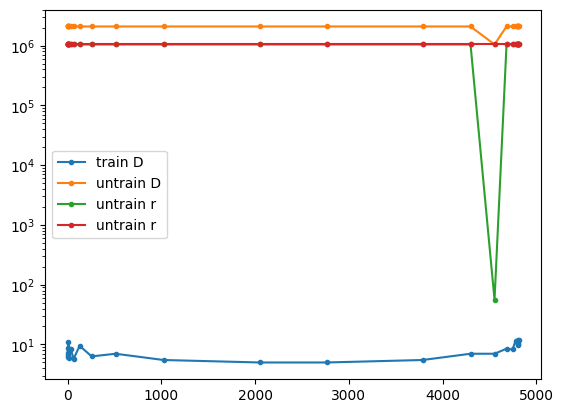

In [265]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.legend()
plt.show()

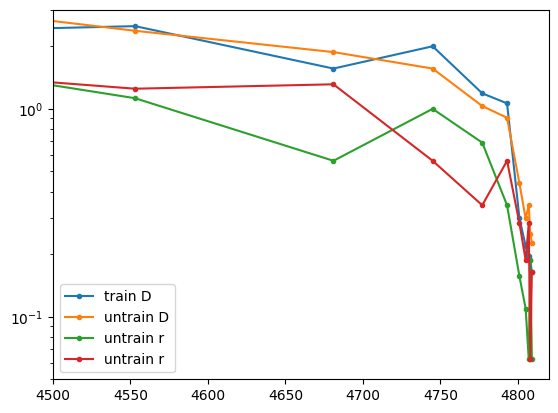

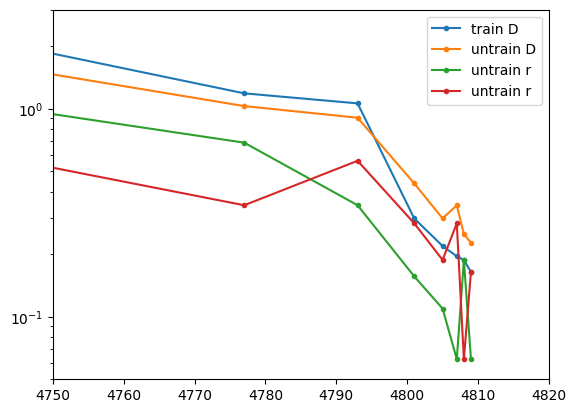

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.xlim(4500, 4820)
plt.ylim(5e-2, 3)
plt.legend()
plt.show()
plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.xlim(4750, 4820)
plt.ylim(5e-2, 3)
plt.legend()
plt.show()

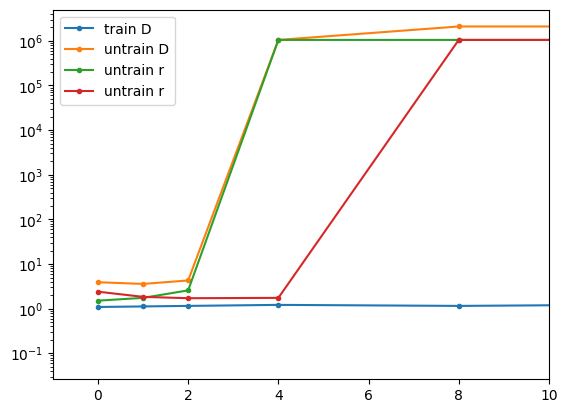

In [ ]:
indices_nonneg = [i % 4810 for i in indices]

plt.plot(indices_nonneg, train_diameters, '.-', label='train D')
plt.plot(indices_nonneg, untrain_diameters, '.-', label='untrain D')
plt.plot(indices_nonneg, jnp.array(untrain_radii)[:, 0], '.-', label='untrain r')
plt.plot(indices_nonneg, jnp.array(untrain_neg_radii)[:, 0], '.-', label='untrain r')
plt.yscale('log')
plt.xlim(-1, 10)
#plt.ylim(5e-2, 3)
plt.legend()
plt.show()

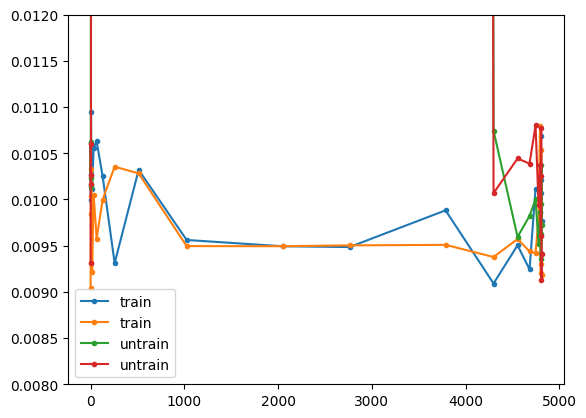

In [ ]:

plt.plot(indices_nonneg, jnp.abs(train_deltas[0]), '.-', label='train')
plt.plot(indices_nonneg, jnp.abs(train_deltas[1]), '.-', label='train')
plt.plot(indices_nonneg, jnp.abs(untrain_deltas[0]), '.-', label='untrain')
plt.plot(indices_nonneg, jnp.abs(untrain_deltas[1]), '.-', label='untrain')
#plt.yscale('log')
plt.ylim(.008, .012)
plt.legend()
plt.show()

## Experiments 09-26

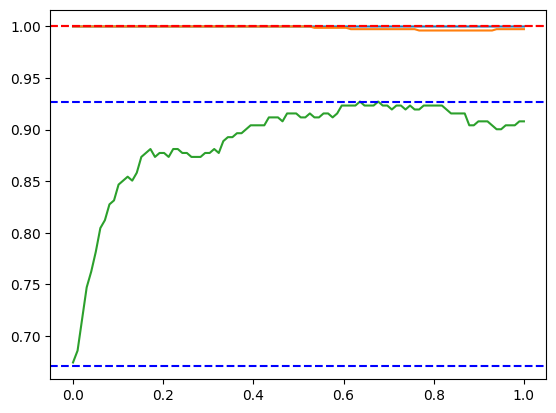

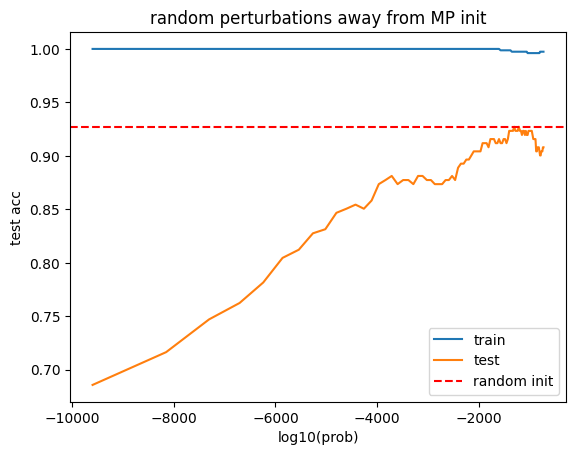

In [15]:
train_init, test_init = final_metrics(params_randinit)
train_spher, test_spher = final_metrics(params_spher)

plt.plot(xs, jnp.array(ell_norms_mp_init) / jnp.linalg.norm(params_spher.raveled))
plt.plot(xs, jnp.array(train_accs_mp_init))
plt.plot(xs, jnp.array(test_accs_mp_init))
# plt.plot(xs, jnp.array(train_accs_0))
# plt.plot(xs, jnp.array(test_accs_0))
# plt.plot(xs, jnp.array(train_accs_1))
# plt.plot(xs, jnp.array(test_accs_1))

# horizontal lines
plt.axhline(train_init, color='r', linestyle='--')
plt.axhline(test_init, color='b', linestyle='--')
plt.axhline(train_spher, color='r', linestyle='--')
plt.axhline(test_spher, color='b', linestyle='--')
plt.show()

dim = params_init.raveled.shape[0]
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys
caps = jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs])

plt.plot(caps, jnp.array(train_accs_mp_init), label='train')
plt.plot(caps, jnp.array(test_accs_mp_init), label='test')
plt.axhline(test_init, color='r', linestyle='--', label='random init')
plt.xlabel("log10(prob)")
plt.ylabel("test acc")
plt.title("random perturbations away from MP init")
plt.legend()
plt.show()


### Jacobian

In [16]:
def train_fn(params_raveled):
    params_raveled = params_raveled * jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_raveled)
    params = Params(params_raveled, params_init.unravel)

    apply_fn = mp.make_apply_full(model, params.unravel)

    _, _, state = mp.train(
        params_raveled, 
        X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, 
        apply_fn, cfg,
        target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
        return_state=True,
    )
    
    return state.params['p']

In [17]:
jac_fn = jax.jacfwd(train_fn)

In [18]:
J = jac_fn(params_spher.raveled)
print(J.shape)

(4810, 4810)


In [35]:
from einops import einsum, rearrange, repeat, reduce

In [46]:
params_unit = params_spher.raveled / jnp.linalg.norm(params_spher.raveled)
proj_param = einsum(params_unit, params_unit, 'i, j -> i j')
proj_orth = jnp.eye(J.shape[0]) - proj_param
# J_orth = proj_orth @ J @ proj_orth
# print(jnp.linalg.norm(J_orth, axis=1))
J_orth2 = J @ proj_orth
print(jnp.linalg.norm(J_orth2, axis=1))

[ 0.98197144 11.488663    3.094256   ...  3.1599658  11.24924
 18.65538   ]


In [47]:
J_unorth = J + proj_param

In [48]:
jnp.linalg.det(J)

Array(0., dtype=float32)

In [40]:
proj_orth.shape

(4810, 4810)

In [49]:
jnp.linalg.matrix_rank(proj_orth)

Array(4809, dtype=int32)

In [50]:
# rank of J
print(jnp.linalg.matrix_rank(J))
# print(jnp.linalg.matrix_rank(J_orth))
print(jnp.linalg.matrix_rank(J_orth2))
print(jnp.linalg.matrix_rank(J_unorth))

4624
4624
4625


In [60]:
two = jnp.array([[2.]])
jnp.linalg.slogdet(two).logabsdet, jnp.log(2)

(Array(0.6931472, dtype=float32),
 Array(0.6931472, dtype=float32, weak_type=True))

In [63]:
print(jnp.linalg.slogdet(J))
print(jnp.linalg.slogdet(J_unorth))
print(jnp.linalg.slogdet(J_orth2))

SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(-1405.8884, dtype=float32))
SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(-1389.7759, dtype=float32))
SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(-1344.0205, dtype=float32))


In [64]:
u, s, vt = jnp.linalg.svd(J)

In [65]:
u_unorth, s_unorth, vt_unorth = jnp.linalg.svd(J_unorth)

In [66]:
u_orth2, s_orth2, vt_orth2 = jnp.linalg.svd(J_orth2)

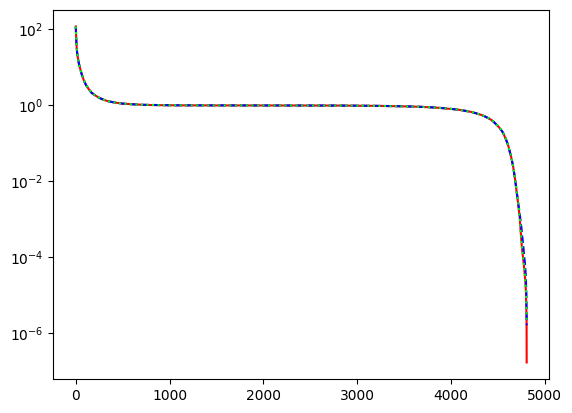

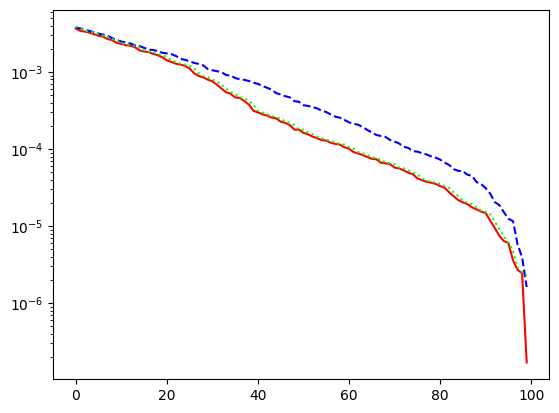

In [76]:



plt.plot(s, color='r')
plt.plot(s_orth2, linestyle='--', color='b')
plt.plot(s_unorth, linestyle=':', color='#00FF00')
plt.yscale('log')
plt.show()


plt.plot(s[-100:], color='r')
plt.plot(s_orth2[-100:], linestyle='--', color='b')
plt.plot(s_unorth[-100:], linestyle=':', color='#00FF00')
plt.yscale('log')
plt.show()

In [83]:
cosine_sim = vt[-1] @ params_unit
print(cosine_sim)

0.43696558


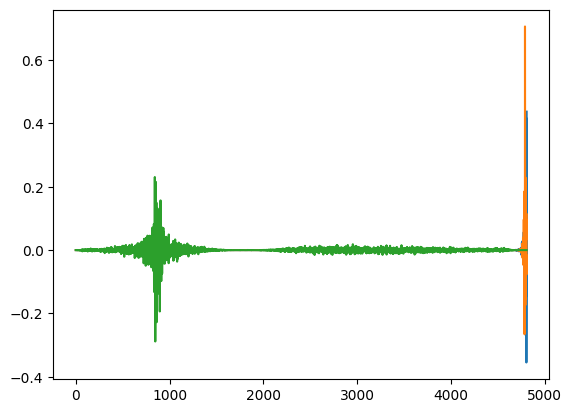

In [78]:
sims = vt @ params_unit
sims_orth2 = vt_orth2 @ params_unit
sim_unorth = vt_unorth @ params_unit
plt.plot(sims[:])
plt.plot(sims_orth2[:])
plt.plot(sim_unorth[:])
plt.show()

In [79]:
jnp.sum(jnp.log10(s))

Array(-610.0084, dtype=float32)

In [80]:
jnp.sum(jnp.log10(s_unorth))

Array(-603.6118, dtype=float32)

In [83]:
jnp.linalg.slogdet(J).logabsdet / jnp.log(10)

Array(-610.5696, dtype=float32)

In [82]:
jnp.linalg.slogdet(J_unorth).logabsdet / jnp.log(10)

Array(-603.572, dtype=float32)

### Testing linearity

[0.9999997 1.0000002 1.0000001 ... 1.        1.        1.       ]


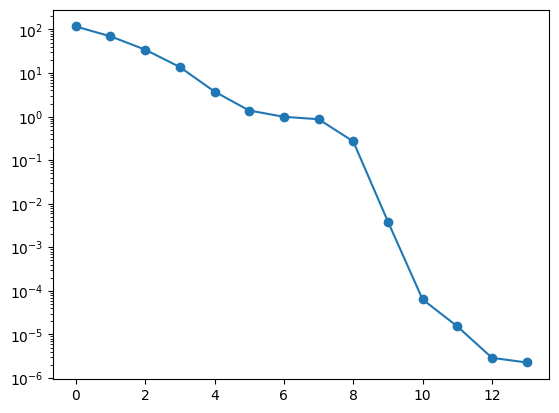


mag: 1.000000e-05


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]



mag: 1.000000e-04


100%|██████████| 14/14 [00:11<00:00,  1.27it/s]



mag: 1.000000e-03


100%|██████████| 14/14 [00:10<00:00,  1.33it/s]



mag: 1.000000e-02


100%|██████████| 14/14 [00:10<00:00,  1.38it/s]



mag: 1.000000e-01


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]



mag: 1.000000e+00


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


In [100]:
params_init_rav = params_spher.raveled
params_final_rav = train_fn(params_spher.raveled)
print(jnp.linalg.norm(vt_unorth, axis=1))

indices = [0, 3, 10, 30, 100, 300, 1000, -1000, -300, -100, -30, -10, -3, -1]
mags = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]

actual_svs = [s_unorth[i] for i in indices]

plt.plot(actual_svs, 'o-')
plt.yscale('log')
plt.show()

all_diffs = []
all_svs = []

for mag in mags:
    print()
    print(f'mag: {mag:e}')

    diffs = []
    svs = []

    for i in tqdm(indices):
        pert = vt_unorth[i] * mag
        params_final_pert_rav = train_fn(params_init_rav + pert)
        diff = jnp.linalg.norm(params_final_rav - params_final_pert_rav)
        diffs.append(diff)
        svs.append(s_unorth[i] * mag)

    all_diffs.append(diffs)
    all_svs.append(svs)

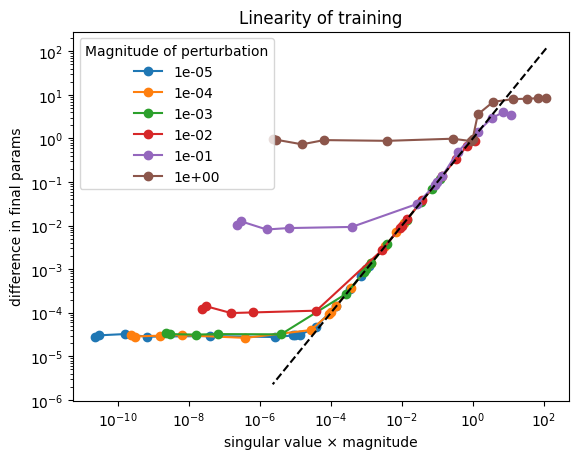

In [104]:
for diffs, svs, mag in zip(all_diffs, all_svs, mags):
    plt.plot(svs, diffs, 'o-', label=f'{mag:.0e}')
plt.plot(svs, svs, linestyle='--', color='k')
plt.legend(title='Magnitude of perturbation')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('singular value × magnitude')
plt.ylabel('difference in final params')
plt.title('Linearity of training')
plt.show()

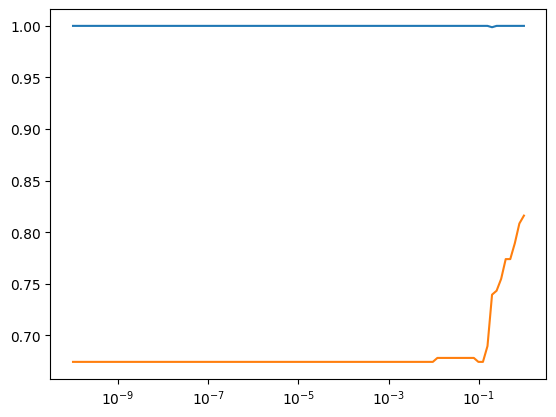

In [107]:
xs = 10**jnp.linspace(-10, 0, 100)

train_accs_pert = []
test_accs_pert = []


for mult in xs:
    pert = vt_unorth[30] * mult
    params_final_pert_rav = train_fn(params_init_rav + pert)
    params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

    train_acc = metrics(params_final_pert, X_train, Y_train)[1]
    test_acc = metrics(params_final_pert, X_test, Y_test)[1]
    train_accs_pert.append(train_acc)
    test_accs_pert.append(test_acc)
    
plt.plot(xs, jnp.array(train_accs_pert))
plt.plot(xs, jnp.array(test_accs_pert))
plt.xscale('log')
plt.show()

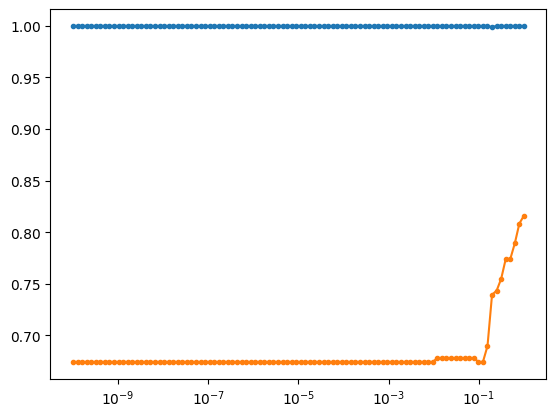

In [113]:

plt.plot(xs, jnp.array(train_accs_pert), '.-')
plt.plot(xs, jnp.array(test_accs_pert), '.-')
plt.xscale('log')
plt.show()

#### v init

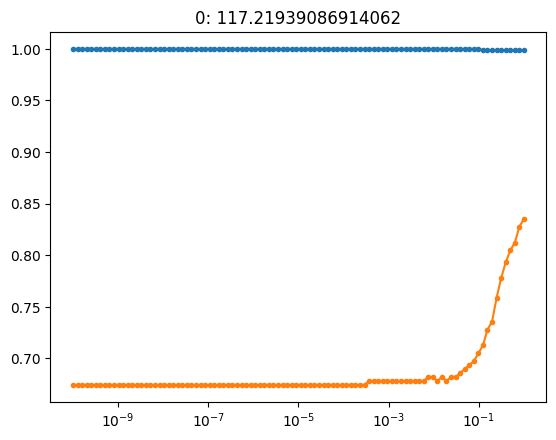

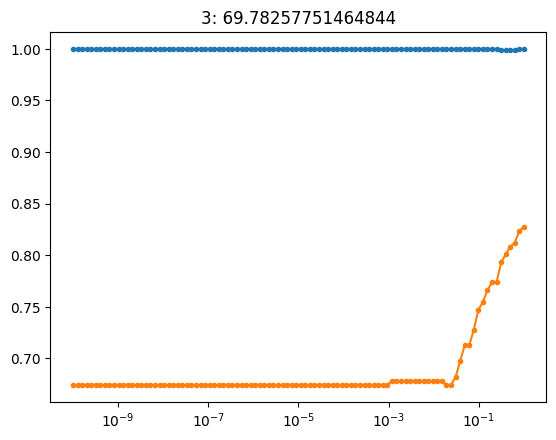

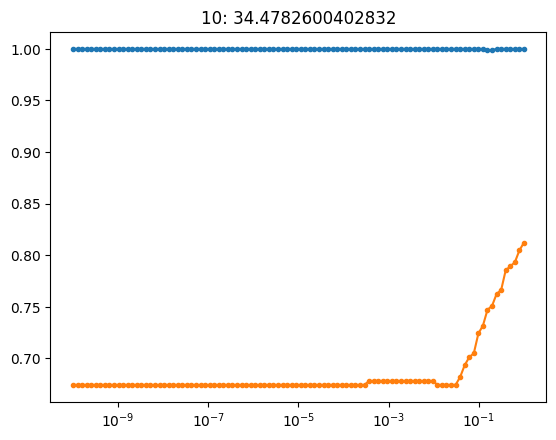

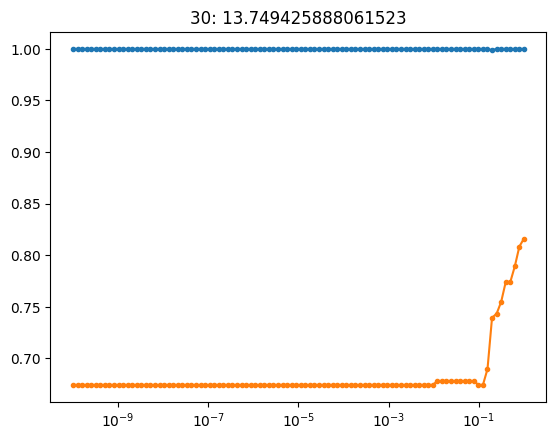

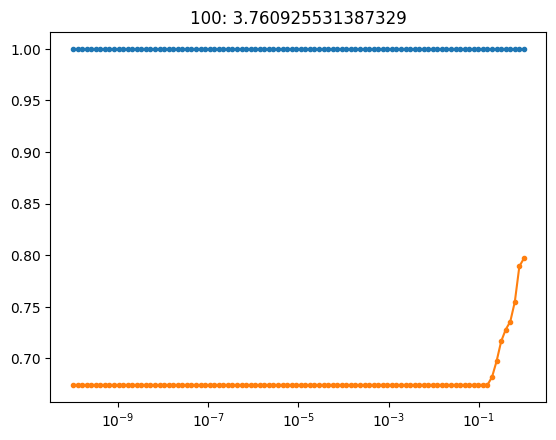

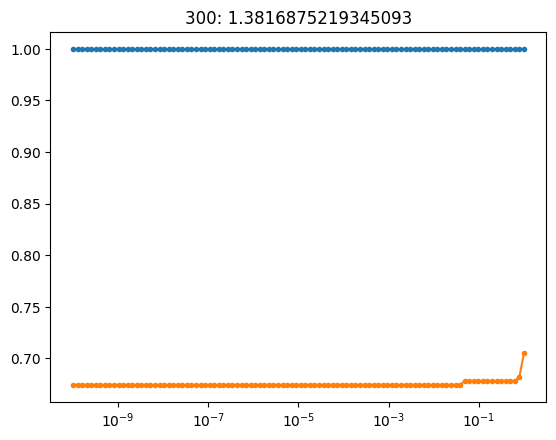

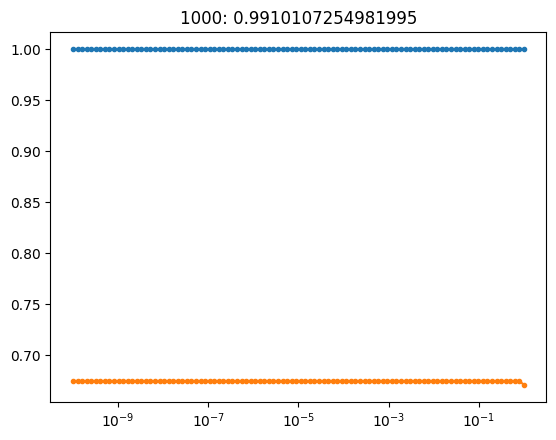

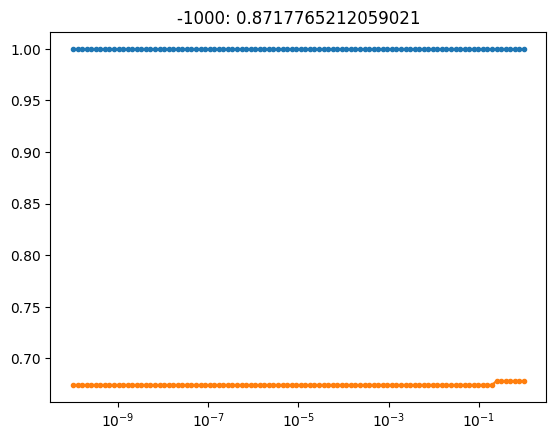

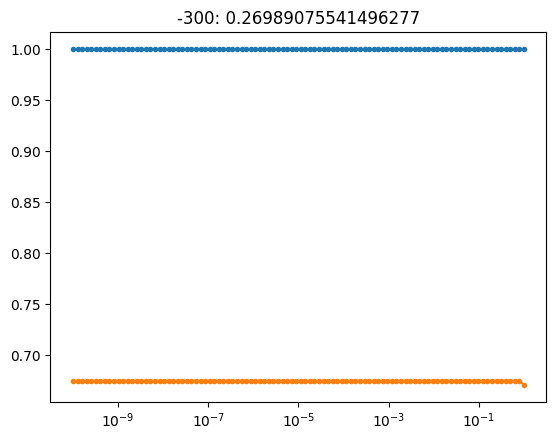

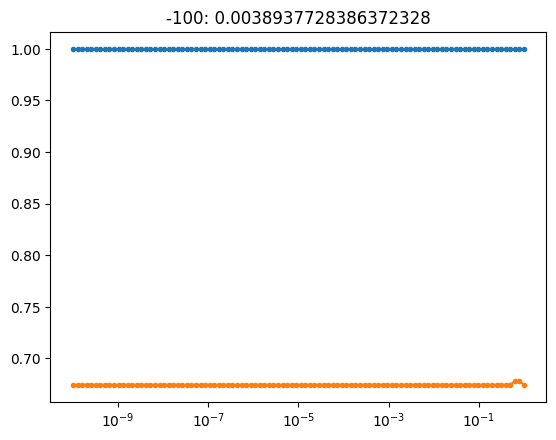

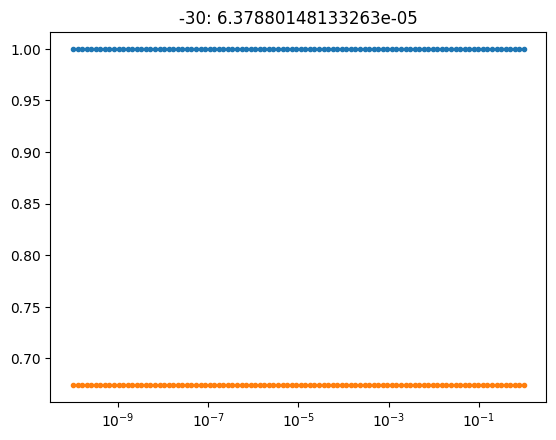

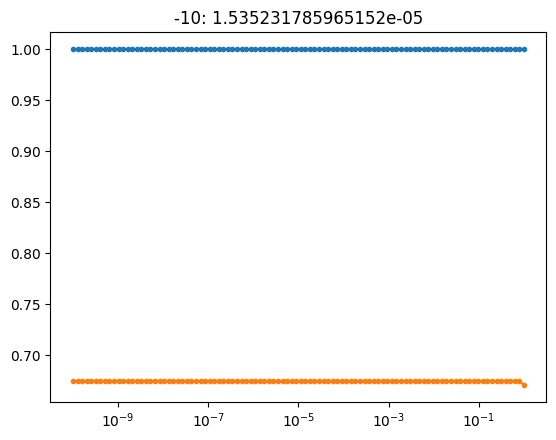

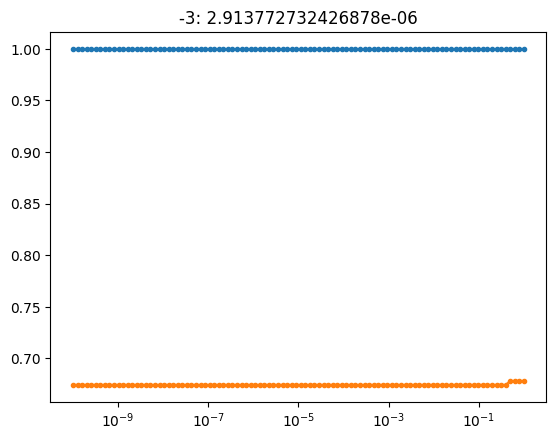

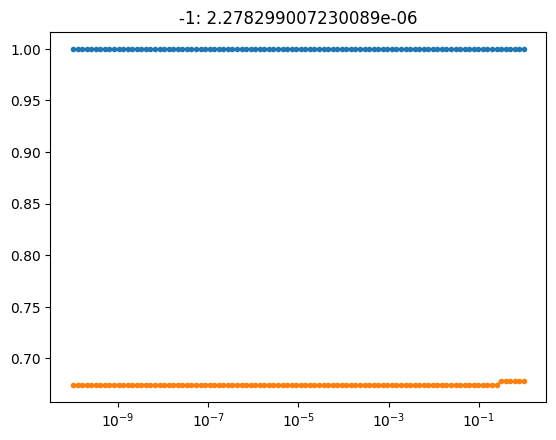

In [116]:
xs = 10**jnp.linspace(-10, 0, 100)


for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'{i}: {s_unorth[i]}')
    plt.show()

#### v init updated

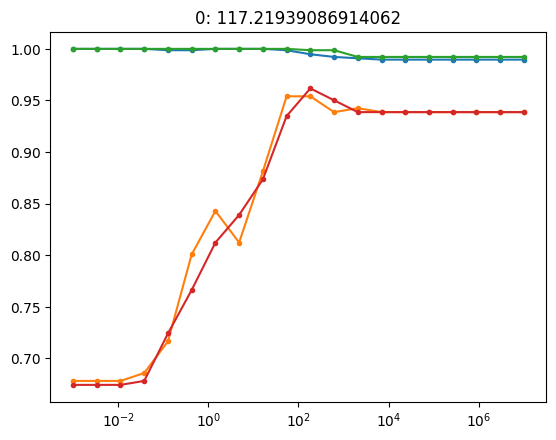

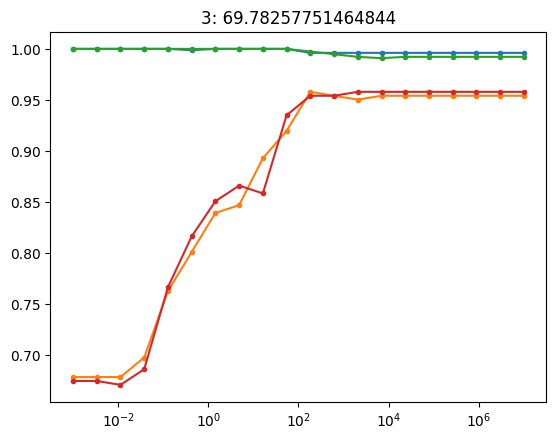

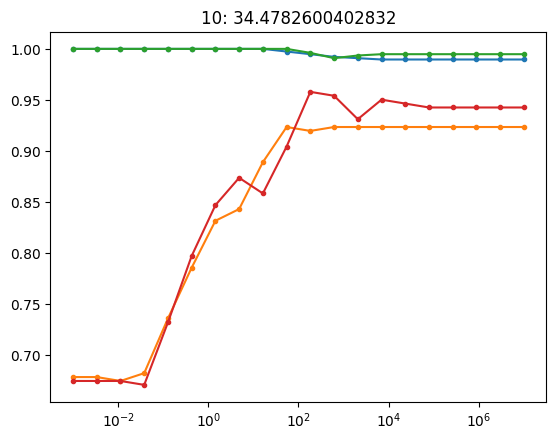

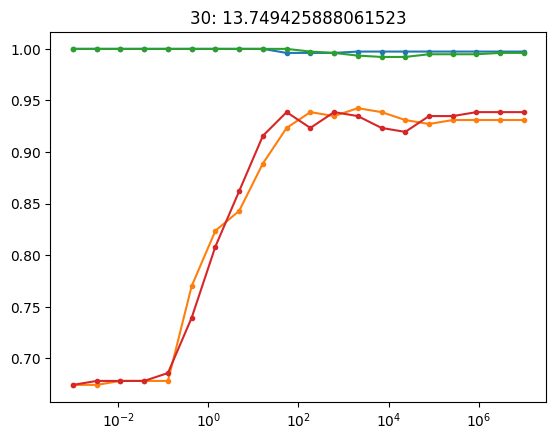

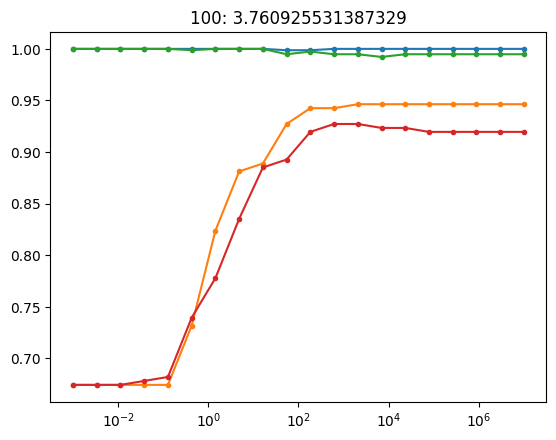

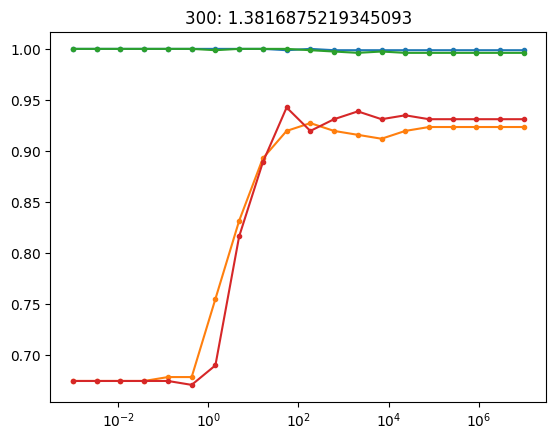

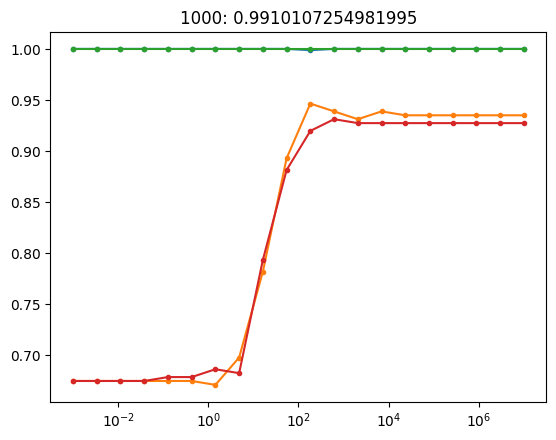

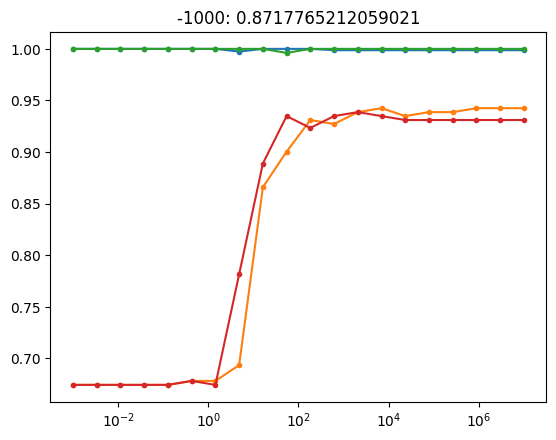

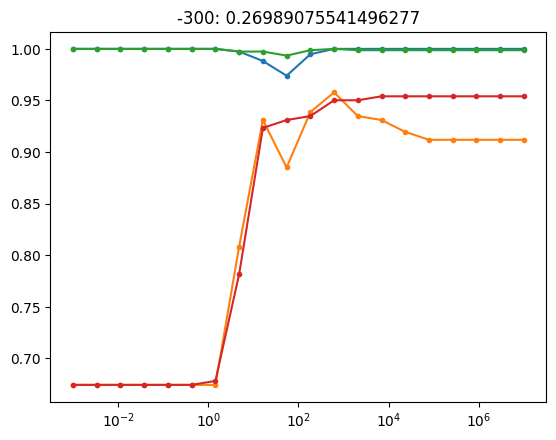

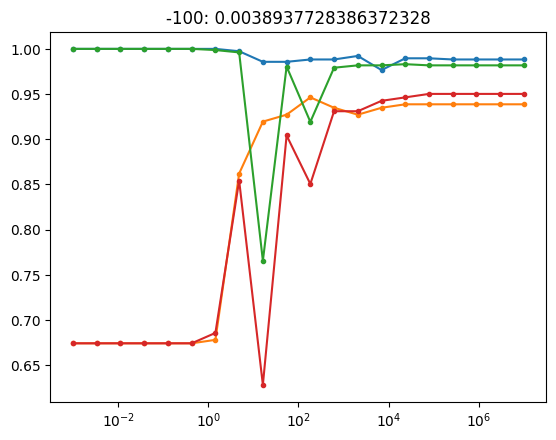

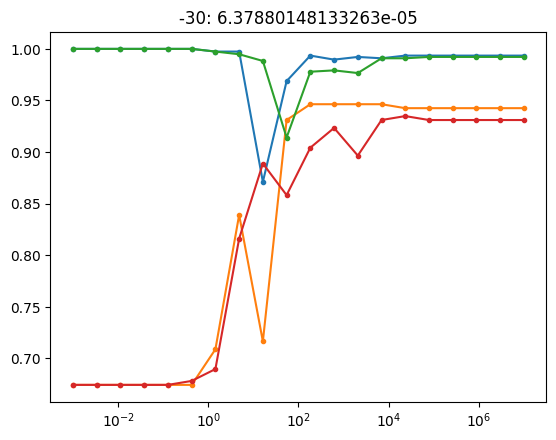

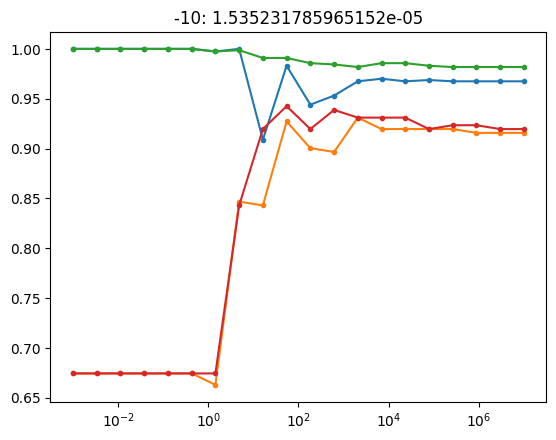

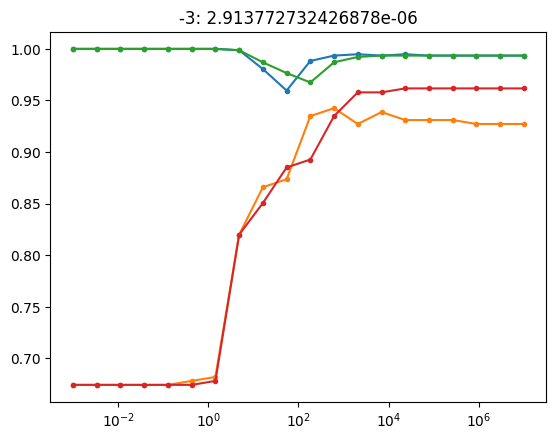

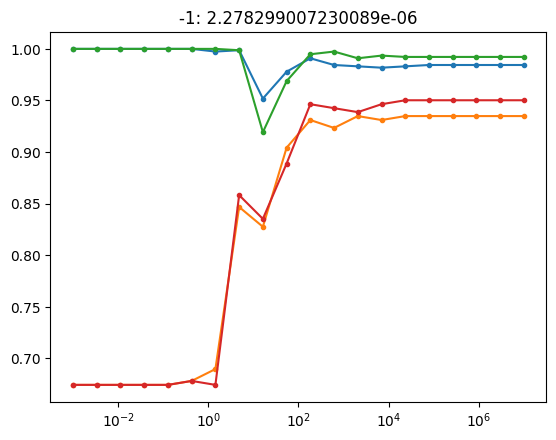

In [120]:
xs = 10**jnp.linspace(-3, 7, 20)


for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'{i}: {s_unorth[i]}')
    plt.show()

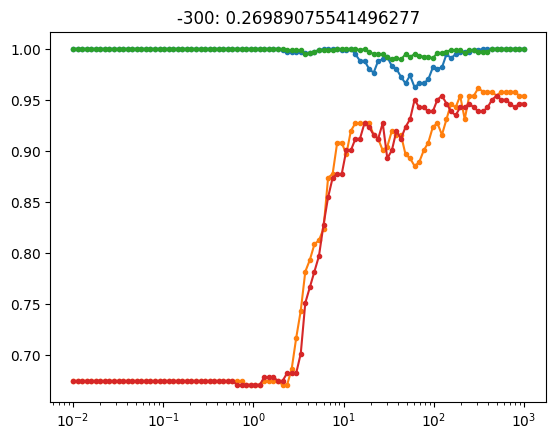

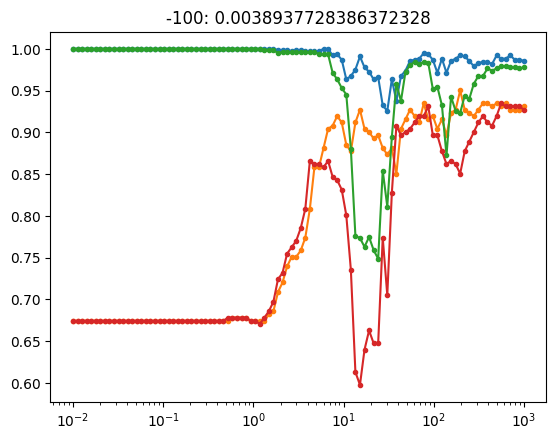

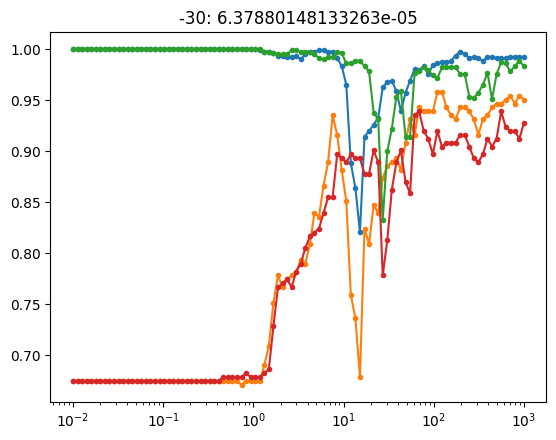

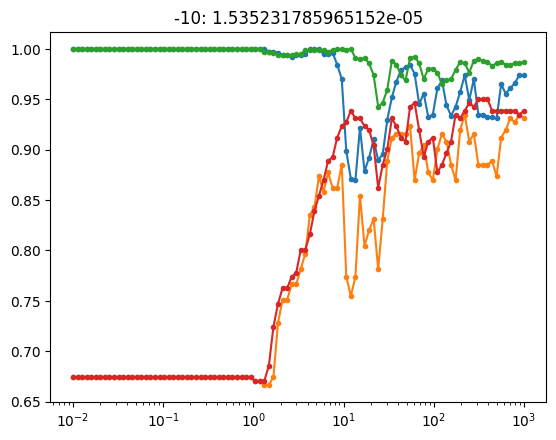

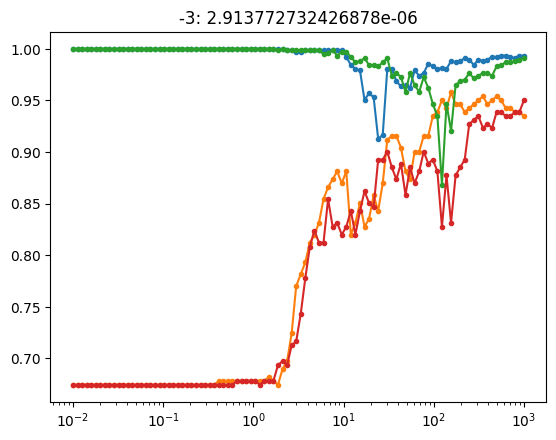

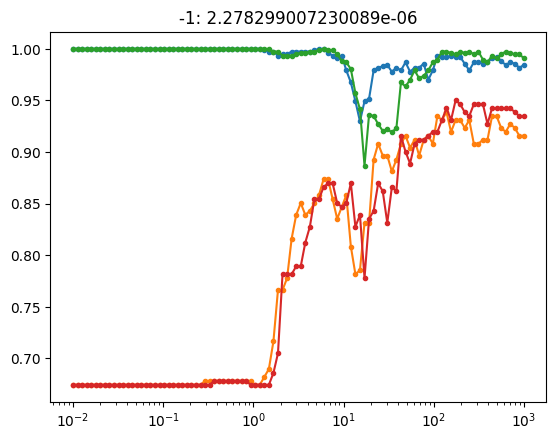

In [144]:
xs = 10**jnp.linspace(-2, 3, 100)


for i in indices[-6:]:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'{i}: {s_unorth[i]}')
    plt.show()

#### v final

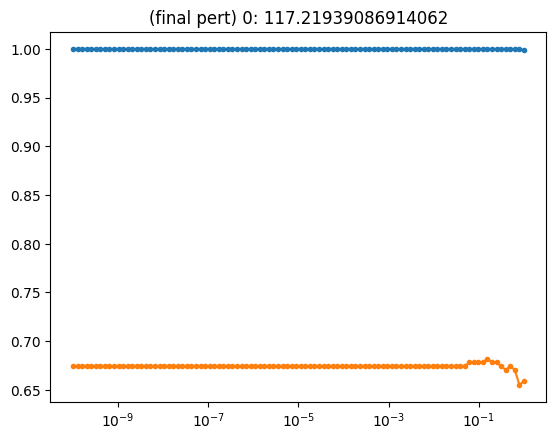

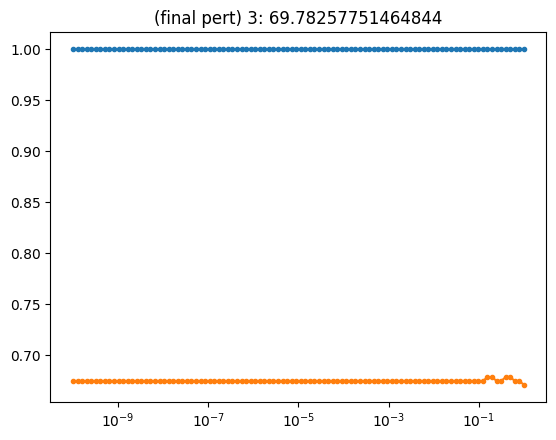

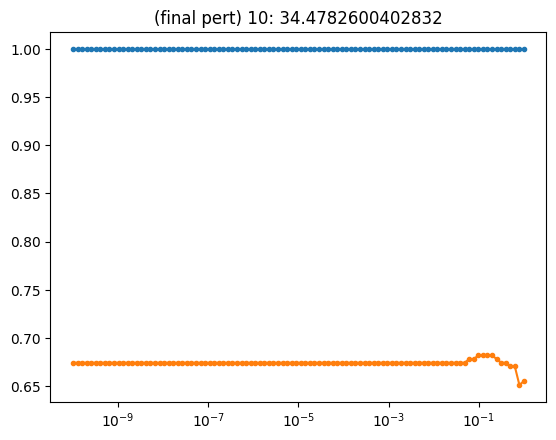

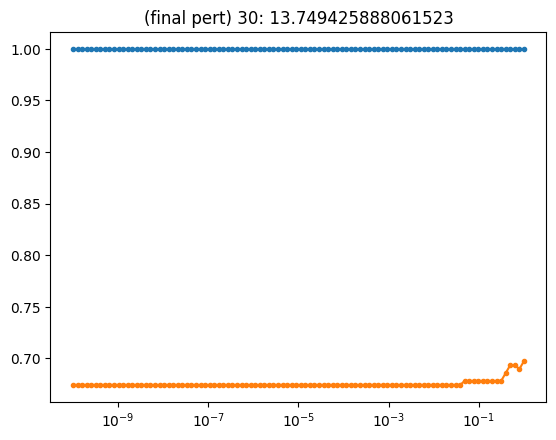

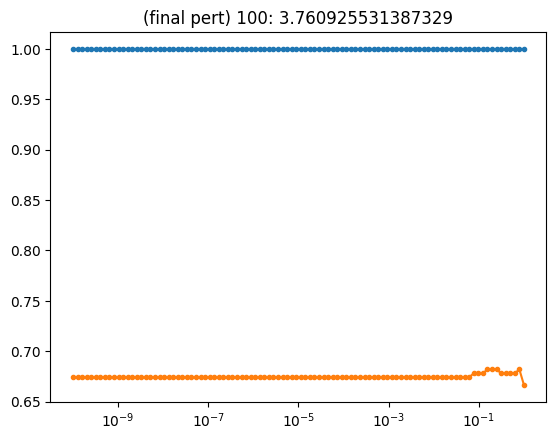

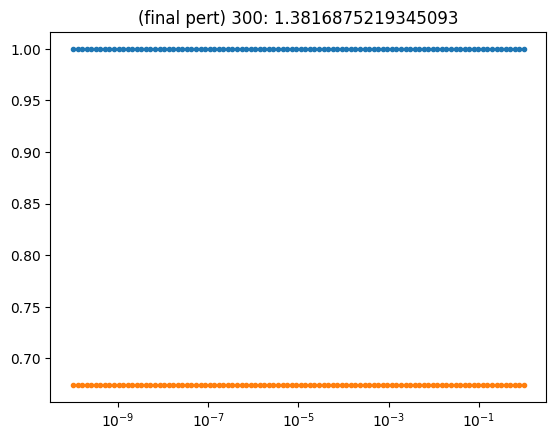

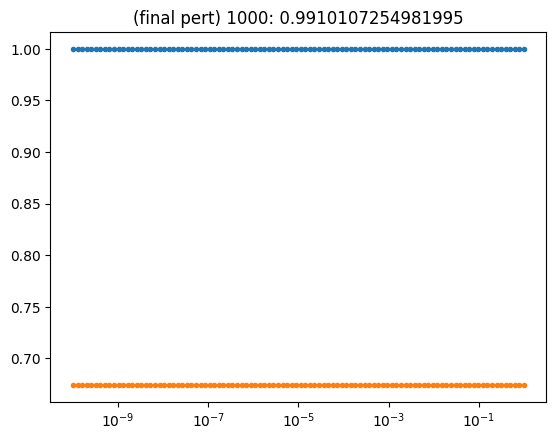

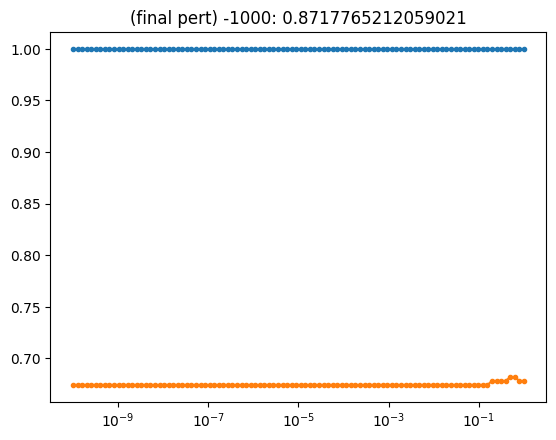

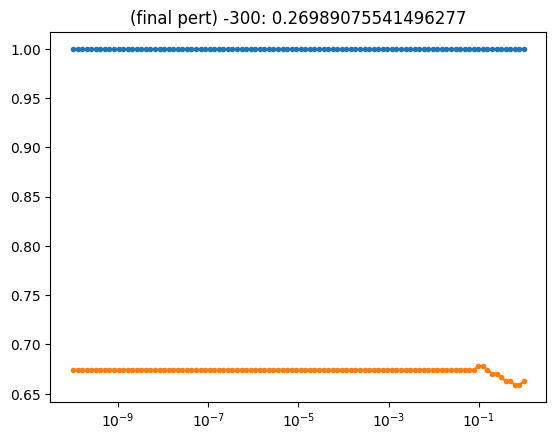

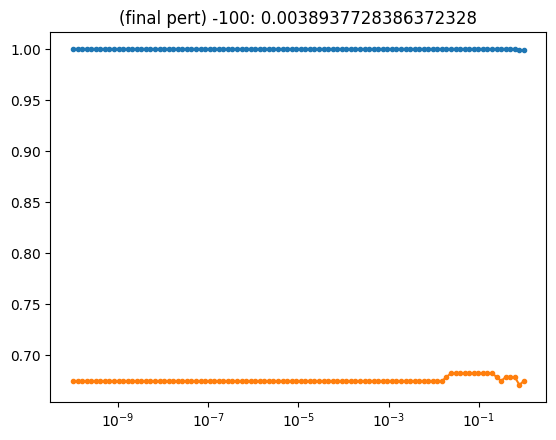

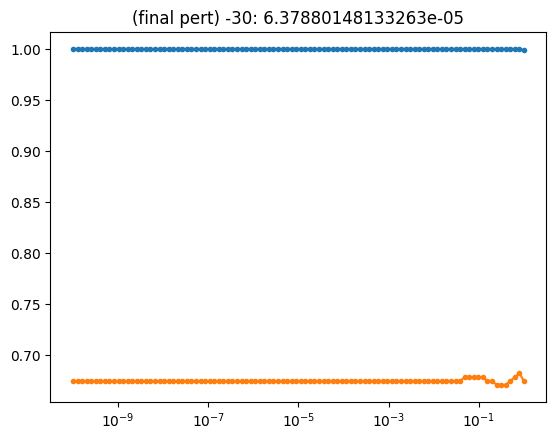

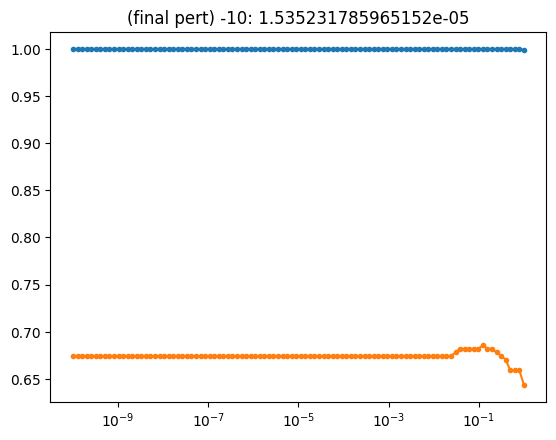

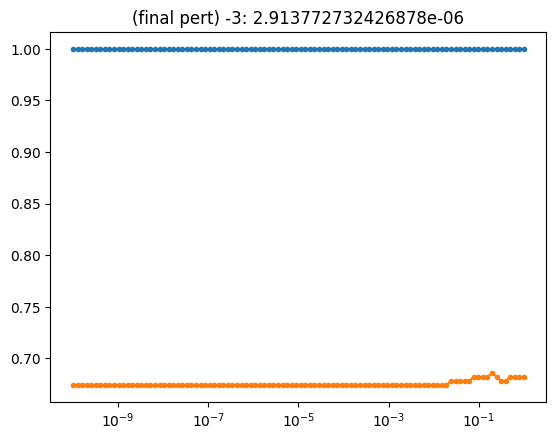

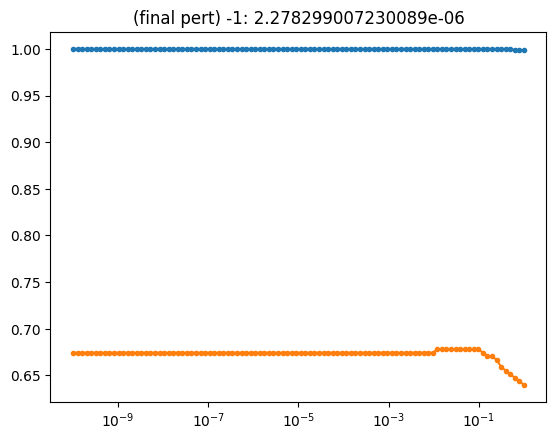

In [117]:
xs = 10**jnp.linspace(-10, 0, 100)


params_final_rav = train_fn(params_init_rav)
params_final = Params(params_final_rav, params_spher.unravel)

for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'(final pert) {i}: {s_unorth[i]}')
    plt.show()

#### u final


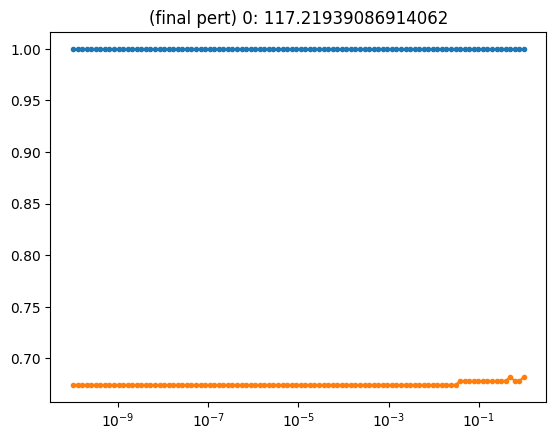

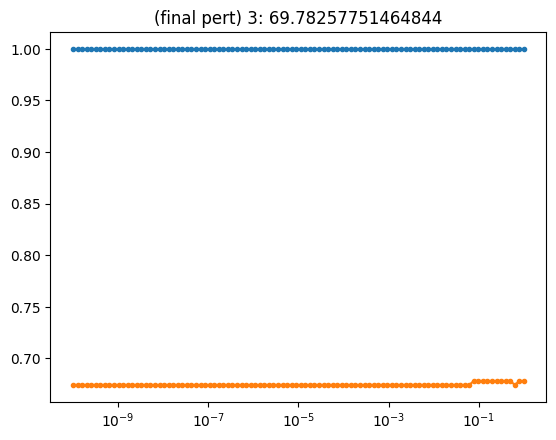

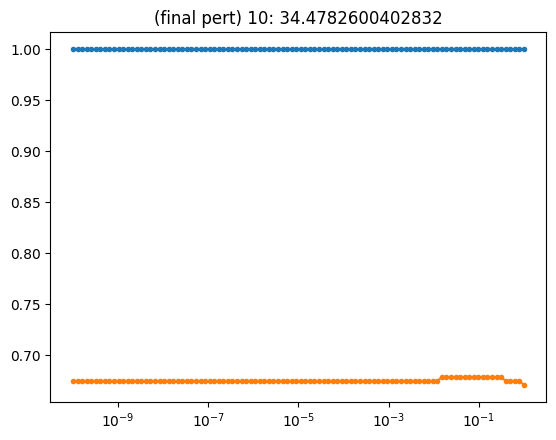

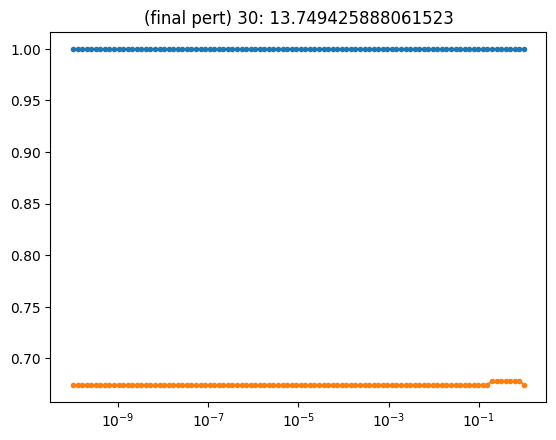

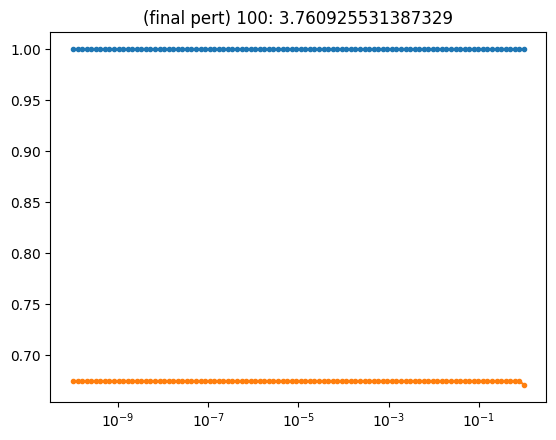

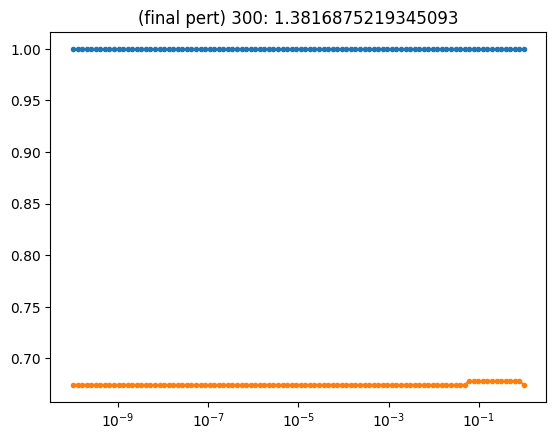

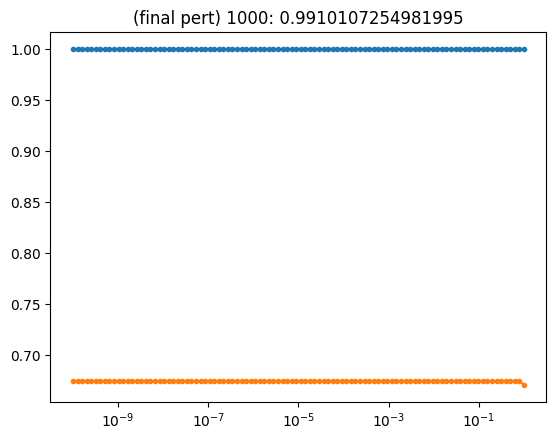

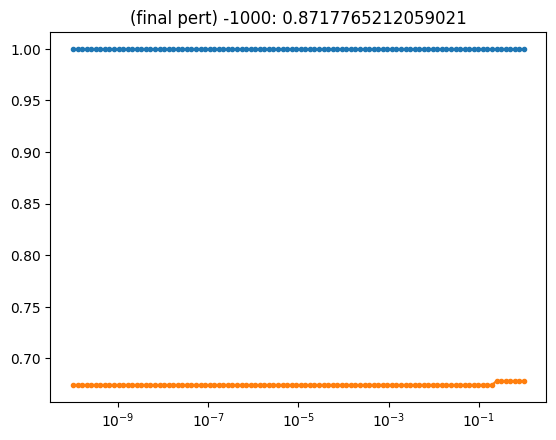

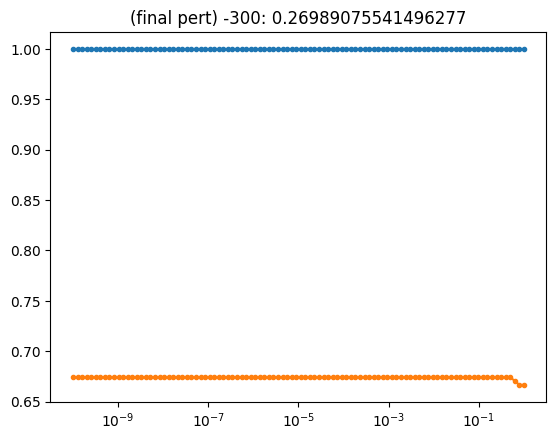

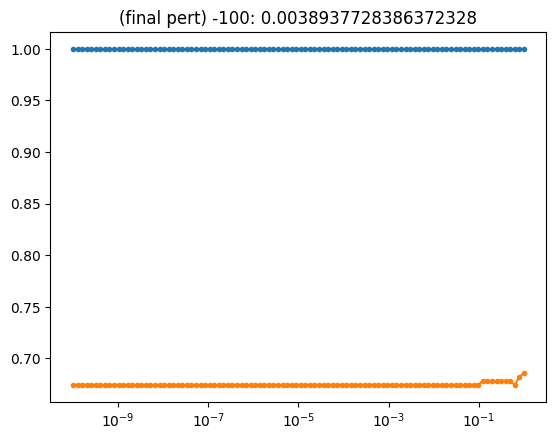

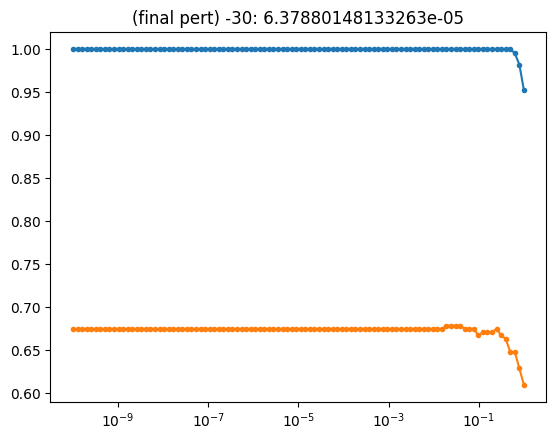

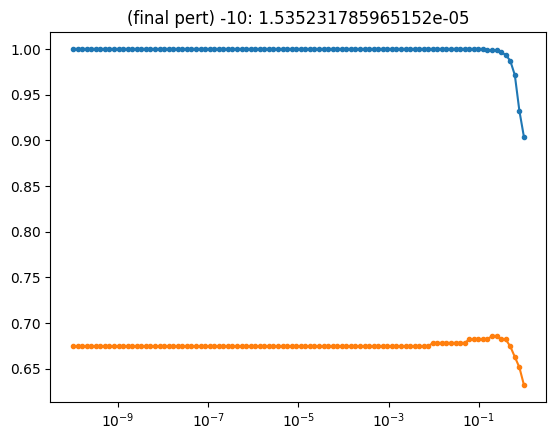

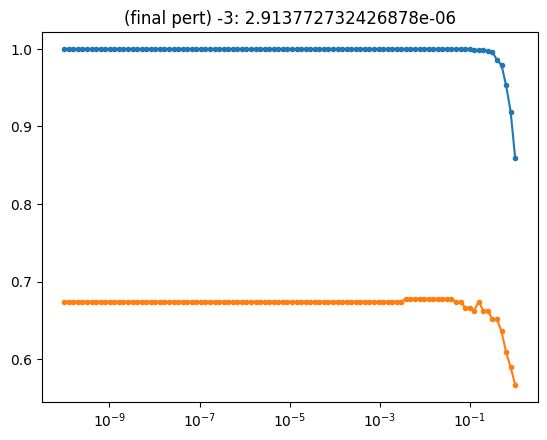

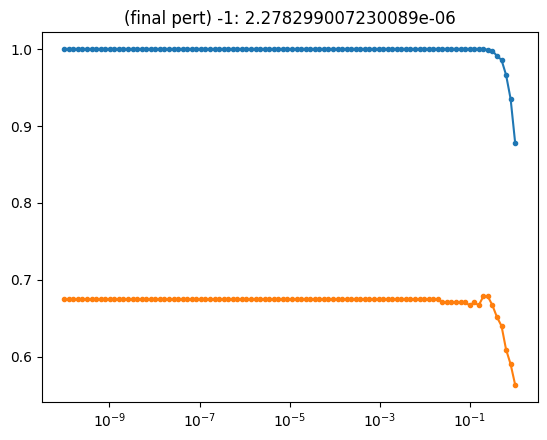

In [119]:
xs = 10**jnp.linspace(-10, 0, 100)


params_final_rav = train_fn(params_init_rav)
params_final = Params(params_final_rav, params_spher.unravel)

for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    
    for mult in xs:
        pert = u_unorth[:, i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'(final pert) {i}: {s_unorth[i]}')
    plt.show()

#### u final updated

57.883163


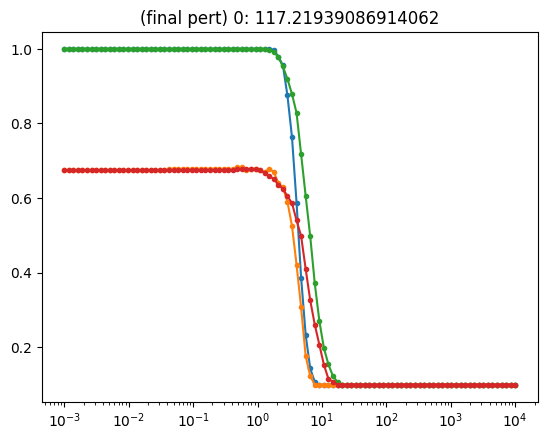

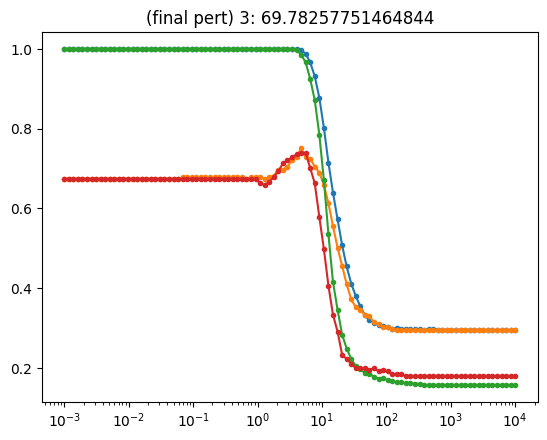

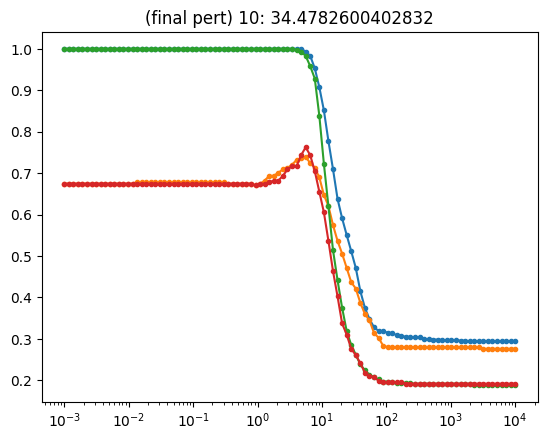

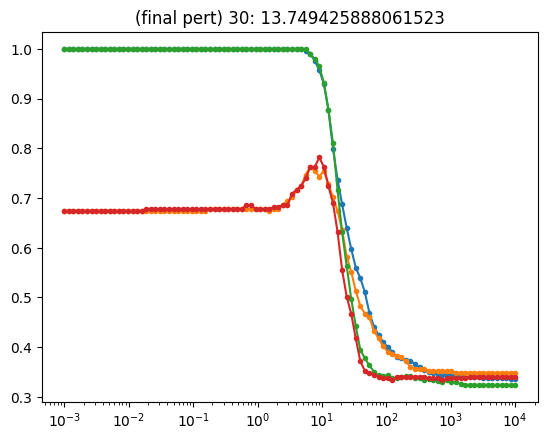

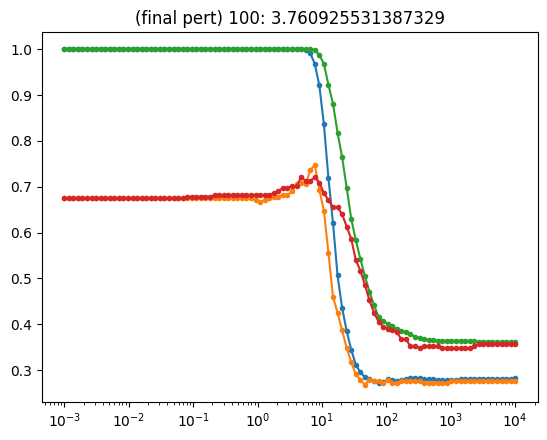

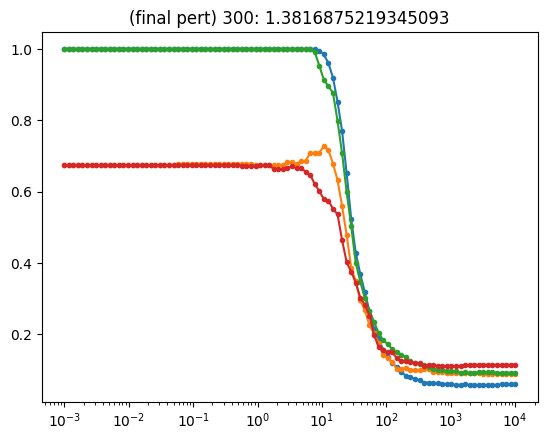

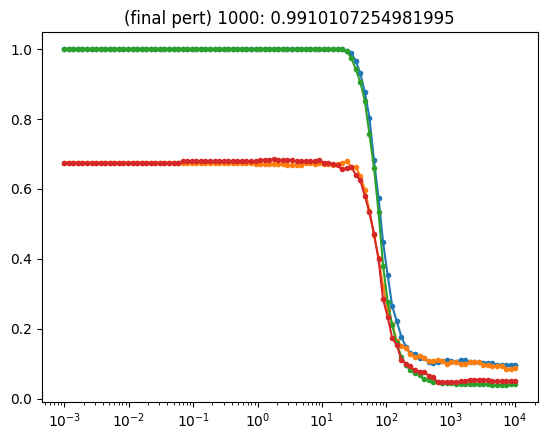

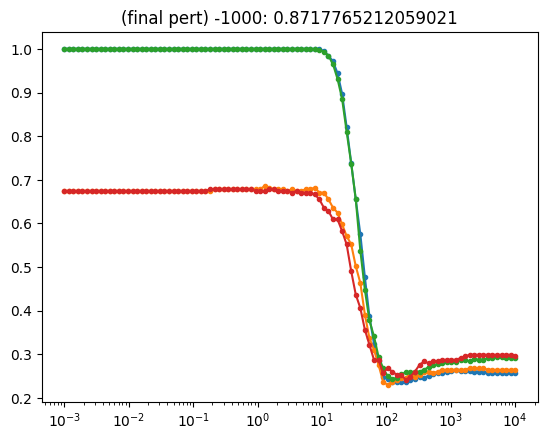

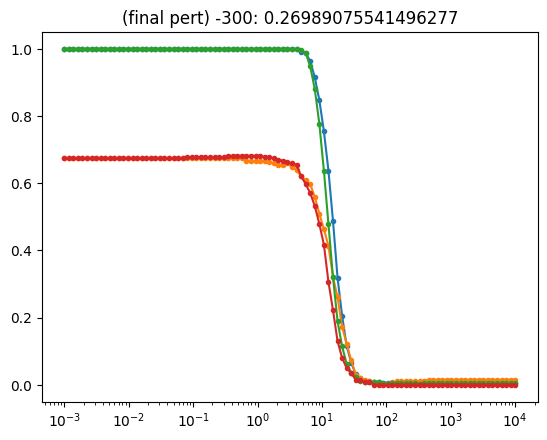

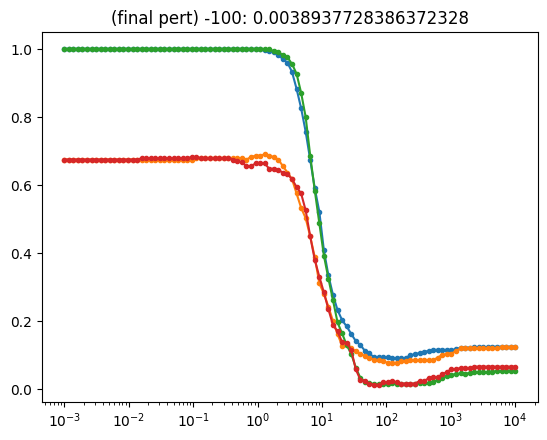

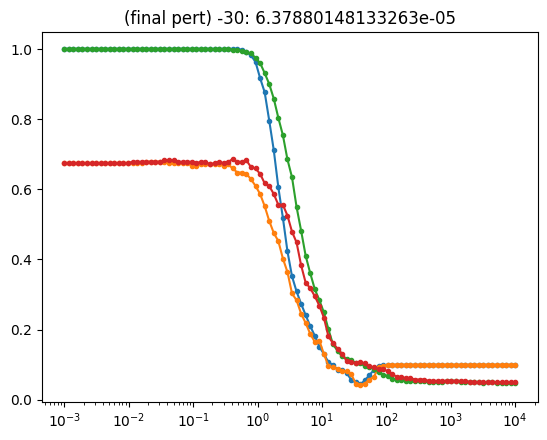

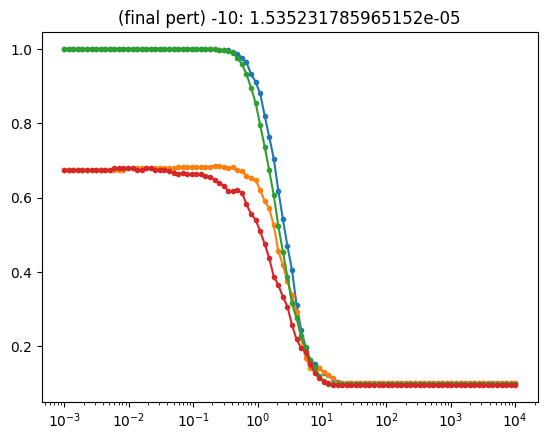

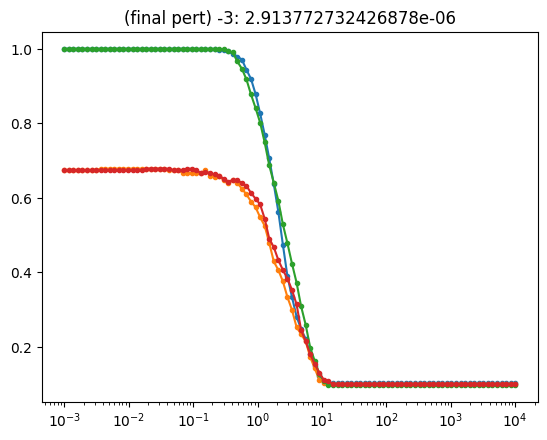

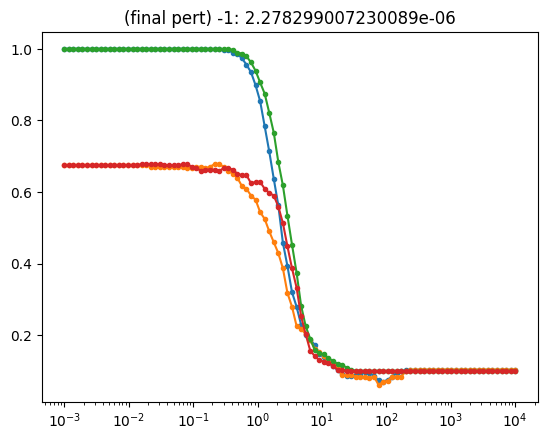

In [218]:
xs = 10**jnp.linspace(-3, 4, 100)


params_final_rav = train_fn(params_init_rav)
params_final = Params(params_final_rav, params_spher.unravel)

print(jnp.linalg.norm(params_final_rav))

for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = u_unorth[:, i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_rav_pert = params_final_rav_pert * jnp.linalg.norm(params_final_rav) / jnp.linalg.norm(params_final_rav_pert)
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -u_unorth[:, i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_rav_pert = params_final_rav_pert * jnp.linalg.norm(params_final_rav) / jnp.linalg.norm(params_final_rav_pert)
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'(final pert) {i}: {s_unorth[i]}')
    plt.show()

In [97]:
actual_svs

[Array(117.21939, dtype=float32),
 Array(69.78258, dtype=float32),
 Array(34.47826, dtype=float32),
 Array(13.749426, dtype=float32),
 Array(3.7609255, dtype=float32),
 Array(1.3816875, dtype=float32),
 Array(0.9910107, dtype=float32),
 Array(0.8717765, dtype=float32),
 Array(0.26989076, dtype=float32),
 Array(0.00389377, dtype=float32),
 Array(6.3788015e-05, dtype=float32),
 Array(1.5352318e-05, dtype=float32),
 Array(2.9137727e-06, dtype=float32),
 Array(2.278299e-06, dtype=float32)]

### Hessian

In [146]:
def train_loss_fn(params_raveled):
    logits = model.apply(params_spher.unravel(params_raveled), X_train)
    preds = jnp.argmax(logits, axis=-1)

    loss = mp.sparse_xent(logits, Y_train).mean()
    return loss

hess_fn = jax.hessian(train_loss_fn)

In [147]:
H = hess_fn(params_final_rav)

In [148]:
evals, evecs = jnp.linalg.eigh(H)

In [161]:
final_loss = train_loss_fn(params_final_rav)

def find_radius(center, vec, cutoff, high=None, low=0, init_mult=1, iters=10):
    center_loss = train_loss_fn(center)
    vec_loss = train_loss_fn(center + init_mult * vec)

    if iters == 0:
        return init_mult, vec_loss - center_loss
    if vec_loss - center_loss < cutoff:  # too low
        low = init_mult
        if high is None:
            new_init_mult = init_mult * 2
        else:
            new_init_mult = (high + low) / 2
    else:  # too high
        high = init_mult
        new_init_mult = (high + low) / 2
    
    return find_radius(center, vec, cutoff, high=high, low=low, init_mult=new_init_mult, iters=iters - 1)

In [159]:
final_loss

Array(0.02561148, dtype=float32)

100%|██████████| 4810/4810 [17:44<00:00,  4.52it/s]


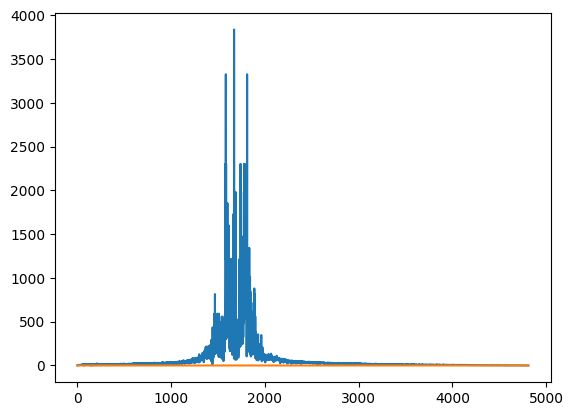

In [166]:
radii = []
for i in trange(H.shape[0]):
    radii.append(find_radius(params_final_rav, evecs[:, i], 1e-2, iters=15))
radii = jnp.array(radii)


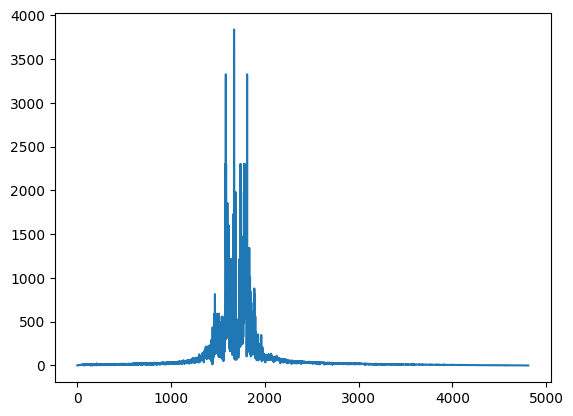

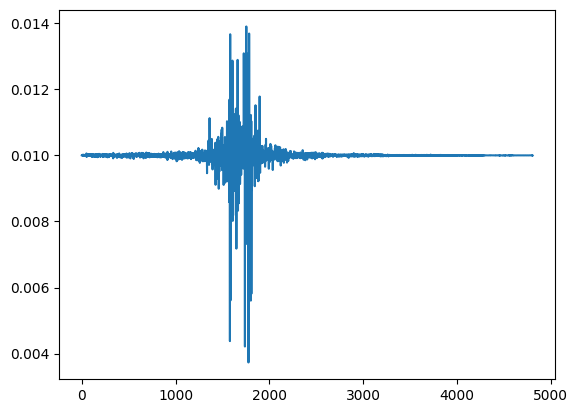

In [168]:
plt.plot(radii[:, 0])
plt.show()
plt.plot(radii[:, 1])
plt.show()

In [175]:
(jnp.abs(radii[:, 1] - 1e-2) > 3e-4).sum()

Array(236, dtype=int32)

In [177]:
flat_radii = []
flat_indices = []
for i in trange(H.shape[0]):
    if jnp.abs(radii[i, 1] - 1e-2) > 3e-4:
        flat_radii.append(find_radius(params_final_rav, evecs[:, i], 1e-2, iters=50))
        flat_indices.append(i)
flat_radii = jnp.array(flat_radii)
flat_indices = jnp.array(flat_indices)

100%|██████████| 4810/4810 [03:16<00:00, 24.50it/s]  


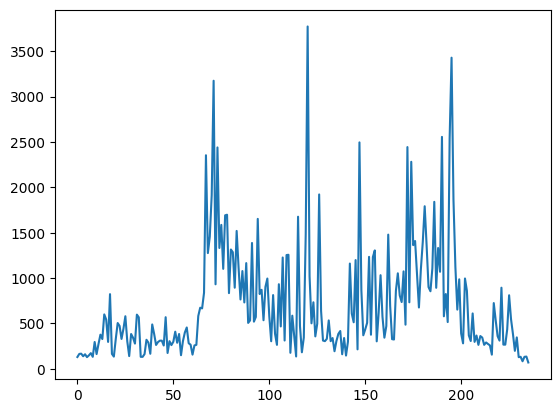

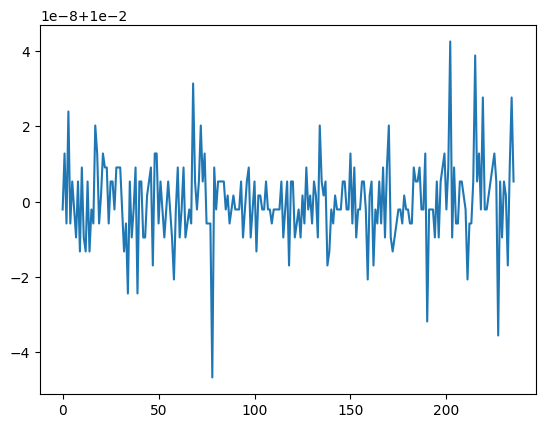

In [178]:
plt.plot(flat_radii[:, 0])
plt.show()
plt.plot(flat_radii[:, 1])
plt.show()

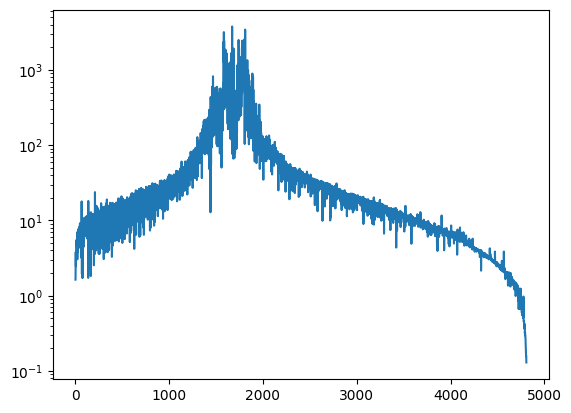

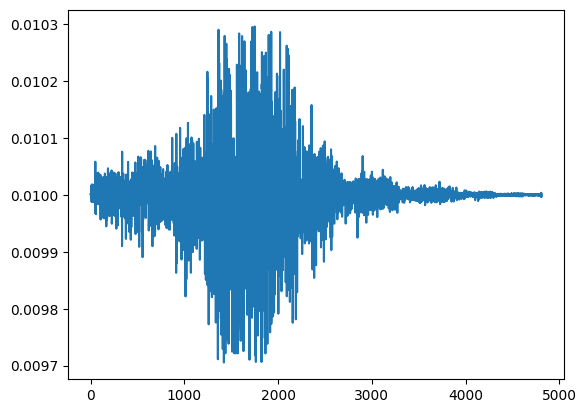

In [182]:
true_radii = radii.at[flat_indices].set(flat_radii)
plt.plot(true_radii[:, 0])
plt.yscale('log')
plt.show()
plt.plot(true_radii[:, 1])
plt.show()

In [214]:
log_ball_fraction = log_hyperball_volume(4810) / jnp.log(10)

In [201]:
jnp.sum(jnp.log10(true_radii[:, 0]))

Array(6222.9854, dtype=float32)

In [215]:
jnp.sum(jnp.log10(true_radii[:, 0])) + log_ball_fraction

Array(329.438, dtype=float32)

In [212]:
radius_sum = 0
for seed in range(10):
    random_direction = jax.random.normal(jax.random.key(seed+30), shape=(4810,))
    random_direction = random_direction / jnp.linalg.norm(random_direction)
    rand_radius = find_radius(params_final_rav, random_direction, 1e-2, iters=50)
    radius_sum += jnp.log10(rand_radius[0])

In [216]:
4810 * radius_sum / 10 + log_ball_fraction

Array(-3952.0327, dtype=float32)

In [209]:
4810 * jnp.log10(rand_radius[0])

Array(1391.2368, dtype=float32)

In [185]:
jnp.exp(log_hyperball_volume(3)), 4/3 * jnp.pi

(Array(4.1887884, dtype=float32, weak_type=True), 4.1887902047863905)

In [195]:
4/3 * jnp.pi / 8, jnp.exp(log_hyperball_volume(3) - 3 * jnp.log(2))

(0.5235987755982988, Array(0.52359855, dtype=float32, weak_type=True))

In [198]:
log_hyperball_volume(4810) / jnp.log(10)

Array(-5893.5474, dtype=float32, weak_type=True)

In [196]:
log_hyperball_volume(4810) / jnp.log(10) - 4810 * jnp.log10(2)

Array(-7341.5015, dtype=float32)

In [150]:
evecs.shape

(4810, 4810)

In [153]:
jnp.linalg.norm(H - H.T), jnp.linalg.norm(H)

(Array(0.00053201, dtype=float32), Array(2.0684144, dtype=float32))

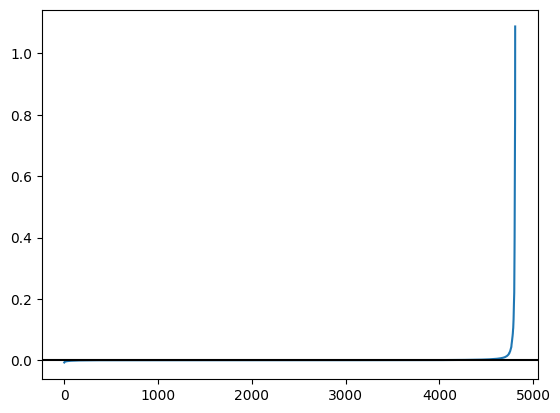

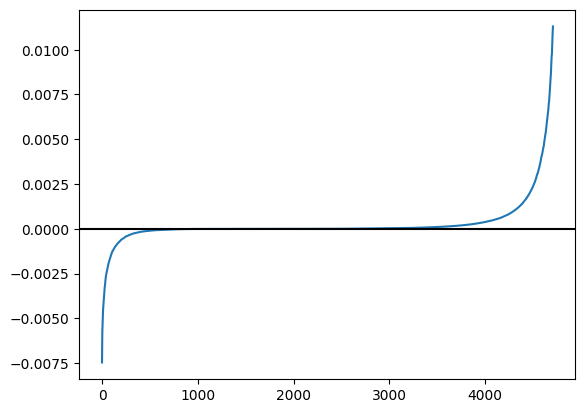

In [156]:
plt.plot(evals)
plt.axhline(0, color='k')
plt.show()

plt.plot(evals[:-100])
plt.axhline(0, color='k')
plt.show()

In [158]:
jnp.sum(evals > 0), jnp.sum(evals < 0)

(Array(3108, dtype=int32), Array(1702, dtype=int32))

### LDJ

In [124]:
jnp.linalg.slogdet(J_unorth).logabsdet / jnp.log(10)

Array(-603.572, dtype=float32)

In [125]:
J_random_init = jac_fn(params_rand_rav)
print(J_random_init.shape)

(4810, 4810)


In [127]:
params_unit = params_rand_rav / jnp.linalg.norm(params_rand_rav)
proj_param = einsum(params_unit, params_unit, 'i, j -> i j')
J_ri_unorth = J_random_init + proj_param

In [128]:
jnp.linalg.slogdet(J_ri_unorth).logabsdet / jnp.log(10)

Array(-366.2315, dtype=float32)

In [131]:
jnp.sum(jnp.log10(s_unorth))

Array(-603.6118, dtype=float32)

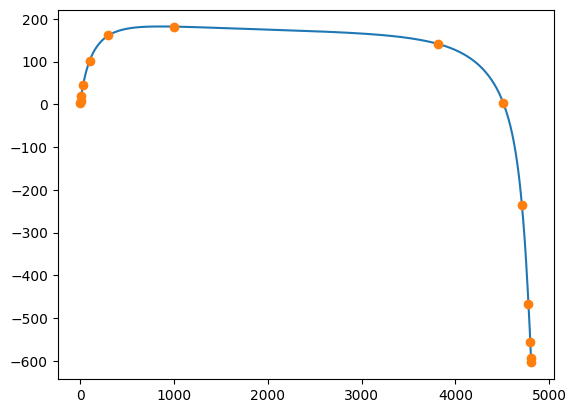

0 2.0689993 2.0689993
3 1.8437469 7.7901735
10 1.5375453 19.280525
30 1.1382844 44.999214
100 0.57529473 102.1403
300 0.14040983 161.1074
1000 -0.003921645 181.71571
-1000 -0.05959483 141.6198
-300 -0.56881195 3.960329
-100 -2.409629 -234.90448
-30 -4.195261 -466.2236
-10 -4.8138256 -556.3393
-3 -5.5355444 -592.3709
-1 -5.6423893 -603.6118


In [142]:
cumsum = jnp.cumsum(jnp.log10(s_unorth))
plt.plot(cumsum)
plt.plot([i % 4810 for i in indices], [cumsum[i] for i in indices], 'o')
plt.show()
for i in indices:
    print(i, jnp.log10(s_unorth[i]), cumsum[i])

### Geometry

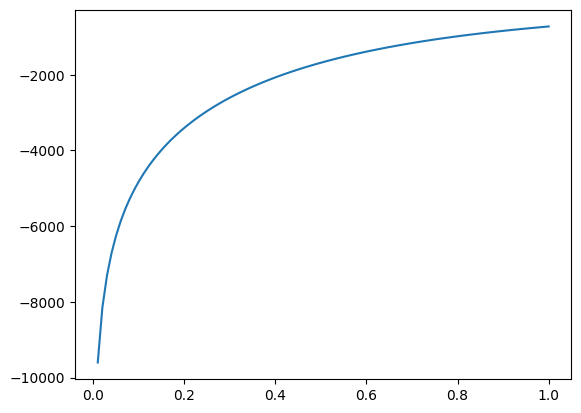

In [269]:
dim = params_init.raveled.shape[0]
xs = jnp.linspace(0, 1, 100)
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys

plt.plot(xs, jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs]))
plt.show()


In [77]:
jax.scipy.stats.norm.logcdf(-1), jnp.log(jax.scipy.stats.norm.cdf(-1))

(Array(-1.8410214, dtype=float32), Array(-1.8410214, dtype=float32))

In [110]:
def hyperspherical_cap(dim, h):
    return 1/2 * jax.scipy.special.betainc((dim - 1) / 2, 1/2, (2*h - h**2))

In [187]:
def hyperball_volume(dim):
    return jnp.pi**(dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)

def hypersphere_area(dim):
    return 2 * jnp.pi**(dim / 2) / jax.scipy.special.gamma(dim / 2)

def small_hyperspherical_cap(dim, h):
    r = jnp.sqrt(2 * h - h**2)
    return hyperball_volume(dim - 1) * r**(dim - 1) / hypersphere_area(dim)

def log_hyperball_volume(dim):
    return (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2 + 1)

def log_hypersphere_area(dim):
    return jnp.log(2) + (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2)

def log_small_hyperspherical_cap(dim, h, angle=False):
    x = jnp.sqrt(2 * h - h**2)
    t = jnp.arctan(x / (1 - h))
    logr = jnp.log(t) if angle else jnp.log(x)
    return (dim - 1) * logr + log_hyperball_volume(dim - 1) - log_hypersphere_area(dim)


In [161]:
small_hyperspherical_cap(3, .1), hyperspherical_cap(3, .1)

(Array(0.04750001, dtype=float32, weak_type=True),
 Array(0.04999997, dtype=float32, weak_type=True))

In [141]:
print(hypersphere_area(3), hyperball_volume(3))
print(4 * jnp.pi, 4 / 3 * jnp.pi)
print(hypersphere_area(2), hyperball_volume(2))

12.566366 4.188789
12.566370614359172 4.1887902047863905
6.2831855 3.1415927


In [143]:
dim = 4810
h = 0.5
print(jax.scipy.special.betainc((dim - 1) / 2, 1/2, (2*h - h**2)))
print(jax.scipy.special.beta((dim - 1) / 2, 1/2))

0.0
0.036148105


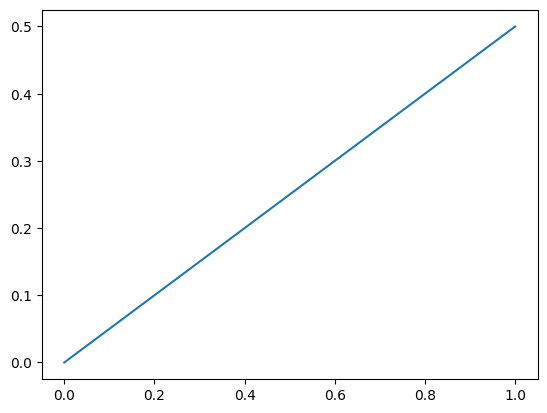

In [198]:
dim = 3
hs = jnp.linspace(0, 1, 100)
plt.plot(hs, jnp.array([hyperspherical_cap(dim, h) for h in hs]))
plt.show()

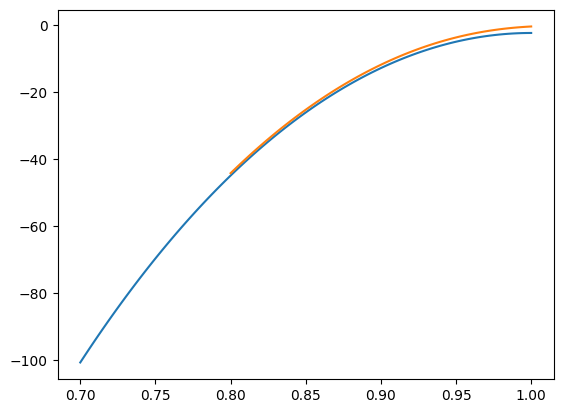

In [267]:
dim = 4810
hs = jnp.linspace(0.7, 1, 100)
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs]))
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) / jnp.log(10) for h in hs]))
#plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h, angle=True) for h in hs]))
#plt.yscale('log')
# plt.xscale('log')
plt.show()

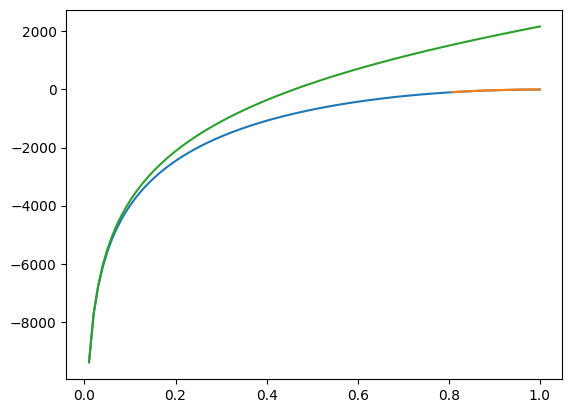

In [ ]:
dim = 4810
hs = jnp.linspace(0, 1, 100)
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h) for h in hs]))
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) for h in hs]))
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h, angle=True) for h in hs]))
#plt.yscale('log')
# plt.xscale('log')
plt.show()

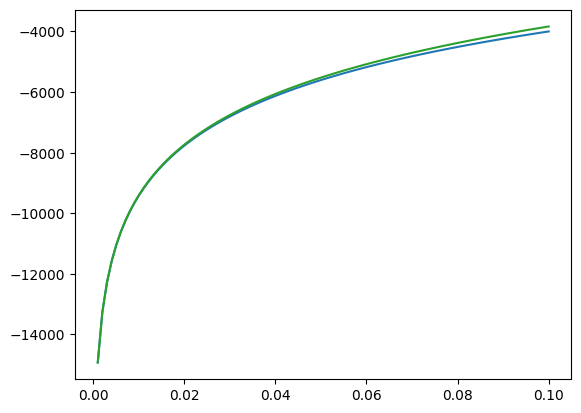

In [194]:
dim = 4810
hs = jnp.linspace(0, .1, 100)
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h) for h in hs]))
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) for h in hs]))
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h, angle=True) for h in hs]))
#plt.yscale('log')
# plt.xscale('log')
plt.show()

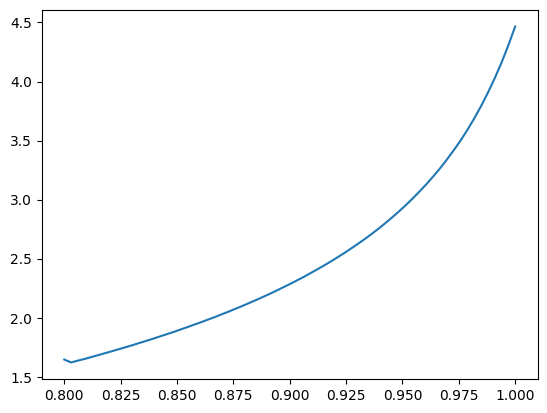

In [186]:
dim = 4810
hs = jnp.linspace(.7, 1, 100)
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) - log_small_hyperspherical_cap(dim, h) for h in hs]))

#plt.yscale('log')
#plt.xscale('log')
plt.show()

4810


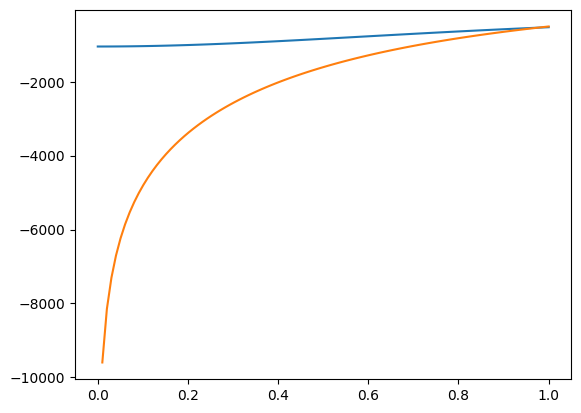

In [103]:
dim = params_init.raveled.shape[0]
print(dim)

def mult_prob(mult):
    x = mult / jnp.sqrt(mult**2 + 1)
    y = 1 / jnp.sqrt(mult**2 + 1)
    z = y * jnp.sqrt(dim)
    # one-tailed normal cdf
    return jax.scipy.stats.norm.logcdf(-z) / jnp.log(10)

def mult_prob_planar(mult):
    x = mult / jnp.sqrt(mult**2 + 1)
    y = 1 / jnp.sqrt(mult**2 + 1)
    t = jnp.arctan(x / y)
    return jnp.log(t) * (dim - 1) / jnp.log(10)

xs = jnp.linspace(0, 1, 100)
plt.plot(xs, jnp.array([mult_prob(x) for x in xs]))
plt.plot(xs, jnp.array([mult_prob_planar(x) for x in xs]))
#plt.ylim(-100, 0)
plt.show()

## Final basin 09-25

In [234]:
ellipsoid_norm(params_spher, spherical=True), ellipsoid_norm(params_final, spherical=True)

(Array(57.883167, dtype=float32), Array(57.88317, dtype=float32))

In [277]:

poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_spher.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
    target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
)

params_final = Params(state.params['p'], params_spher.unravel)
print(metrics(params_final, X_train, Y_train))
print(metrics(params_final, X_untrain, Y_untrain))
print(metrics(params_final, X_test, Y_test))

train_accs_mp = []
test_accs_mp = []
ell_norms_mp = []

xs = jnp.linspace(0, 10, 100)

for mult in tqdm(xs):
    params_mult_rav = (params_rand_rav * mult + params_final.raveled)
    params_mult_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_mult_rav)
    params_mult = Params(params_mult_rav, params_final.unravel)

    ell_norms_mp.append(ellipsoid_norm(params_mult, spherical=True))
    loss, acc = metrics(params_mult, X_train, Y_train)
    train_accs_mp.append(acc)
    loss, acc = metrics(params_mult, X_test, Y_test)
    test_accs_mp.append(acc)
    #print(loss, acc)

(Array(0.02561148, dtype=float32), Array(1., dtype=float32))
(Array(2.8363895, dtype=float32), Array(0.3138021, dtype=float32))
(Array(1.2815756, dtype=float32), Array(0.67432946, dtype=float32))


100%|██████████| 100/100 [00:01<00:00, 57.68it/s]


In [236]:
ellipsoid_norm(params_init, spherical=True)

Array(8.545308, dtype=float32)

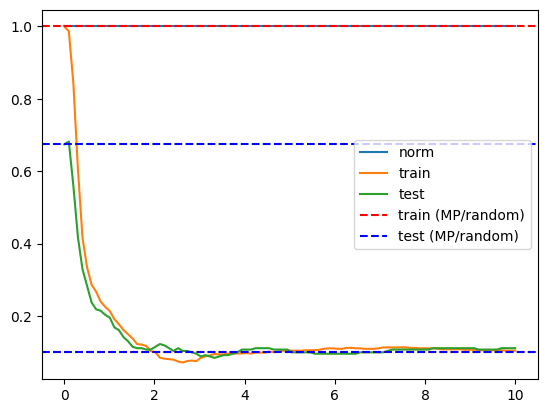

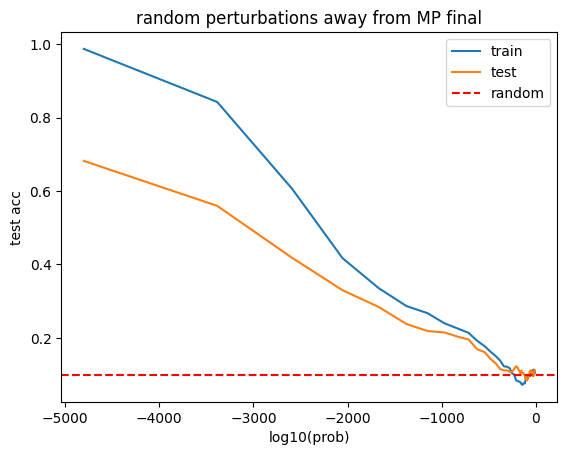

In [278]:
# params_init_spher = Params(
#     params_init.raveled * ellipsoid_norm(params_spher, spherical=True) / ellipsoid_norm(params_init, spherical=True), 
#     params_init.unravel)
# train_init, test_init = current_metrics(params_init_spher)
train_spher, test_spher = current_metrics(params_final)

plt.plot(xs, jnp.array(ell_norms_mp) / jnp.linalg.norm(params_spher.raveled), label='norm')
plt.plot(xs, jnp.array(train_accs_mp), label='train')
plt.plot(xs, jnp.array(test_accs_mp), label='test')
# plt.plot(xs, jnp.array(train_accs_0))
# plt.plot(xs, jnp.array(test_accs_0))
# plt.plot(xs, jnp.array(train_accs_1))
# plt.plot(xs, jnp.array(test_accs_1))

# horizontal lines
plt.axhline(0.1, color='r', linestyle='--', label='train (MP/random)')
plt.axhline(0.1, color='b', linestyle='--', label='test (MP/random)')
plt.axhline(train_spher, color='r', linestyle='--')
plt.axhline(test_spher, color='b', linestyle='--')
plt.legend()
plt.show()

dim = params_init.raveled.shape[0]
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys
caps = jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs])
plt.plot(caps, jnp.array(train_accs_mp), label='train')
plt.plot(caps, jnp.array(test_accs_mp), label='test')
plt.axhline(0.1, color='r', linestyle='--', label='random')
plt.xlabel("log10(prob)")
plt.ylabel("test acc")
plt.title("random perturbations away from MP final")
plt.legend()
plt.show()


### Random init

In [251]:
ellipsoid_norm(params_rand, spherical=True)

Array(57.883175, dtype=float32)

In [253]:
current_metrics(params_rand), final_metrics(params_rand)

((Array(0.10026042, dtype=float32), Array(0.09961686, dtype=float32)),
 (Array(0.99869794, dtype=float32), Array(0.95402294, dtype=float32)))

In [279]:


poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_randinit.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
    target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
)

params_final = Params(state.params['p'], params_spher.unravel)
print(metrics(params_final, X_train, Y_train))
print(metrics(params_final, X_untrain, Y_untrain))
print(metrics(params_final, X_test, Y_test))

train_accs_randinit = []
test_accs_randinit = []
ell_norms_randinit = []

xs = jnp.linspace(0, 10, 100)

for mult in tqdm(xs):
    params_mult_rav = (params_rand_rav * mult + params_final.raveled)
    params_mult_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_mult_rav)
    params_mult = Params(params_mult_rav, params_final.unravel)

    ell_norms_randinit.append(ellipsoid_norm(params_mult, spherical=True))
    loss, acc = metrics(params_mult, X_train, Y_train)
    train_accs_randinit.append(acc)
    loss, acc = metrics(params_mult, X_test, Y_test)
    test_accs_randinit.append(acc)
    #print(loss, acc)

(Array(0.01317628, dtype=float32), Array(0.99869794, dtype=float32))
(Array(0.232047, dtype=float32), Array(0.94140625, dtype=float32))
(Array(0.29514045, dtype=float32), Array(0.92720306, dtype=float32))


100%|██████████| 100/100 [00:01<00:00, 60.60it/s]


In [264]:
final_metrics(params_rand), current_metrics(params_final)

((Array(0.99869794, dtype=float32), Array(0.95402294, dtype=float32)),
 (Array(0.99869794, dtype=float32), Array(0.92720306, dtype=float32)))

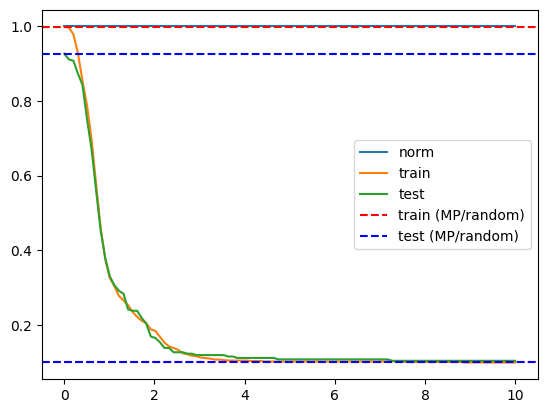

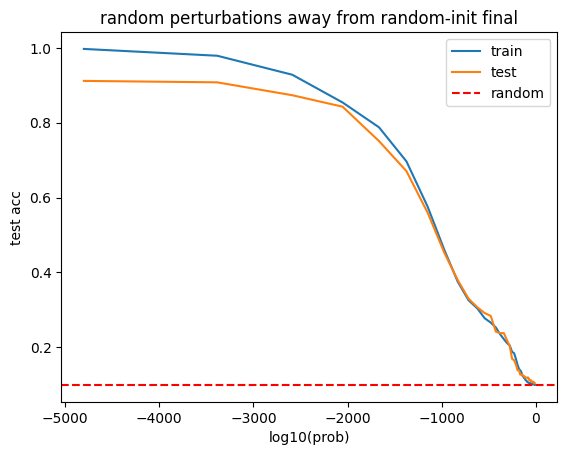

In [282]:
train_final, test_final = current_metrics(params_final)

plt.plot(xs, jnp.array(ell_norms_randinit) / jnp.linalg.norm(params_spher.raveled), label='norm')
plt.plot(xs, jnp.array(train_accs_randinit), label='train')
plt.plot(xs, jnp.array(test_accs_randinit), label='test')
# plt.plot(xs, jnp.array(train_accs_0))
# plt.plot(xs, jnp.array(test_accs_0))
# plt.plot(xs, jnp.array(train_accs_1))
# plt.plot(xs, jnp.array(test_accs_1))

# horizontal lines
plt.axhline(0.1, color='r', linestyle='--', label='train (MP/random)')
plt.axhline(0.1, color='b', linestyle='--', label='test (MP/random)')
plt.axhline(train_final, color='r', linestyle='--')
plt.axhline(test_final, color='b', linestyle='--')
plt.legend()
plt.show()

dim = params_init.raveled.shape[0]
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys
caps = jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs])
plt.plot(caps, jnp.array(train_accs_randinit), label='train')
plt.plot(caps, jnp.array(test_accs_randinit), label='test')
plt.axhline(0.1, color='r', linestyle='--', label='random')
plt.xlabel("log10(prob)")
plt.ylabel("test acc")
plt.title("random perturbations away from random-init final")
plt.legend()
plt.show()

# 09-24

In [ ]:
cfg = mp.MetaConfig(num_layers=1, weird_xent=True)

In [ ]:
seed = 0

if cfg.task == "digits":
    # Load data
    X, Y = mp.load_digits(return_X_y=True)
    X = X / 16.0  # Normalize

    # Split data into "train" and "test" sets
    X_nontest, X_test, Y_nontest, Y_test = mp.train_test_split(
        X, Y, test_size=261, random_state=0, stratify=Y,
    )

    X_train, X_untrain, Y_train, Y_untrain = mp.train_test_split(
        X_nontest, Y_nontest, test_size=768, random_state=0, stratify=Y_nontest,
    )
    
    d_inner = X.shape[1]

    model = MLP(hidden_sizes=(d_inner,) * cfg.num_layers, out_features=10, 
                norm_scale=cfg.norm_scale,
                )
else:
    raise ValueError(f"Unknown task: {cfg.task}")

In [ ]:
key = jax.random.key(seed)

params_init = model.init(key, X_nontest)

params_init = Params(params_init)

2024-09-26 19:17:23.646620: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 09-24+ param metrics

In [9]:
with open('pinit_0924_fast_unx.npy', 'rb') as f:
    params_mp = Params(jnp.load(f, allow_pickle=True), params_init.unravel)

In [10]:
params_init.raveled.shape, params_mp.raveled.shape

((4810,), (4810,))

In [11]:
for layer in params_mp.unraveled['params']:
    print(layer)
    ker_std = jnp.std(params_mp.unraveled['params'][layer]['kernel'])
    print(ker_std)
    bias_std = jnp.std(params_mp.unraveled['params'][layer]['bias'])
    print(bias_std)
    print(ker_std / bias_std)

print("\ninit")
for layer in params_init.unraveled['params']:
    print(layer)
    ker_std = jnp.std(params_init.unraveled['params'][layer]['kernel'])
    print(ker_std)
    bias_std = jnp.std(params_init.unraveled['params'][layer]['bias'])
    print(bias_std)
    print(ker_std / bias_std)

Dense_0
0.89430004
0.54051656
1.6545285
Dense_1
1.2066885
0.2697095
4.4740305

init
Dense_0
0.1232844
0.07370406
1.6726949
Dense_1
0.12716304
0.06514513
1.9519962


In [12]:
def metrics(params, x, y):
    logits = model.apply(params.unraveled, x)
    preds = jnp.argmax(logits, axis=1)

    loss = mp.sparse_xent(logits, y).mean()
    acc = jnp.mean(preds == y)
    return loss, acc

In [13]:
for paramset in ["mp", "init"]:
    for dataset in ["train", "untrain", "test"]:
        print(f"{paramset} {dataset}")
        if paramset == "mp":
            params = params_mp
        else:
            params = params_init
        if dataset == "train":
            x, y = X_train, Y_train
        elif dataset == "untrain":
            x, y = X_untrain, Y_untrain
        elif dataset == "test":
            x, y = X_test, Y_test
        print(metrics(params, x, y))

mp train
(Array(13.829997, dtype=float32), Array(0.125, dtype=float32))
mp untrain
(Array(15.197811, dtype=float32), Array(0.10416667, dtype=float32))
mp test
(Array(14.987979, dtype=float32), Array(0.08429118, dtype=float32))
init train
(Array(2.4343934, dtype=float32), Array(0.05859375, dtype=float32))
init untrain
(Array(2.4380255, dtype=float32), Array(0.06119792, dtype=float32))
init test
(Array(2.4398324, dtype=float32), Array(0.0651341, dtype=float32))


In [14]:
ellipsoid_norm(params_mp), ellipsoid_norm(params_init)

(Array(65.42086, dtype=float32), Array(8.591905, dtype=float32))

In [15]:

apply_fn = mp.make_apply_full(model, params_mp.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_final = Params(state.params['p'], params_mp.unravel)
ellipsoid_norm(params_mp_final)

1.3152938 2.629514 3.5540023 0.001073502


Array(66.82262, dtype=float32)

In [16]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss) = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5973504 3.1626384 0.2066748 0.032062367


In [17]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_mp), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.6026708 3.1223788 0.38736975 0.082962796


In [18]:
params_final = Params(state.params['p'], params_init.unravel)
ellipsoid_norm(params_final)

Array(65.42086, dtype=float32)

In [19]:
print(metrics(params_mp_final, X_train, Y_train))
print(metrics(params_mp_final, X_untrain, Y_untrain))
print(metrics(params_mp_final, X_test, Y_test))
print()
print(metrics(params_final, X_train, Y_train))
print(metrics(params_final, X_untrain, Y_untrain))
print(metrics(params_final, X_test, Y_test))

(Array(0.00107342, dtype=float32), Array(1., dtype=float32))
(Array(6.434123, dtype=float32), Array(0.3932292, dtype=float32))
(Array(3.5540023, dtype=float32), Array(0.6819923, dtype=float32))

(Array(0.08294203, dtype=float32), Array(0.98307294, dtype=float32))
(Array(0.31243584, dtype=float32), Array(0.9231771, dtype=float32))
(Array(0.38736975, dtype=float32), Array(0.90804595, dtype=float32))


In [36]:
with open('pinit_0924_beta.npy', 'rb') as f:
    params_mp_beta = Params(jnp.load(f, allow_pickle=True), params_init.unravel)

In [37]:
print(metrics(params_mp_beta, X_train, Y_train))
print(metrics(params_mp_beta, X_untrain, Y_untrain))
print(metrics(params_mp_beta, X_test, Y_test))

(Array(9.270195, dtype=float32), Array(0.109375, dtype=float32))
(Array(10.75273, dtype=float32), Array(0.10026042, dtype=float32))
(Array(10.458572, dtype=float32), Array(0.10344827, dtype=float32))


In [38]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp_beta.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_beta_final = Params(state.params['p'], params_mp_beta.unravel)
print(ellipsoid_norm(params_mp_beta_final))
print(metrics(params_mp_beta_final, X_train, Y_train))
print(metrics(params_mp_beta_final, X_untrain, Y_untrain))
print(metrics(params_mp_beta_final, X_test, Y_test))

1.2472287 2.432509 3.3163686 0.06194843
71.86641
(Array(0.06190597, dtype=float32), Array(0.9934896, dtype=float32))
(Array(6.459947, dtype=float32), Array(0.1888021, dtype=float32))
(Array(3.3163686, dtype=float32), Array(0.52873564, dtype=float32))


In [42]:
with open('pinit_0924_temp10.npy', 'rb') as f:
    params_mp_temp10 = Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(metrics(params_mp_temp10, X_train, Y_train))
print(metrics(params_mp_temp10, X_untrain, Y_untrain))
print(metrics(params_mp_temp10, X_test, Y_test))

(Array(2.5681047, dtype=float32), Array(0.22526042, dtype=float32))
(Array(3.6083674, dtype=float32), Array(0.12369792, dtype=float32))
(Array(3.136961, dtype=float32), Array(0.16858236, dtype=float32))


In [43]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp_temp10.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_temp10_final = Params(state.params['p'], params_mp_temp10.unravel)
print(ellipsoid_norm(params_mp_temp10_final))
print(metrics(params_mp_temp10_final, X_train, Y_train))
print(metrics(params_mp_temp10_final, X_untrain, Y_untrain))
print(metrics(params_mp_temp10_final, X_test, Y_test))

1.3344964 2.6363978 1.115871 0.032595
52.805744
(Array(0.03258885, dtype=float32), Array(1., dtype=float32))
(Array(2.141078, dtype=float32), Array(0.42578125, dtype=float32))
(Array(1.115871, dtype=float32), Array(0.6781609, dtype=float32))


In [44]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_mp_temp10), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5982022 3.1423912 0.26220772 0.054013327


In [26]:
with open('pinit_0924_temp30.npy', 'rb') as f:
    params_init_temp30 = Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(metrics(params_init_temp30, X_train, Y_train))
print(metrics(params_init_temp30, X_untrain, Y_untrain))
print(metrics(params_init_temp30, X_test, Y_test))

print(ellipsoid_norm(params_init_temp30))

(Array(3.6107712, dtype=float32), Array(0.234375, dtype=float32))
(Array(4.75563, dtype=float32), Array(0.13151042, dtype=float32))
(Array(4.0160975, dtype=float32), Array(0.16858236, dtype=float32))
48.91086


In [29]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init_temp30.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)
params_init_temp30_final = Params(state.params['p'], params_init_temp30.unravel)
print(ellipsoid_norm(params_init_temp30_final))

print(metrics(params_init_temp30_final, X_train, Y_train))
print(metrics(params_init_temp30_final, X_untrain, Y_untrain))
print(metrics(params_init_temp30_final, X_test, Y_test))

1.3372502 2.6625676 1.0447685 0.011932822
50.174908
(Array(0.01193103, dtype=float32), Array(1., dtype=float32))
(Array(2.1693647, dtype=float32), Array(0.4388021, dtype=float32))
(Array(1.0447685, dtype=float32), Array(0.72796935, dtype=float32))


In [27]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_init_temp30), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5982733 3.1450882 0.24960268 0.051458344


# 09-20

In [4]:
params = model.init(jax.random.key(seed), X_nontest)
# params = force_init(params)
params['params']

2024-09-21 01:16:26.465356: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{'Dense_0': {'kernel': Array([[ 0.08502878, -0.07660222,  0.14851311, ..., -0.15960957,
          -0.47247475,  0.24392404],
         [-0.5197594 ,  0.29568127,  0.40953675, ..., -0.39873227,
          -0.38933071,  0.02376415],
         [-0.00659077, -0.20023757, -0.06835359, ...,  0.2437357 ,
           0.2736246 ,  0.24239159],
         ...,
         [ 0.00982806,  0.24898066, -0.30233094, ...,  0.16014011,
           0.13457227,  0.17770955],
         [-0.02186053, -0.27869353,  0.10522984, ..., -0.41000146,
           0.06080976, -0.23033434],
         [ 0.12137023, -0.13249858, -0.2501013 , ..., -0.1289176 ,
           0.18719564, -0.16156396]], dtype=float32),
  'bias': Array([-0.3087975 , -0.10901368,  0.08813022, -0.02471822,  0.01553636,
          0.03097359,  0.01070679, -0.09311437,  0.10348435, -0.00330067,
          0.03199795, -0.10143498, -0.18882768, -0.2917246 ,  0.20614561,
          0.15992309,  0.16927998, -0.04964967, -0.11802278,  0.1336633 ,
          0.0639345 

In [5]:
ker0 = params['params']['Dense_0']['kernel']
jnp.max(ker0) / jnp.std(ker0), jnp.min(ker0) / jnp.std(ker0), jnp.std(ker0)
# ker0.shape
# ker1 = params['params']['Dense_1']['kernel']
# ker1.shape

(Array(3.2198756, dtype=float32),
 Array(-4.367447, dtype=float32),
 Array(0.2465688, dtype=float32))

In [6]:
bias0 = params['params']['Dense_0']['bias']
jnp.max(bias0) / jnp.std(bias0), jnp.min(bias0) / jnp.std(bias0), jnp.std(bias0)

(Array(1.7660469, dtype=float32),
 Array(-2.7418196, dtype=float32),
 Array(0.14740811, dtype=float32))

def typicalize(params):
    out_params = {}
    for layer in ['Dense_0', 'Dense_1']:
        ker = params['params'][layer]['kernel']
        bias = params['params'][layer]['bias']
        ker /= jnp.sqrt(ker.shape[1]) * jnp.std(ker)
        bias /= jnp.sqrt(3 * ker.shape[1]) * jnp.std(bias)
        out_params[layer] = {'kernel': ker, 'bias': bias}
    return {'params': out_params}

In [8]:
params['params']['Dense_6']['kernel'].shape

(64, 10)

In [7]:
for layer in params['params']:
    print(layer)
    print(jnp.std(params['params'][layer]['kernel']))
    print(jnp.std(params['params'][layer]['bias']))

params2 = typicalize(params)
for layer in params2['params']:
    print(layer)
    print(jnp.std(params2['params'][layer]['kernel']))
    print(jnp.std(params2['params'][layer]['bias']))

Dense_0
0.2465688
0.14740811
Dense_1
0.24561265
0.13499576
Dense_2
0.25397843
0.15579416
Dense_3
0.24965435
0.14971851
Dense_4
0.24889001
0.14665765
Dense_5
0.24693763
0.13225272
Dense_6
0.26101363
0.1148481
Dense_0
Dense_1
Dense_2
Dense_3
Dense_4
Dense_5
Dense_6
Dense_0
0.24999999
0.14433756
Dense_1
0.25
0.14433756
Dense_2
0.25
0.14433756
Dense_3
0.24999999
0.14433758
Dense_4
0.25
0.14433756
Dense_5
0.25
0.14433758
Dense_6
0.24999999
0.14433756


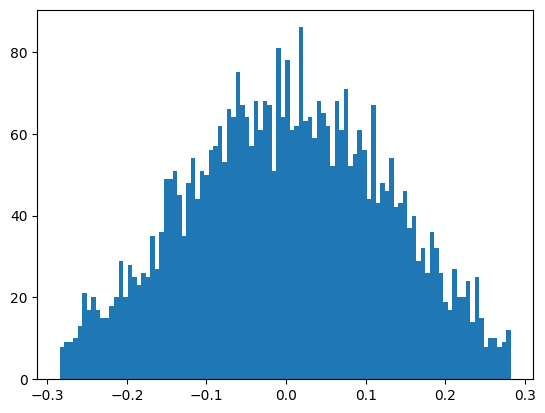

In [12]:
import matplotlib.pyplot as plt
plt.hist(params['params']['Dense_0']['kernel'].flatten(), bins=100)
plt.show()